# Inferring Timing Properties using SBI

We want to accurately infer timing properties of stochastic light curves in X-rays 
under the presence of dead time. Dead time has the problem that we can't really write a good model 
down for it for any given light curve, because it depends on the flux at any given moment, which is 
a stochastic process for the cases we are considering. 

However, *simulating* dead time is fairly straightforward, if the dead time process of the instrument 
is reasonably well known. Here, we're going to use simulation-based inference as implemented in the 
`sbi` package to try and infer properties of a QPO in a single periodogram:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=8)

import numpy as np
import pandas as pd
#from tqdm import tnrange, tqdm_notebook

import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm_notebook, tnrange 
import numba
from numba import jit, njit

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator
from stingray.events import EventList

import warnings
warnings.filterwarnings('ignore')

from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst
from stingray import filters



/astro/users/dhuppenk/.conda/envs/abc/lib/python3.8/site-packages/stingray-0.3.dev70+g1229c81-py3.8.egg/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")


In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi


In [3]:
@jit
def lorentzian(x, amp, x0, fwhm):
    fac1 = amp * (fwhm/2)**2.
    fac2 = (fwhm/2)**2. + (x - x0)**2.
    return fac1/fac2

@jit(nopython=True)
def extract_and_scale(long_lc, red_noise, npoints, mean_counts, rms):
    """
    i) Make a random cut and extract a light curve of required
    length.

    ii) Rescale light curve i) with zero mean and unit standard
    deviation, and ii) user provided mean and rms (fractional
    rms * mean)

    Parameters
    ----------
    long_lc : numpy.ndarray
        Simulated lightcurve of length 'npoints' times 'red_noise'
    
    red_noise : float
        A multiplication factor for the length of the light curve, 
        to deal with red noise leakage
    
    npoints : int
        The total number of data points in the light curve
        
    mean_counts : float
        The mean counts per bin of the light curve to be 
        simulated
        
    rms : float [0, 1]
        The fractional rms amplitude of the variability in the 
        light curve.

    Returns
    -------
    lc : numpy.ndarray
        Normalized and extracted lightcurve of lengtha 'N'
    """
    if red_noise == 1:
        lc = long_lc
    else:
        # Make random cut and extract light curve of length 'N'
        extract = \
            np.random.randint(npoints-1,
                                      red_noise*npoints - npoints+1)
        lc = np.take(long_lc, np.arange(extract, extract + npoints))

    avg = np.mean(lc)
    std = np.std(lc)

    return (lc-avg)/std * mean_counts * rms + mean_counts


@jit(nopython=False)
def simulate_lc(mspec, dt, npoints, mean_counts, rms, tstart = 0.0, red_noise=1.0):
    """
    
    
    
    """

    time = dt*np.arange(npoints) + tstart

    a1 = np.random.normal(size=(2,len(mspec))) * np.sqrt(mspec)

    f = a1[0] + 1j * a1[1]

    f[0] = mean_counts

    # Obtain real valued time series
    f_conj = np.conjugate(np.array(f))

    cts = np.fft.irfft(f_conj, n=npoints)

    lc = Lightcurve(time, extract_and_scale(cts, red_noise, npoints, mean_counts, rms),
                err=np.zeros_like(time) + np.sqrt(mean_counts),
                err_dist='gauss', dt=dt, skip_checks=True)

    return lc

@jit(nopython=True)
def generate_events(time, counts1, counts2):

    cs1 = np.cumsum(counts1)
    cs2 = np.cumsum(counts2)

    times1 = np.zeros(cs1[-1])
    times2 = np.zeros(cs2[-1])

    ncounts = len(counts1)

    for i in range(ncounts):
        times1[cs1[i]:cs1[i+1]] = time[i]
        times2[cs2[i]:cs2[i+1]] = time[i]
        
    return times1, times2

In [4]:
@jit(nopython=False)
def simulate_deadtime(param, freq=None, tseg=10.0, dt_hires=1e-5, dt=0.005, deadtime=0.0025):
    #print("starting function")
    qpo_amp = 1.0 # amplitude of the QPO in CSD
    qpo_rms = param[0] # absolute rms amplitude of the QPO
    qpo_x0 = param[1] # centroid position of the PSD
    qpo_qual = param[2] # quality factor for the QPO
    qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
    mean_cr = param[3] # mean count rate in the light curve

    npoints = int(np.round(tseg/dt_hires)) # total number of points in original light curve

    # count rate in nustar bins
    mean_cr_hires = mean_cr * dt_hires

    if freq is None:
        df_hires = 1.0/tseg # frequency resolution of the PSD/CSD
        fmax_hires = 0.5/dt_hires # maximum frequency in the CSD/PSD

        # list of frequencies
        freq = np.arange(df_hires, fmax_hires+df_hires, df_hires)

    # generate theoretical spectrum
    mspec = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

    #print("simulating light curves")
    lc = simulate_lc(mspec, dt_hires, npoints, mean_cr_hires, qpo_rms)
    lc.counts[lc.counts < 0] = 0.0

    #print("applying counts")
    # apply counts
    counts1 = np.random.poisson(lc.counts)
    counts2 = np.random.poisson(lc.counts)

    counts_total = counts1 + counts2

    #print("generating events")
    times1, times2 = generate_events(lc.time, counts1, counts2)

    #print("deadtime filtering")
    mask1 = filters.get_deadtime_mask(times1, deadtime, return_all=False)
    mask2 = filters.get_deadtime_mask(times2, deadtime, return_all=False)

    times1_dt = times1[mask1]
    times2_dt = times2[mask2]
    
    #print("generating light curves")
    lc1 = Lightcurve.make_lightcurve(times1, dt=dt, tseg=tseg, tstart=0.0)
    lc1_dt = Lightcurve.make_lightcurve(times1_dt, dt=dt, tseg=tseg, tstart=0.0)

    lc2 = Lightcurve.make_lightcurve(times2, dt=dt, tseg=tseg, tstart=0.0)
    lc2_dt = Lightcurve.make_lightcurve(times2_dt, dt=dt, tseg=tseg, tstart=0.0)

    #lc_sim = lc1 + lc2
    #lc_sim_dt = lc1_dt + lc2_dt

    #print("generating PSDS")
    #ps_sim = Powerspectrum(lc_sim, norm="frac")
    #ps_sim_dt = Powerspectrum(lc_sim_dt, norm="frac")

    #cs_sim = Crossspectrum(lc1, lc2, norm="frac")
    #cs_sim_dt = Crossspectrum(lc1_dt, lc2_dt, norm="frac")

    #print("... and done")
    return lc1, lc2, lc1_dt, lc2_dt

Okay, those are my basic functions. I probably need to turn them into pytorch tensors, but let's keep working with what we have for now. Let's make some data:

In [5]:
np.random.seed(20201204)

qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 20.0 # centroid frequency of the QPO, in Hz
qpo_qual = 10.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.4 # fractional RMS amplitude of the QPO

tseg = 10.0 # total duration in seconds
dt_nustar = 1e-5 # time resolution of NuSTAR
dt = 0.005 # time step of the output light curve
npoints = int(np.round(tseg/dt_nustar)) # total number of points in original light curve

mean_countrate_obs = 1000
mean_counts_nustar_obs = mean_countrate_obs * dt_nustar

df_nustar = 1.0/tseg # frequency resolution of the PSD/CSD
fmax_nustar = 0.5/dt_nustar # maximum frequency in the CSD/PSD

# dead time for nustar
deadtime_nustar = 0.0025

# list of frequencies
freq = np.linspace(df_nustar, fmax_nustar, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

# store parameters in a list for easy (plotting) access
param_obs = [rms_obs, qpo_x0, qpo_qual, mean_countrate_obs]

# generate some ligth curves, both with (*_dt) and without dead time
lc1_obs, lc2_obs, lc1_obs_dt, lc2_obs_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)

Let's make both PSDs and CSDs of the light curves, and then plot both the light curves, PSDs and CSDs

In [6]:
lc_obs = lc1_obs + lc2_obs
lc_obs_dt = lc1_obs_dt + lc2_obs_dt

ps_obs = Powerspectrum(lc_obs, norm="frac")
ps_obs_dt = Powerspectrum(lc_obs_dt, norm="frac")

cs_obs = Crossspectrum(lc1_obs, lc2_obs, norm="frac")
cs_obs_dt = Crossspectrum(lc1_obs_dt, lc2_obs_dt, norm="frac")

In [7]:
np.mean(lc_obs_dt.countrate)

550.2

In [8]:
np.mean(lc_obs.countrate)

1999.5

In [9]:
np.sum(lc_obs.counts)

19995

In [10]:
np.sum(lc_obs_dt.counts)

5502

In [11]:
(np.sum(lc_obs.counts) - np.sum(lc_obs_dt.counts)) / np.sum(lc_obs.counts)

0.7248312078019505

In [12]:
ps_obs.freq[-1]

99.9

In [13]:
sns.set_style("white")

<IPython.core.display.Javascript object>


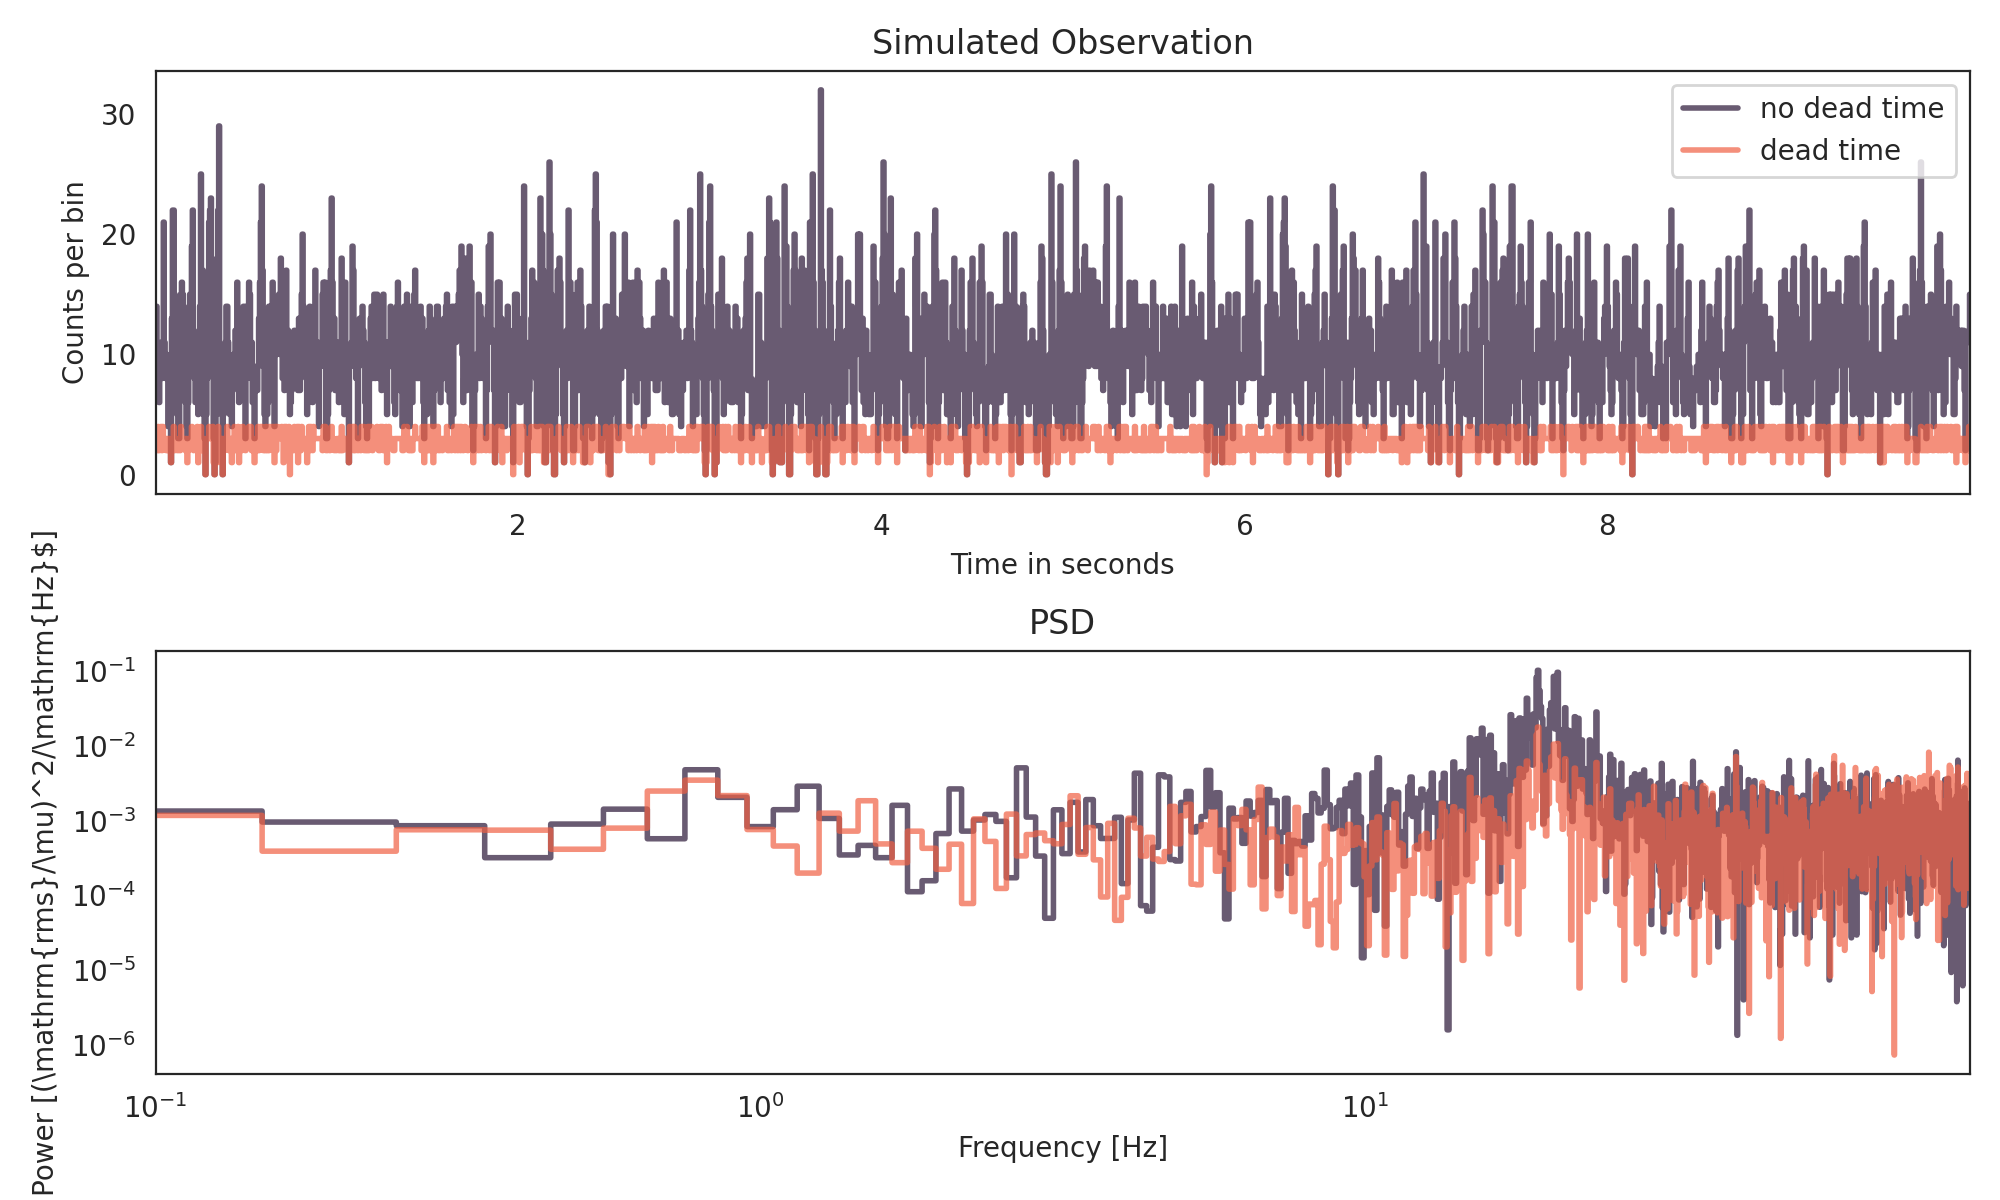

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]

a = 0.7

ax1.plot(lc_obs.time, lc_obs.counts, ds="steps-mid", lw=2, 
         label="no dead time", c=c1, alpha=a)
ax1.plot(lc_obs_dt.time, lc_obs_dt.counts, ds="steps-mid", lw=2, 
         label="dead time", c=c2, alpha=a)
ax1.set_xlabel("Time in seconds")
ax1.set_ylabel("Counts per bin")
ax1.set_title("Simulated Observation")
ax1.set_xlim(lc_obs.time[0], lc_obs.time[-1])

ax2.loglog(ps_obs.freq, ps_obs.power, lw=2, ds="steps-mid", 
           label="no dead time", c=c1, alpha=a)
ax2.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, ds="steps-mid", 
           label="dead time", c=c2, alpha=a)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power [(\mathrm{rms}/\mu)^2/\mathrm{Hz}$]")
ax2.set_title("PSD")
ax2.set_xlim(ps_obs.freq[0], ps_obs.freq[-1])

#ax3.loglog(cs_obs.freq, cs_obs.power, lw=2, ds="steps-mid", 
#           label="no dead time", c=c1, alpha=a)
#ax3.loglog(cs_obs_dt.freq, cs_obs_dt.power, lw=2, ds="steps-mid", 
#           label="dead time", c=c2, alpha=a)
#ax3.set_xlabel("Frequency [Hz]")
#ax3.set_ylabel("Power")
#ax3.set_title("CSD")
#ax3.set_xlim(cs_obs.freq[0], cs_obs.freq[-1])

ax1.legend()

plt.tight_layout()

plt.savefig("../figs/qpo_lf_sim.pdf", format="pdf")

Now we can set up our simulation-based inference. First, we need a function that takes a set of parameters as input, and then returns some form of data we want to compare, in our case the periodogram powers directly:

In [15]:

def generate_simulator_function(tseg=10.0, dt_hires=1e-5, dt=0.005, 
                                deadtime=0.0025, segment_size=1.0, summary_type="psd", f=0.01):
    def simulation(param):
        """
        Generate a simulated data set with a single QPO given a parameter set.

        Parameters
        ----------
        param : iterable
            A list of parameters:
                * Fractional RMS amplitude of the QPO
                * centroid position x0 of teh QPO
                * quality factor (x0/fwhm) of the QPO
                * average count rate of the light curve

        summary_type:
            What to return as a summary. Options are
                * "psd": return the unaveraged powers in the PSD
                * "avg": return averaged PSD, requires `segment_size`

        Returns
        -------
        summary : np.ndarray
            An array of summary statistics

        """

        param = np.array(param)
        #print(param)
        #param = [rms, x0, qual, mean_cr]
        qpo_rms = param[0] # absolute rms amplitude of the QPO
        qpo_x0 = param[1] # centroid position of the PSD
        qpo_qual = param[2] # quality factor for the QPO
        qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
        mean_cr = param[3] # mean count rate in the light curve


        lc1, lc2, lc1_dt, lc2_dt = simulate_deadtime(param, 
                                                     freq=None, 
                                                     tseg=tseg, 
                                                     dt_hires=dt_hires, 
                                                     dt=dt, 
                                                     deadtime=deadtime)


        if summary_type == "psd":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            return torch.as_tensor(ps.power)
        elif summary_type == "avg":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, norm="frac")
            return torch.as_tensor(aps.power)
        elif summary_type == "csd":
            cs = Crossspectrum(lc1_dt, lc2_dt, norm="frac")
            return torch.as_tensor(cs.power)
        elif summary_type == "logbin":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            ps_bin = ps.rebin_log(f)
            return torch.as_tensor(ps_bin.power)
        elif summary_type == "avglogbin":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, 
                                        norm="frac", silent=True)
            aps_bin = aps.rebin_log(f)
            return torch.as_tensor(aps_bin.power)
        else:
            raise ValueError("Type of summary to be returned not recognized!")
            
    return simulation

Next, we need to set up priors. We're going to make some assumptions about what values are reasonable:

In [16]:
lower_bounds = torch.tensor([0.1, 5.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 40.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )

Okay, let's see if we can actually run the neural network emulation. Here's a dictionary with the keyword argument for the simulator:

In [17]:
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.005, "deadtime":0.0025, "summary_type":"psd"}

Now we can generate a simulator function to use in the SBI interface:

In [18]:
sim_func = generate_simulator_function(**simulation_kwargs)

Let's give it a try, just to be sure:

In [19]:
test_data = sim_func(param_obs)

In [20]:
test_data[:10]

tensor([0.0003, 0.0004, 0.0012, 0.0001, 0.0004, 0.0008, 0.0013, 0.0008, 0.0001,
        0.0005], dtype=torch.float64)

Ok, cool. Now, we're going to run the inference interface to build a model for the posterior:

In [21]:
simulator, prior = prepare_for_sbi(sim_func, prior)

In [22]:
inference = SNPE(prior=prior)

We have simulated some data from the prior using the model above, so let's load these from file:

In [23]:
theta = torch.FloatTensor([])
x = torch.FloatTensor([])

for i in range(10):
    try:
        theta0 = torch.FloatTensor(np.loadtxt("../code/sim_lf_psd_embed_theta%i.dat"%i))
        x0 = torch.FloatTensor(np.loadtxt("../code/sim_lf_psd_embed_x%i.dat"%i))
        
        theta = torch.hstack([theta.T, theta0.T]).T
        x = torch.hstack([x.T, x0.T]).T
    
    except:
        continue

In [24]:
theta.shape

torch.Size([50000, 4])

Add simulations to inference object:

In [25]:
inference = inference.append_simulations(theta, x)

Train the density estimator:

In [26]:
density_estimator = inference.train()

Neural network successfully converged after 26 epochs.


Now we can build a posterior:

In [27]:
posterior = inference.build_posterior(density_estimator)

Now we can sample from there:

In [28]:
samples = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_obs_dt.power))

In [19]:
pal = sns.color_palette()

In [20]:
param_names = [r"$\mathrm{rms}_f$", 
               r"$\nu_\mathrm{QPO}$", 
               r"$q_\mathrm{QPO}$",
               r"$\mu_\mathrm{cr}$"
               ]

In [21]:
sns.set_style("white")

In [32]:

fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           labels=param_names,
                           points_offdiag={'markersize': 6},
                           points_colors='r', );

plt.savefig("../figs/qposim_lf_corner.pdf", format="pdf")

<IPython.core.display.Javascript object>

Let's also plot posterior draws:

In [33]:
nsim = 100

samples = np.array(samples)
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

sims_all = []

for i,j in enumerate(idx):

    param_sim = samples[j,:]
    ps_sim = np.array(sim_func(param_sim))
    sims_all.append(ps_sim)


In [34]:

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid", label="simulated observation");

# plot simulations

for i, ps_sim in enumerate(sims_all):
    if i == 0:
        ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid', label="posterior draws")


    if i % 10 == 0:
        ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid')


sims_all = np.array(sims_all)
ps_sim_mean = np.median(sims_all, axis=0)  
ax.loglog(ps_obs_dt.freq, ps_sim_mean, lw=2, c=pal[5], ds="steps-mid", label="posterior mean")
ax.set_xlim(ps_obs_dt.freq[0], ps_obs_dt.freq[-1])
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$(\mathrm{rms}/\mu)^2/\mathrm{Hz}$")
ax.set_title("Simulated low-frequency QPO and posterior draws")
plt.tight_layout()
plt.savefig("../figs/qposim_lf_post_draws.pdf", format="pdf")

<IPython.core.display.Javascript object>

This looks great. Let's generate another data set and sample from the network for comparison:

In [35]:
param_test = [0.25, 30.0, 12.0, 750.0]
# generate some ligth curves, both with (*_dt) and without dead time
lc1_test, lc2_test, lc1_test_dt, lc2_test_dt = simulate_deadtime(param_test, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)
lc_test_dt = lc1_test_dt + lc2_test_dt
ps_test_dt = Powerspectrum(lc_test_dt, norm="frac")
cs_test_dt = Crossspectrum(lc1_test_dt, lc2_test_dt, norm="frac")

In [36]:
samples_test = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_test_dt.power))

In [37]:
pal = sns.color_palette()

In [38]:
#param_names = [r"$\mathrm{rms}_f$", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{cr}$"]
fig, axes =utils.pairplot(samples_test,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_test),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);



<IPython.core.display.Javascript object>

Let's also look at the posterior draws:

In [22]:
def plot_posterior_draws(ps, samples, sim_func, sims=None, nsims=100, 
                         savefig=False, filename="test.pdf", xlim=None, ylim=None):
    """
    Plot the periodogram with posterior draws and the posterior median.
    
    Parameters
    ----------
    ps : stingray.Powerspectrum object
        A stingray.Powerspectrum object with the observed data
        
    samples : iterable
        An array of posterior samples of parameters
        
    sim_func : function
        A function that takes parameters as those saved in `samples`, and returns the 
        simulated powers generated from the model defined in `sim_func`
        
    sims : iterable
        An array of pre-generated simulated powers.
        
    nsims : int, default 100
        If `sims` is `None`, then this number will be used to set the number of simulated 
        periodograms to be generated.
    
    savefig : bool, default False
        If True, save a PDF of the figure to file
        
    filename : str
        If `savefig == True`, use the string in this variable to set the path/filename for 
        the output figure
        
    Returns
    -------
    fig, ax : matplotlib.Figure and matplotlib.Axes objects
    
    """
    
    if sims is None:
        samples = np.array(samples)
        idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsims)

        sims = []

        for i,j in enumerate(idx):

            param_sim = samples[j,:]
            ps_sim = np.array(sim_func(param_sim))
            sims.append(ps_sim)
            
    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    ax.loglog(ps.freq, ps.power, lw=2, color=pal[0], ds="steps-mid", label="simulated observation");

    # plot simulations

    for i, ps_sim in enumerate(sims):
        if i == 0:
            ax.loglog(ps.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                      ds='steps-mid', label="posterior draws")


        if i % 10 == 0:
            ax.loglog(ps.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                      ds='steps-mid')

    if xlim is None:
        xlim = [ps.freq[0], ps.freq[-1]]
    if ylim is None:
        ylim = [np.min(ps.power)/2.0, np.max(ps.power)*2.]
        
    sims = np.array(sims)
    ps_sim_mean = np.median(sims, axis=0)  
    ax.loglog(ps.freq, ps_sim_mean, lw=2, c=pal[5], ds="steps-mid", label="posterior mean")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel(r"$(\mathrm{rms}/\mu)^2/\mathrm{Hz}$")
    #ax.set_title("Simulated low-frequency QPO and posterior draws")
    plt.tight_layout()
    if savefig:
        plt.savefig(filename, format="pdf")
    
    return fig, ax

In [40]:
plot_posterior_draws(ps_test_dt, samples_test, sim_func, savefig=False)

<IPython.core.display.Javascript object>

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulated low-frequency QPO and posterior draws'}, xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

### Building an Embedding Net

I want to build an embedding net to see whether that does a better job:

In [41]:
conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=12, padding=1, stride=1)
pool = nn.MaxPool2d(kernel_size=4, stride=4)
lin = nn.Linear(in_features=25, out_features=10) 

In [42]:
ps_pooled = pool(F.relu(conv1(torch.FloatTensor(ps_obs_dt.power).unsqueeze(0).unsqueeze(0))))

In [43]:
ps_pooled.shape

torch.Size([1, 1, 247])

In [23]:
class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        # 1D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=12, padding=1, stride=1)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=247, out_features=12) 

    def forward(self, x):
        x = x.view(-1, 1, 999)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 247)
        x = F.relu(self.fc(x))
        return x

embedding_net = SummaryNet()


In [45]:
simulator_wrapper, prior = prepare_for_sbi(sim_func, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=3)

# setup the inference procedure with the SNPE-C procedure
inference_en = SNPE(prior=prior, density_estimator=neural_posterior)


In [ ]:
density_estimator_en = inference_en.append_simulations(theta, x).train()

In [47]:
posterior_en = inference_en.build_posterior(density_estimator_en)

In [48]:
samples_en = posterior_en.sample((10000,), 
                           x=torch.as_tensor(ps_obs_dt.power))

In [49]:
param_names = [r"$\mathrm{rms}_f$", 
               r"$\nu_\mathrm{QPO}$", 
               r"$q_\mathrm{QPO}$",
               r"$\mu_\mathrm{cr}$"
               ]

<IPython.core.display.Javascript object>


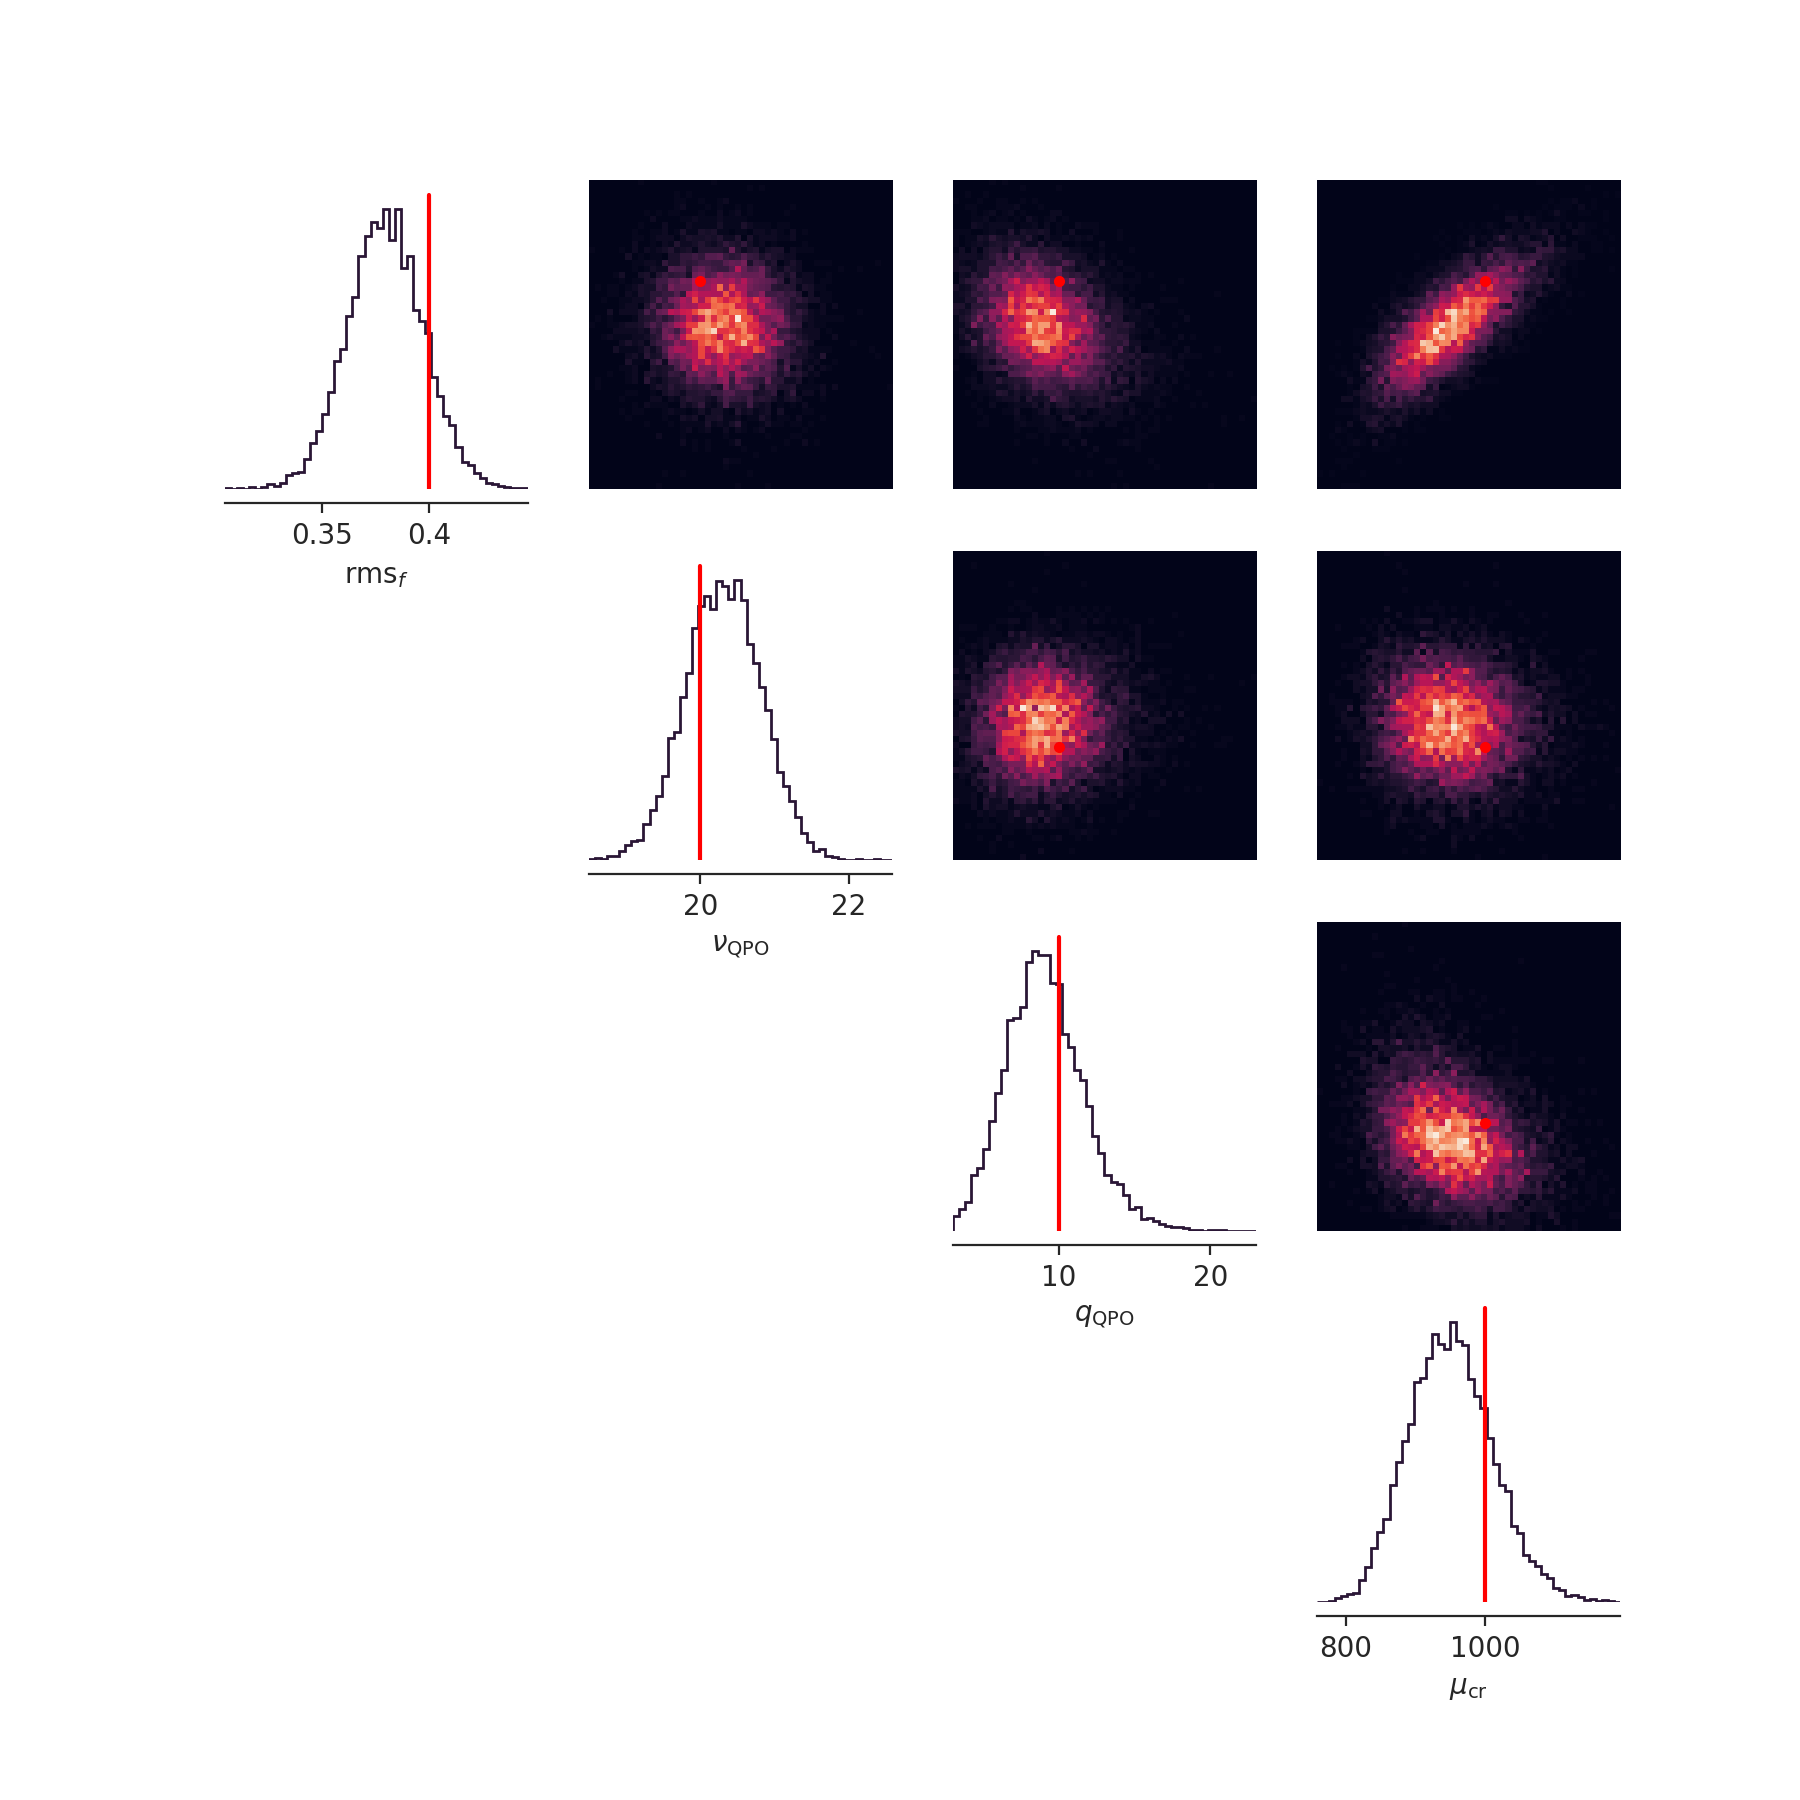

In [50]:

#param_names = [r"$\mathrm{rms}_f$", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{cr}$"]
fig, axes = utils.pairplot(samples_en,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);





What do posterior samples look like?

<IPython.core.display.Javascript object>


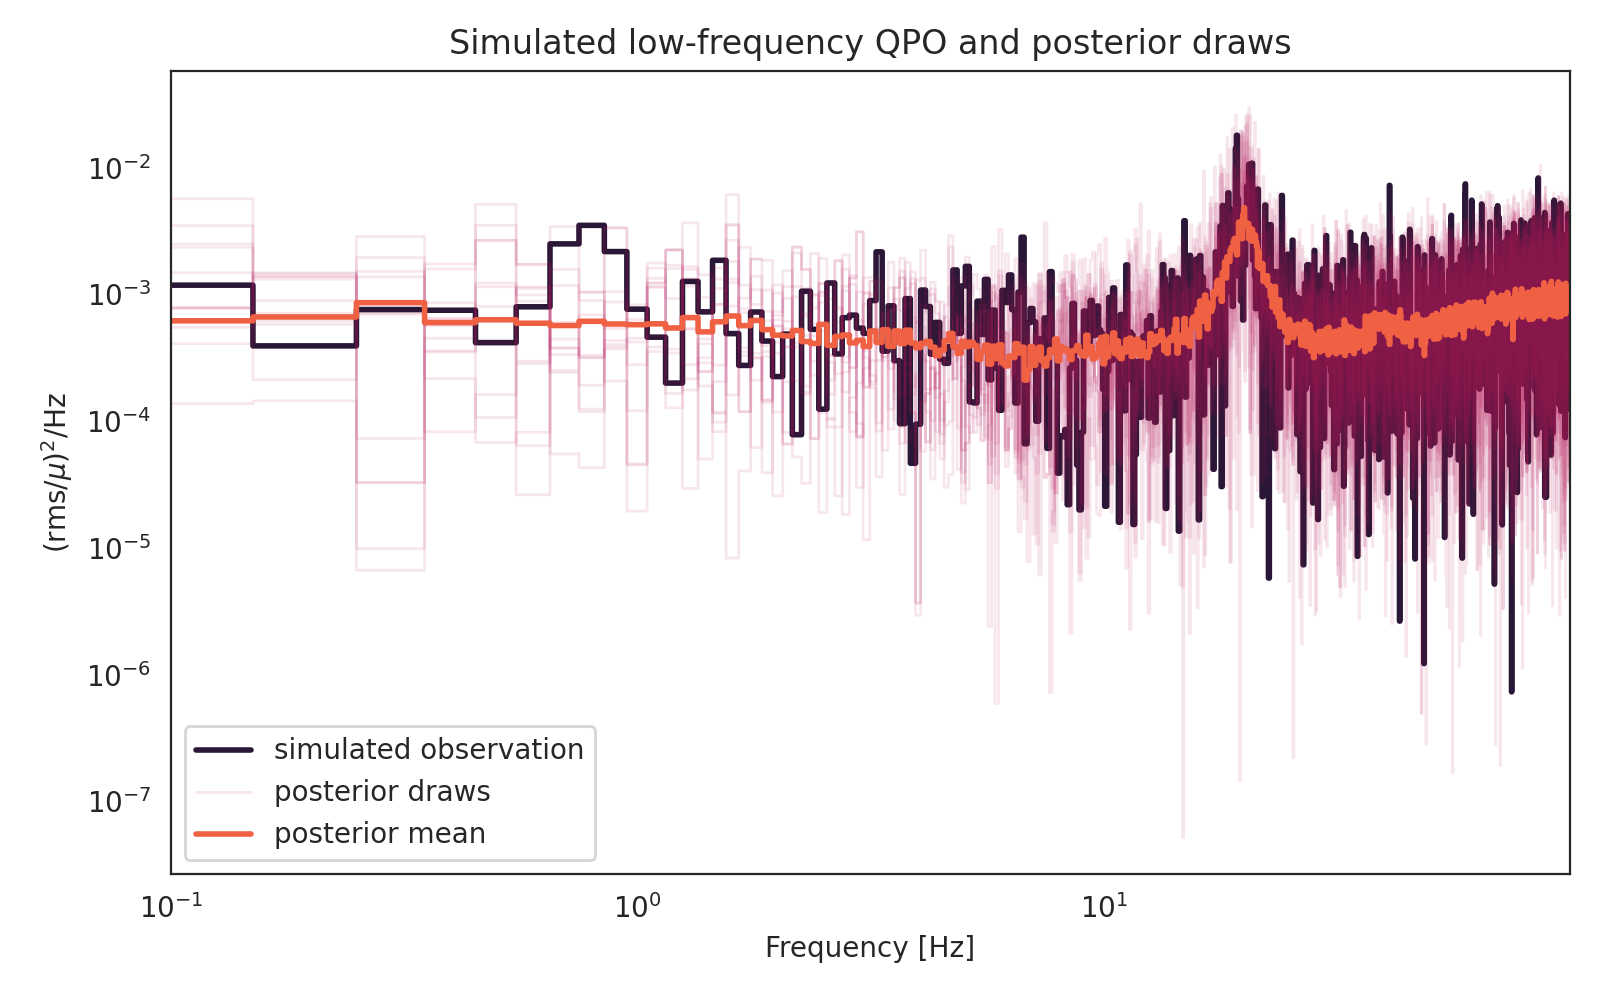

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulated low-frequency QPO and posterior draws'}, xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [51]:
plot_posterior_draws(ps_obs_dt, samples_en, sim_func, savefig=False)

That looks pretty good. Let's take a test data set again:

In [52]:
samples_test_en = posterior_en.sample((10000,), 
                           x=torch.as_tensor(ps_test_dt.power))

<IPython.core.display.Javascript object>


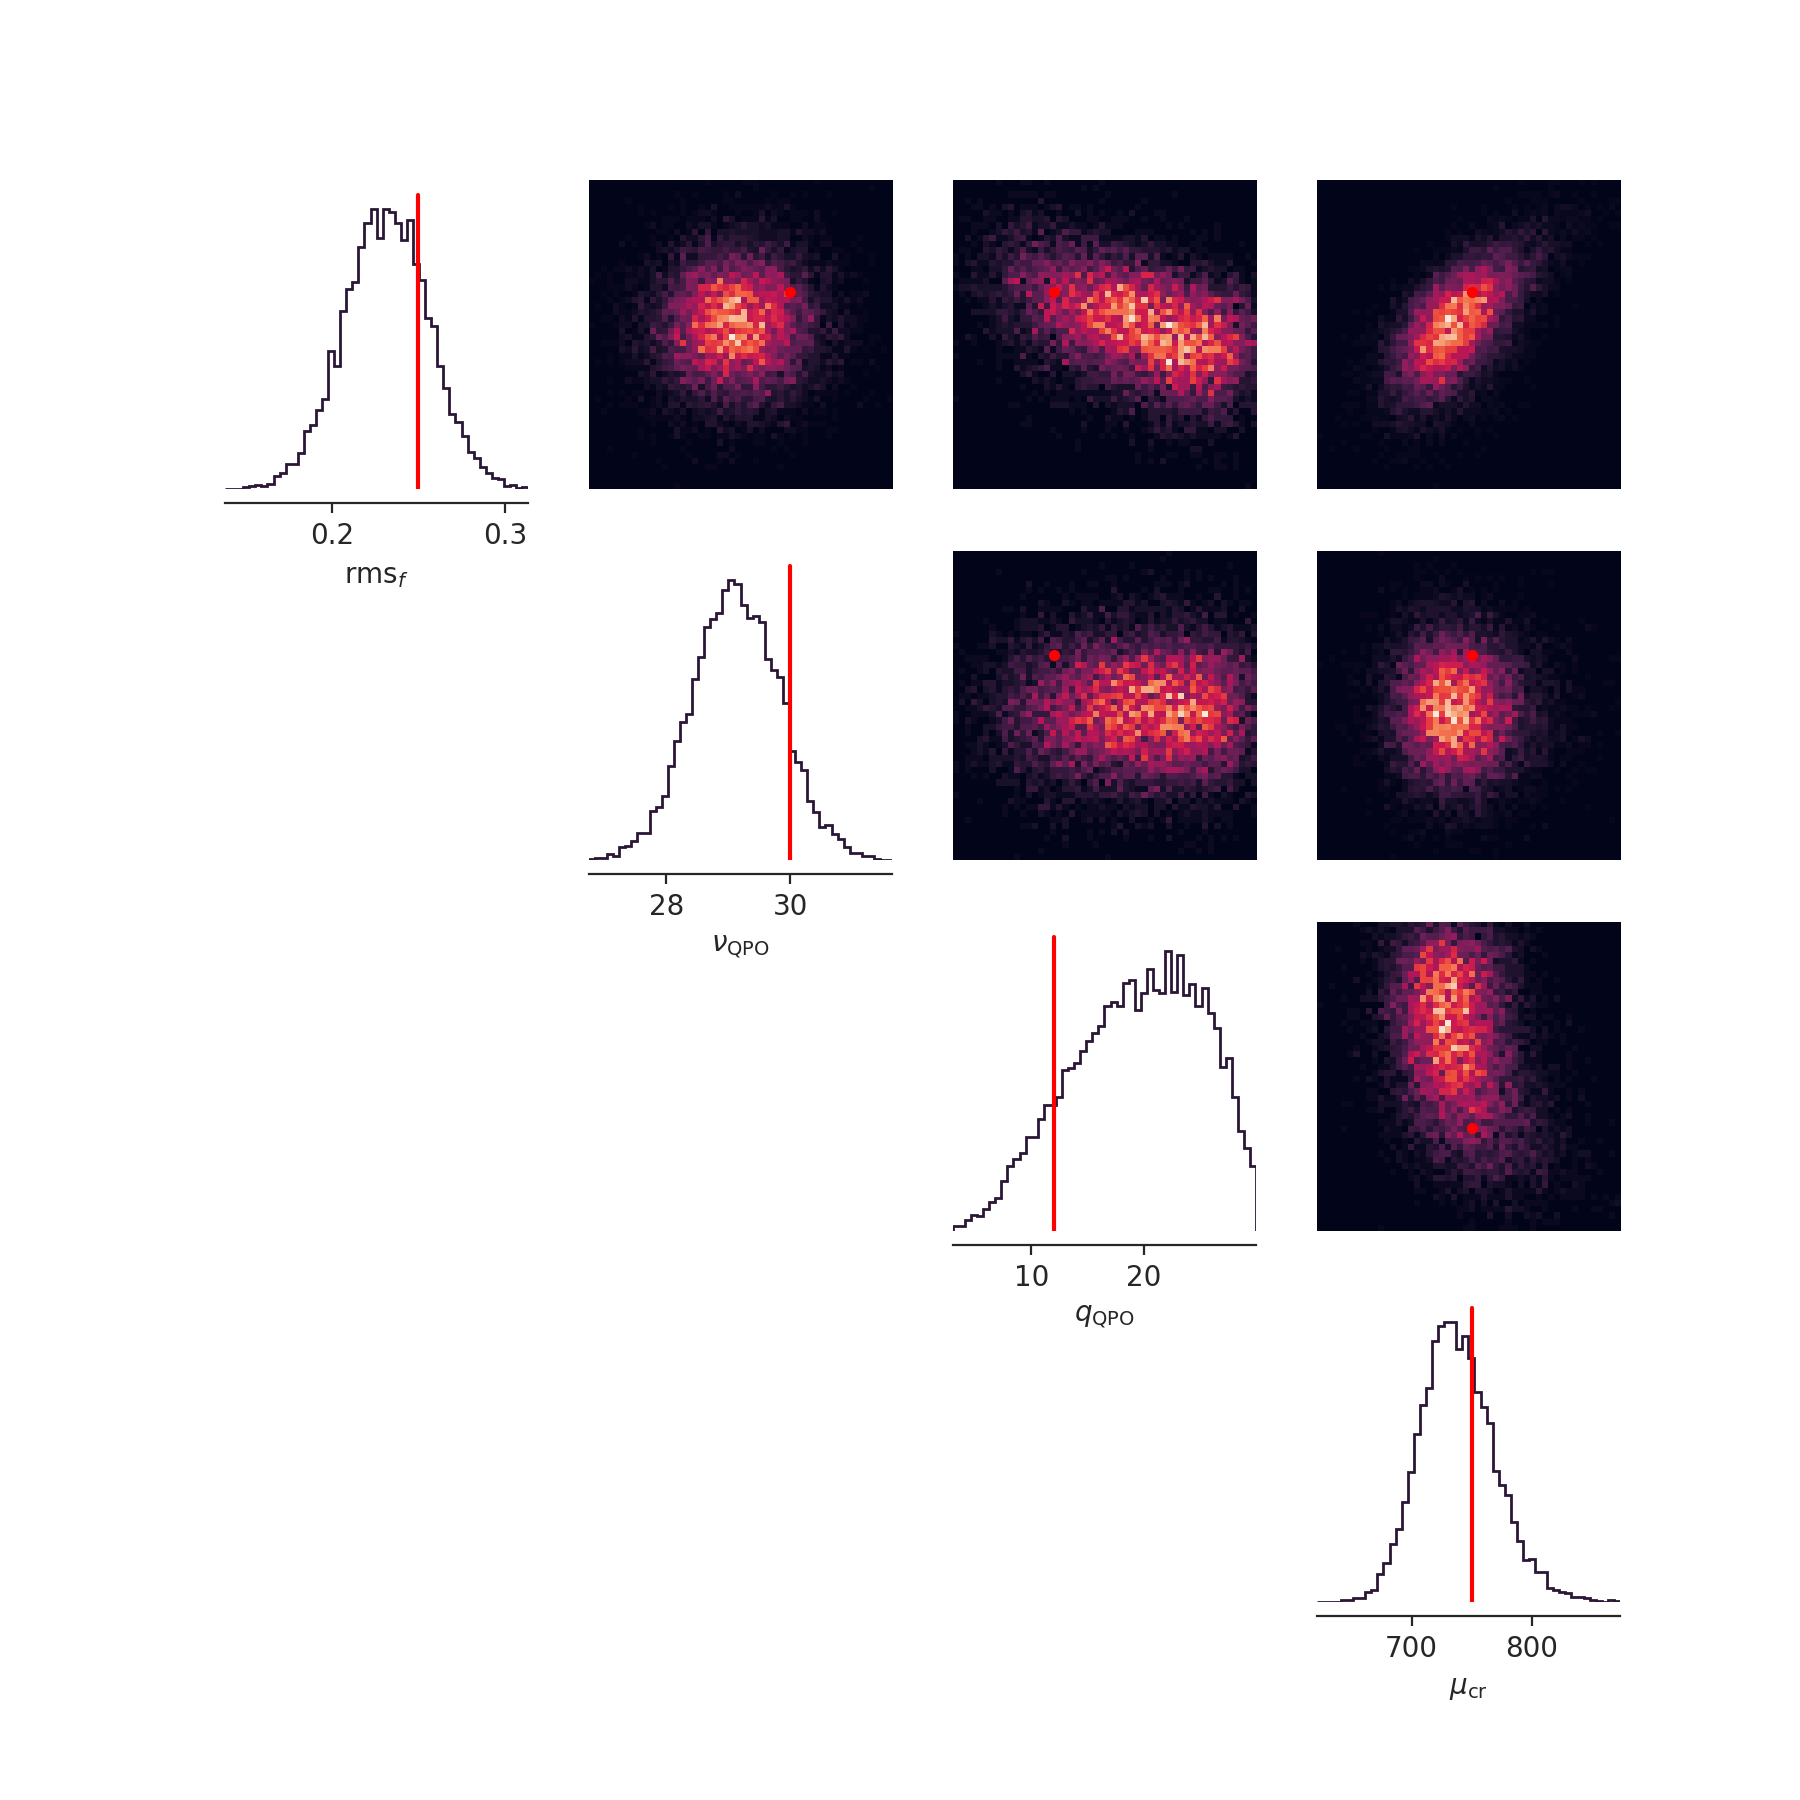

In [53]:
#param_names = [r"$\mathrm{rms}_f$", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{cr}$"]
fig, axes =utils.pairplot(samples_test_en,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_test),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);





Let's plot posterior draws:

<IPython.core.display.Javascript object>


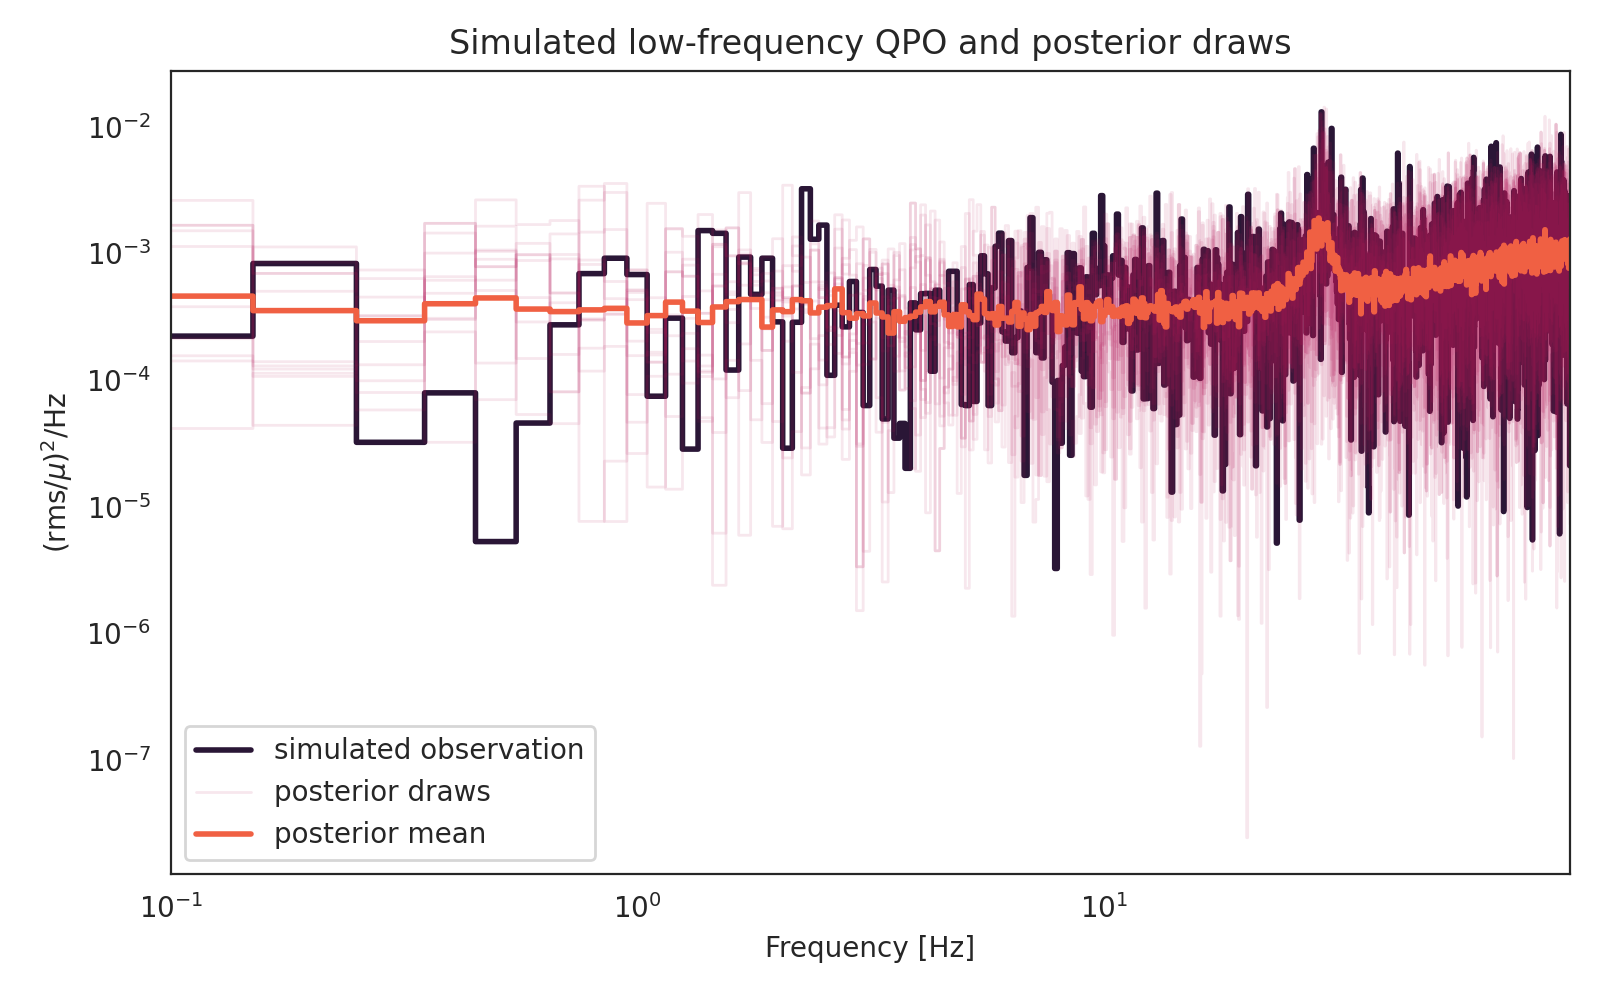

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulated low-frequency QPO and posterior draws'}, xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [136]:
plot_posterior_draws(ps_test_dt, samples_test_en, sim_func, savefig=False)

That looks pretty good. 

## Sequential Inference

I want to try the sequential inference to see whether that manages to get better posteriors faster. The inference will no longer be amortized, but for certain applications, that may not matter.

In [56]:
simulator, prior = prepare_for_sbi(sim_func, prior)
inference_si = SNPE(prior=prior)

# that were sampled from the obtained posterior.
num_rounds = 3

posteriors_si = []
proposal_si = prior

theta0 = theta[:1000]
x0 = x[:1000]
for i in range(num_rounds):
    if i == 0:
        theta_tmp = theta0
        x_tmp = x0
    else:
        theta_tmp, x_tmp = simulate_for_sbi(simulator, proposal_si, num_simulations=1000)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator_si = inference_si.append_simulations(theta_tmp, x_tmp, proposal=proposal_si).train()
    posterior_si = inference_si.build_posterior(density_estimator_si)
    posteriors_si.append(posterior_si)
    proposal_si = posterior_si.set_default_x(ps_obs_dt.power)


Neural network successfully converged after 29 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 72 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 21 epochs.


Let's get a posterior and see how well this worked:

In [57]:
samples_si = posterior_si.sample((10000,), x=ps_obs_dt.power)

<IPython.core.display.Javascript object>


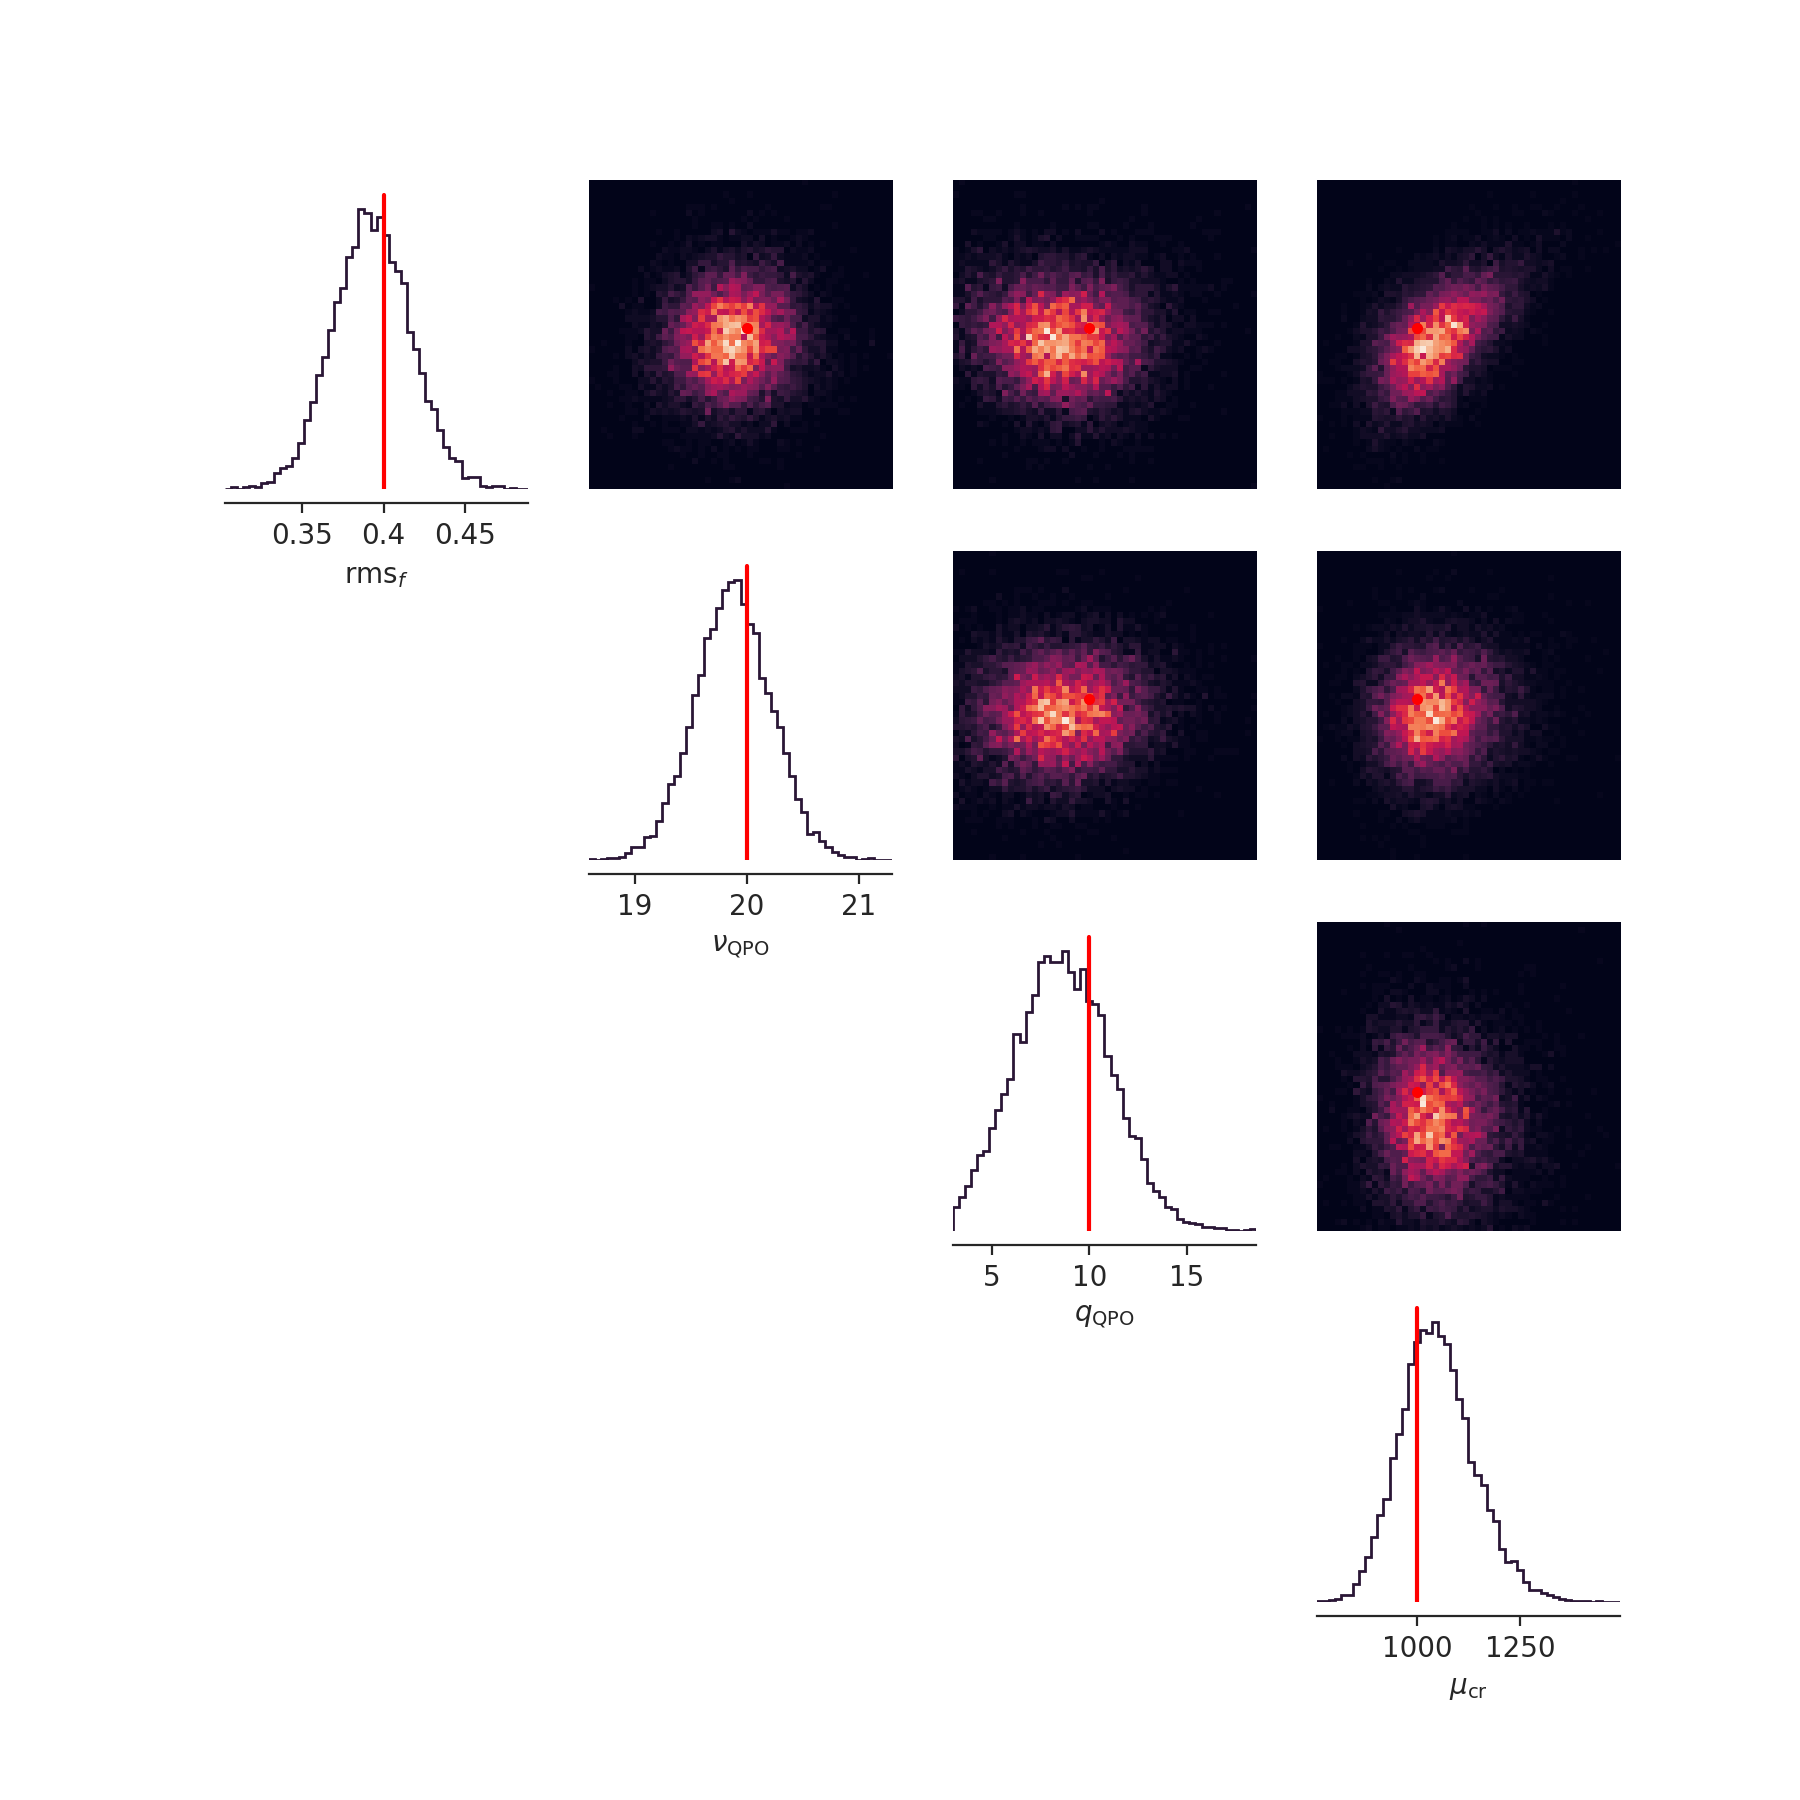

In [58]:
fig, axes =utils.pairplot(samples_si,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);


plt.savefig("../figs/qposim_lf_corner_sequential.pdf", format="pdf")

<IPython.core.display.Javascript object>


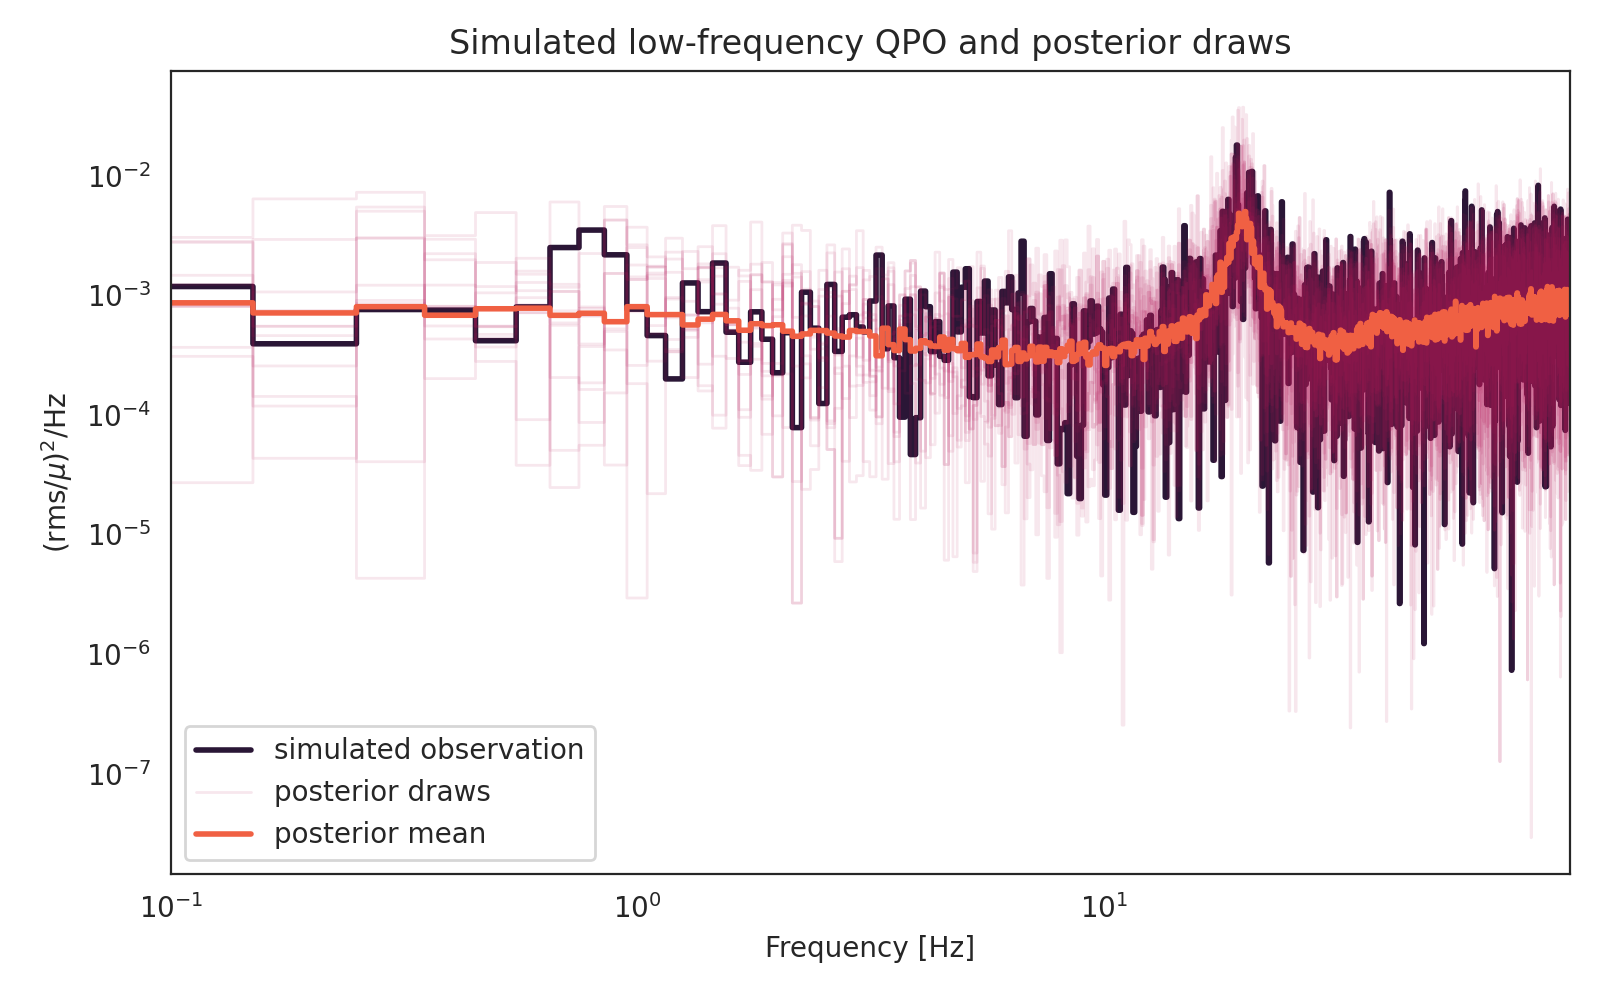

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulated low-frequency QPO and posterior draws'}, xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [59]:
plot_posterior_draws(ps_obs_dt, samples_si, sim_func, savefig=True, filename="../figs/qposim_lf_post_draws_sequential.pdf")

Comparing the three different posteriors:

In [61]:
samples[:,0]

array([0.42032087, 0.38921824, 0.3891451 , ..., 0.38719714, 0.37112096,
       0.41529185], dtype=float32)

In [64]:
len(s_en)

10000

In [66]:
param_names

['$\\mathrm{rms}_f$',
 '$\\nu_\\mathrm{QPO}$',
 '$q_\\mathrm{QPO}$',
 '$\\mu_\\mathrm{cr}$']

<IPython.core.display.Javascript object>


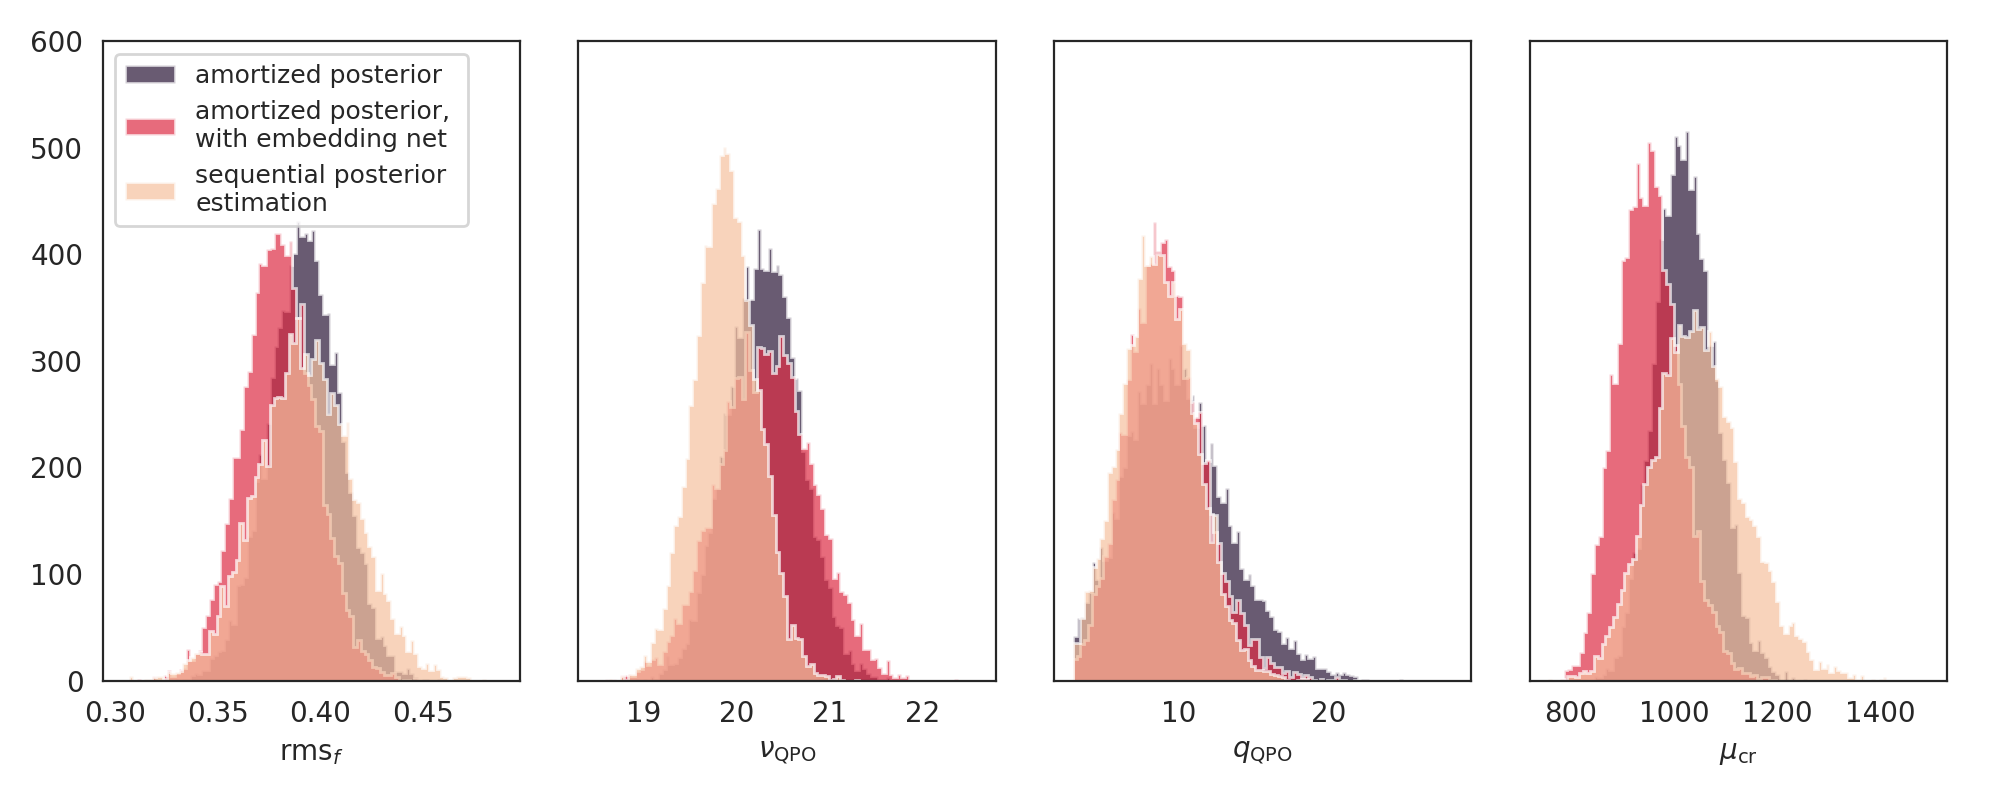

In [101]:
fig, axes = plt.subplots(1, 4, figsize=(10,4), sharey=True)

b = 100
a = 0.7

c1 = pal[0]
c2 = pal[4]
c3 = pal[7]
ht = "stepfilled"

for i in range(4):
    s = np.array(samples[:,i])
    s_en = np.array(samples_en[:,i])
    s_si = np.array(samples_si[:,i])
    
    par_range = [np.min(np.hstack([s,s_en, s_si])),
                 np.max(np.hstack([s, s_en, s_si]))]
    axes[i].hist(s, bins=b, alpha=a, color=c1, range=par_range, 
                 histtype=ht, label="amortized posterior")
    axes[i].hist(s_en, bins=b, alpha=a, color=c2, range=par_range, 
                 histtype=ht, label="amortized posterior, \nwith embedding net")
    axes[i].hist(s_si, bins=b, alpha=a, color=c3, range=par_range, 
                 histtype=ht, label="sequential posterior \nestimation")
    
    axes[i].set_xlabel(param_names[i])

axes[0].legend(prop={'size': 9}, loc="upper left")
axes[-1].set_ylim(0,600)
plt.tight_layout()
plt.savefig("../figs/qposim_lf_post_comparison.pdf", format="pdf")

## Comparison to traditional MCMC

For this, we can't do neither FAD (it's not an averaged periodogram), nor can we do MCMC (we don't have a likelihood for the cospectrum). But let's do MCMC on the periodogram without taking dead time into account, just for comparison:

In [85]:
from stingray.modeling import PSDPosterior, PSDParEst

In [86]:
qpo_model = models.Lorentz1D() + models.Const1D()

qpo_amp = 1.0
qpo_x0 = 20.0
qpo_fwhm = 2.0

qpo_model.amplitude = qpo_amp
qpo_model.x_0 = qpo_x0
qpo_model.fwhm = qpo_fwhm

amp_prior = scipy.stats.uniform(1e-10, 100).pdf
x0_prior = scipy.stats.uniform(5, 50).pdf
fwhm_prior = scipy.stats.uniform(0.01, 40).pdf

wn_prior = scipy.stats.uniform(1e-20, 1e5).pdf

priors = {"amplitude_0": amp_prior,
          "x_0_0": x0_prior,
          "fwhm_0": fwhm_prior,
          "amplitude_1": wn_prior}




In [90]:
lpost = PSDPosterior(ps_obs_dt.freq, ps_obs_dt.power, qpo_model, priors=priors)

parest = PSDParEst(ps_obs_dt, fitmethod="bfgs")

res = parest.fit(lpost, [0.01, 20, 5, 0.001])

print(res.p_opt)

[6.16880737e-03 1.99549158e+01 1.44584525e+00 9.23849347e-04]


In [91]:
lpost(res.p_opt)

5879.000210616618

In [92]:
test_particles = np.random.multivariate_normal(res.p_opt, np.diag(res.p_opt/5)**2., size=1000)

Let's do MCMC:

In [93]:
nwalkers = 100
burnin = 200
niter = 300

samp_mcmc = parest.sample(lpost, res.p_opt, cov=np.diag(res.p_opt/5)**2., 
                             nwalkers=nwalkers, burnin=burnin, niter=niter)

-- The acceptance fraction is: 0.546933.5
INFO:MCMC summary:-- The acceptance fraction is: 0.546933.5
R_hat for the parameters is: [1.54826858e-05 2.20703917e+00 1.32902396e-01 1.16406478e-09]
INFO:MCMC summary:R_hat for the parameters is: [1.54826858e-05 2.20703917e+00 1.32902396e-01 1.16406478e-09]
-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO:MCMC summary:---------------------------------------------

theta[0] 	 0.007966604480976022	0.003935807322848824	0.003873330135327459	0.01522777687053861

INFO:MCMC summary:theta[0] 	 0.007966604480976022	0.003935807322848824	0.003873330135327459	0.01522777687053861

theta[1] 	 19.805575223921423	1.4783582240570154	19.56241631638164	20.325009250474363

INFO:MCMC summary:theta[1] 	 19.805575223921423	1.4783582240570154	19.56241631638164	20.325009250474363

Let's plot some draws from the posterior:

In [102]:
from astropy.modeling.fitting import _fitter_to_model_params

In [103]:
nsim = 100

idx = np.random.choice(np.arange(0, samp_mcmc.samples.shape[0], 1, dtype=int), replace=False, size=nsim)

sims_all = []

for i,j in enumerate(idx):

    param_sim = samp_mcmc.samples[j,:]
    _fitter_to_model_params(qpo_model, param_sim)
    ps_sim = np.array(qpo_model(ps_obs_dt.freq))
    sims_all.append(ps_sim)

<IPython.core.display.Javascript object>


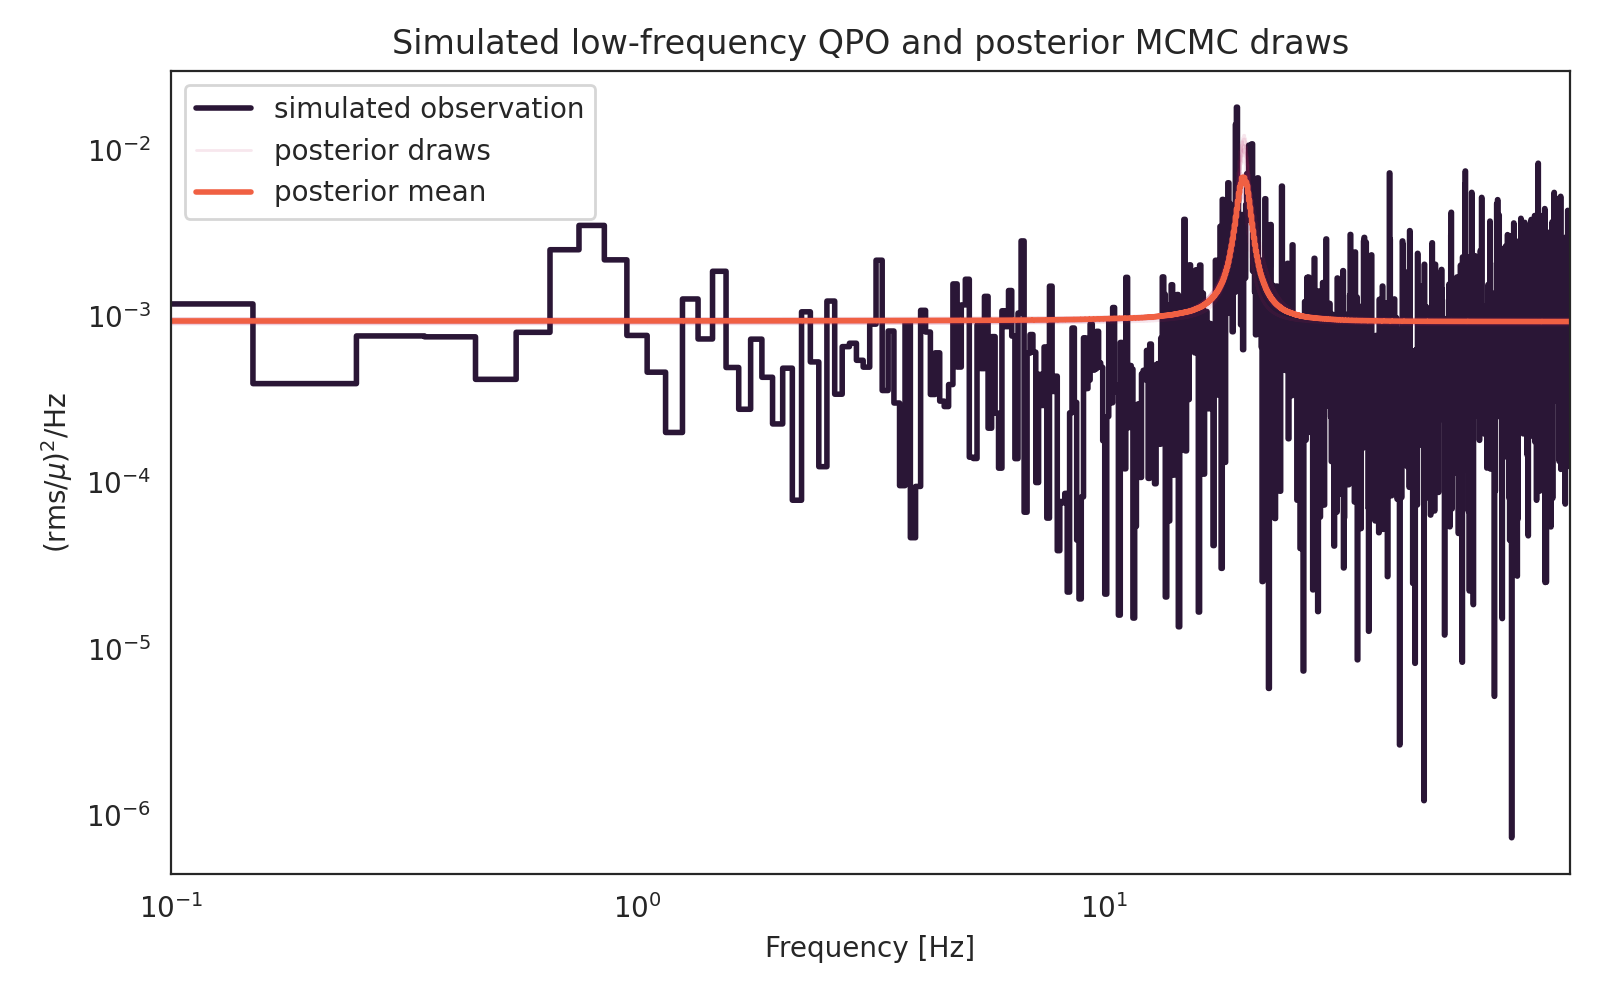

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid", label="simulated observation");

# plot simulations

for i, ps_sim in enumerate(sims_all):
    if i == 0:
        ax.loglog(ps_test_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid', label="posterior draws")


    if i % 10 == 0:
        ax.loglog(ps_test_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid')


sims_all = np.array(sims_all)
ps_sim_mean = np.median(sims_all, axis=0)  
ax.loglog(ps_test_dt.freq, ps_sim_mean, lw=2, c=pal[5], ds="steps-mid", label="posterior mean")
ax.set_xlim(ps_test_dt.freq[0], ps_test_dt.freq[-1])
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$(\mathrm{rms}/\mu)^2/\mathrm{Hz}$")
ax.set_title("Simulated low-frequency QPO and posterior MCMC draws")
plt.tight_layout()
plt.savefig("../figs/qposim_lf_mcmc_draws.pdf", format="pdf")

Okay, let's also make a corner plot:

<IPython.core.display.Javascript object>


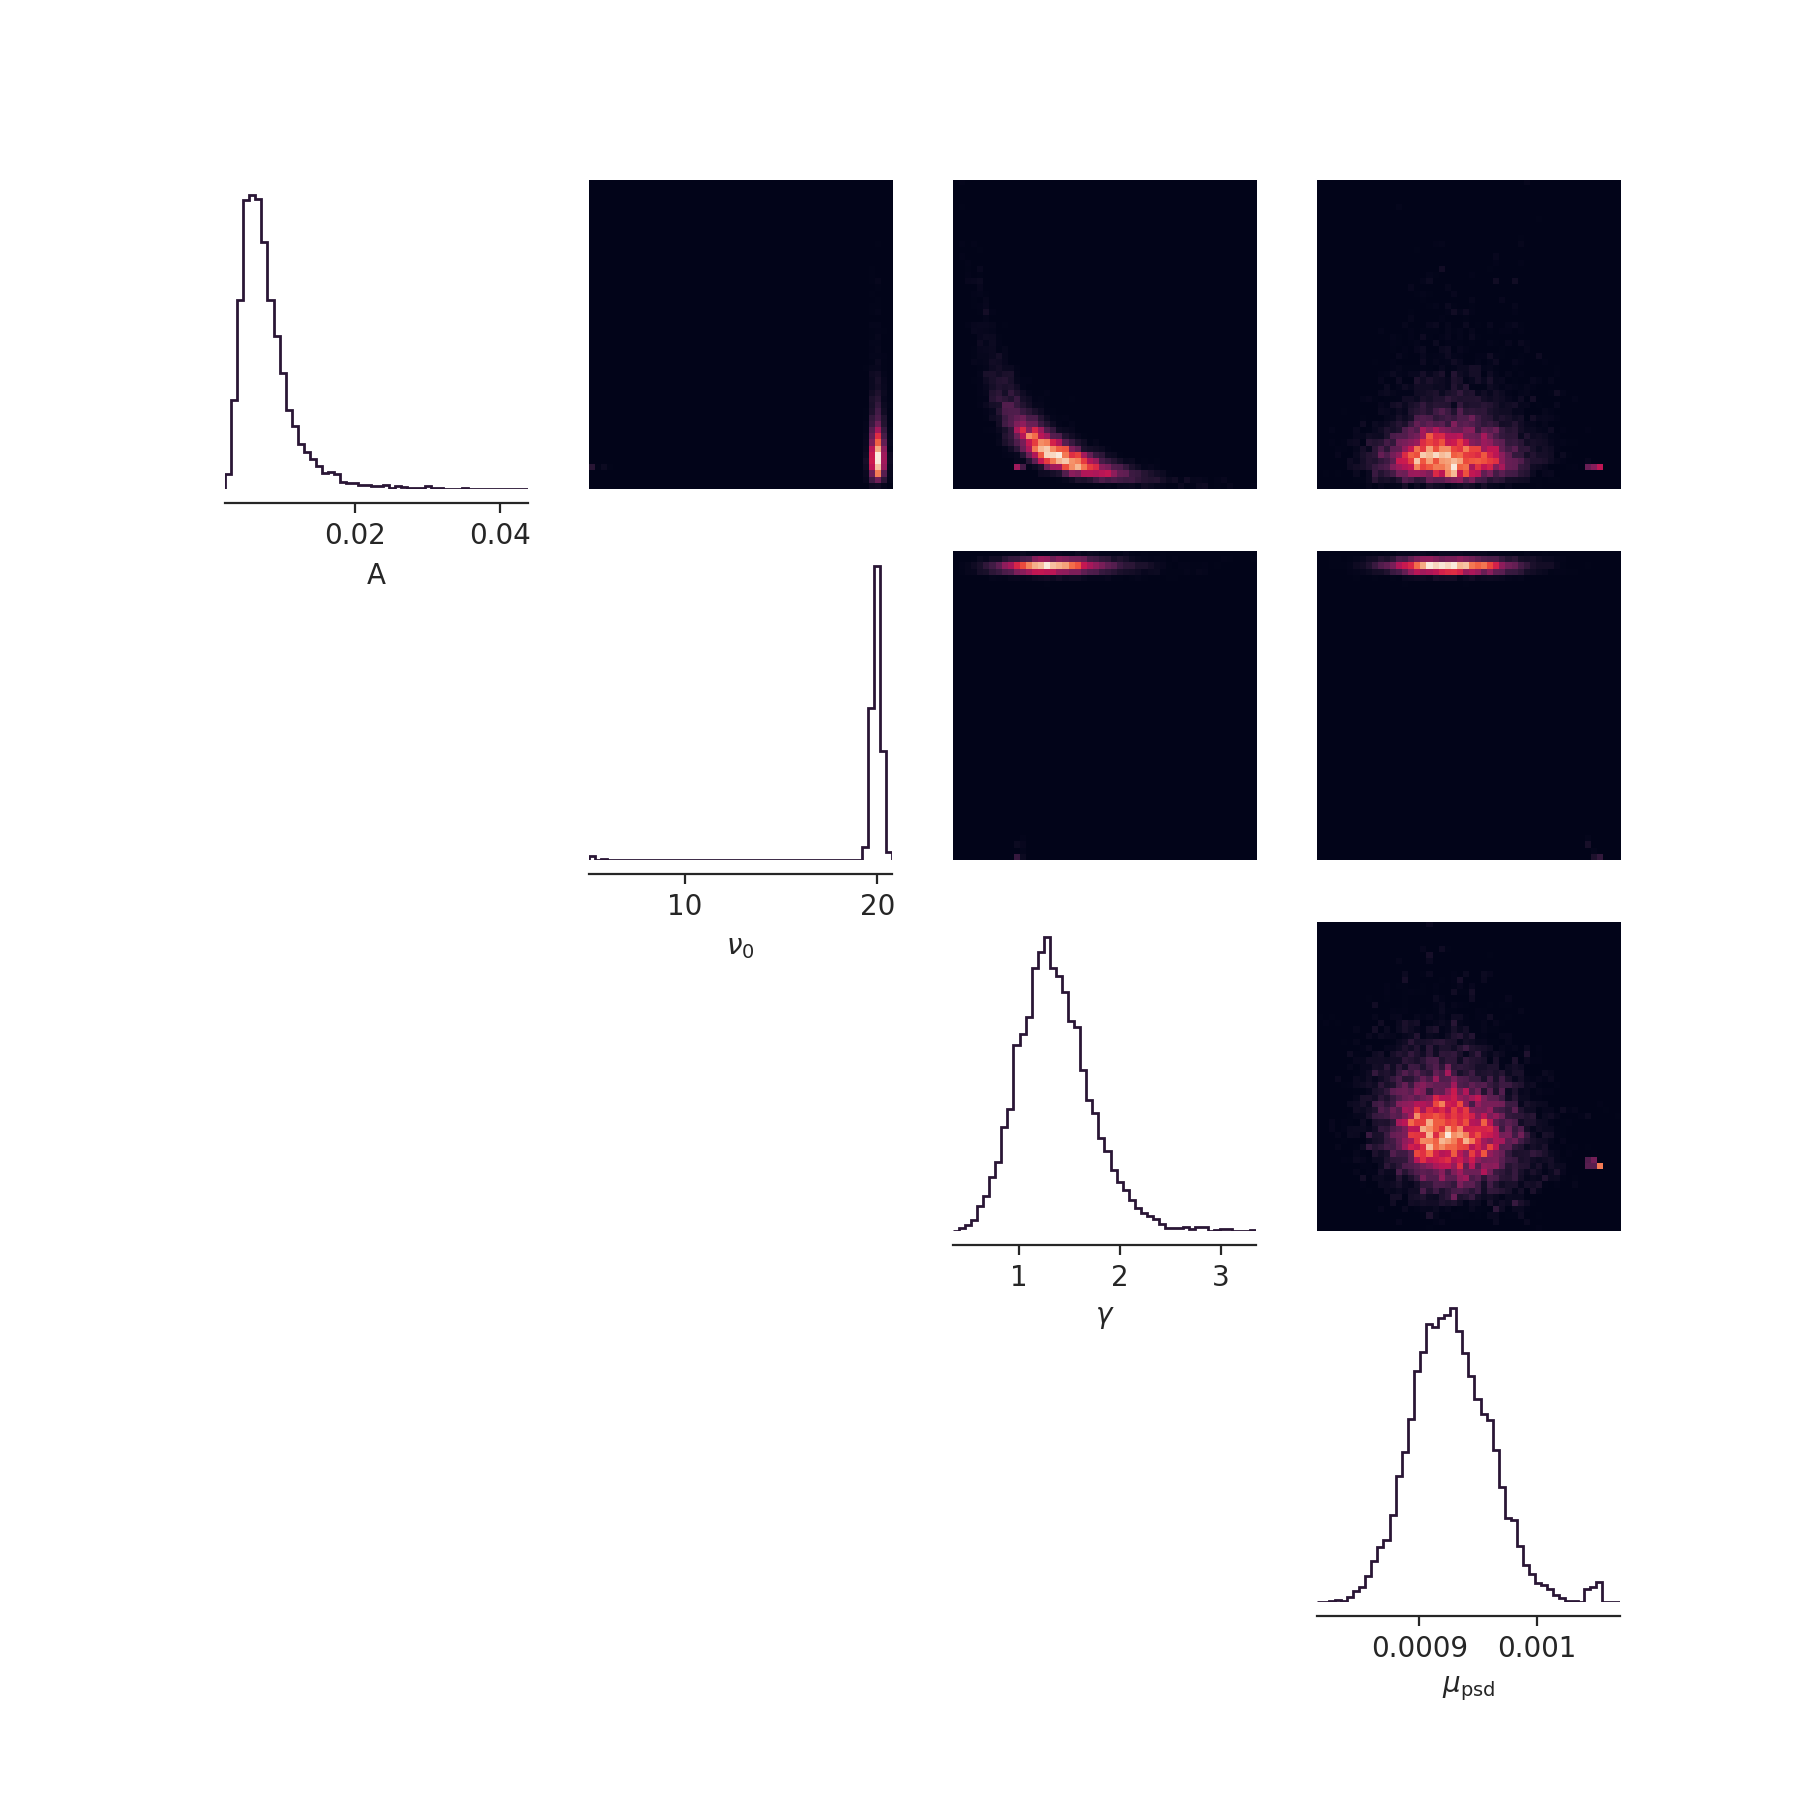

In [105]:
labels = ["A", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{psd}$"]

fig, axes = utils.pairplot(samp_mcmc.samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           labels=labels)
                           #points=np.array(param_obs),
                           #points_offdiag={'markersize': 6},
                           #points_colors='r');




Let's compute the fractional rms amplitude of the QPO and compare that to the SBI estimate:

In [106]:
rms_dt = np.array([np.sqrt(np.sum(lorentzian(ps_obs_dt.freq, *s[:-1])*ps_obs_dt.df)) for s in samp_mcmc.samples[-5000:,:]])

In [107]:
samples.shape

(10000, 4)

<IPython.core.display.Javascript object>


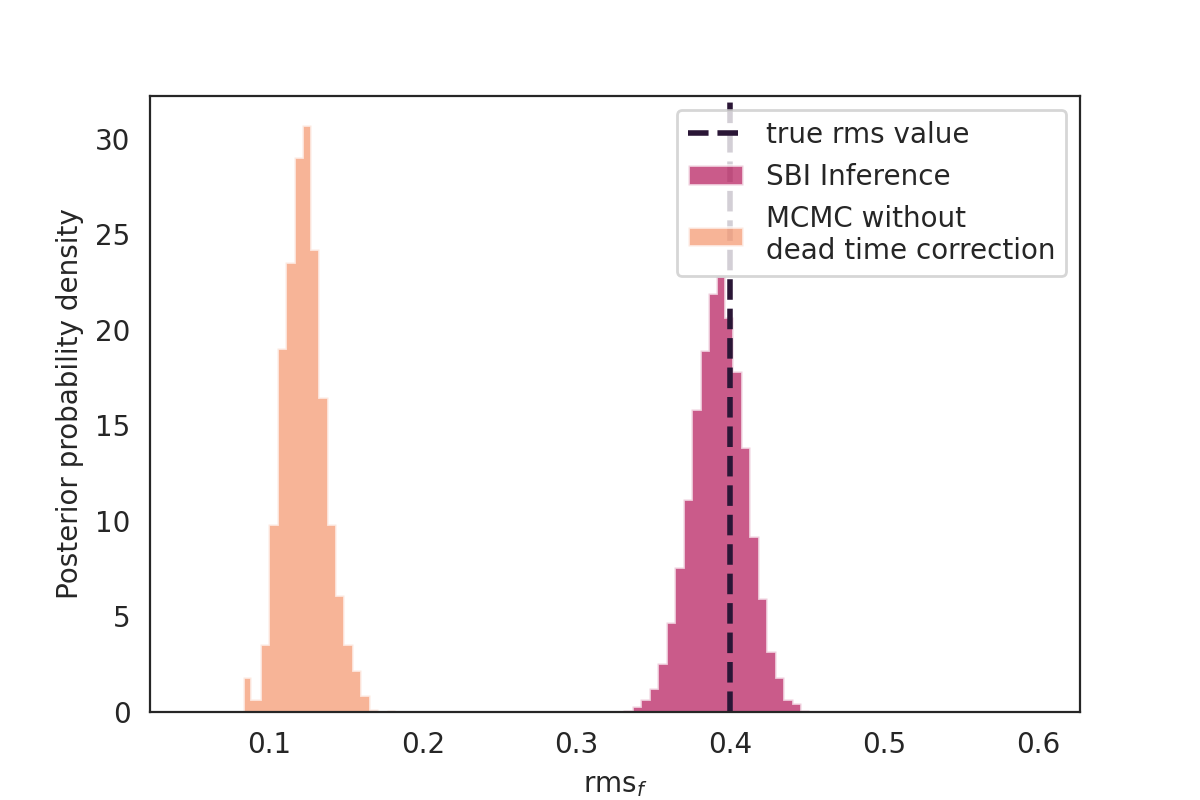

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

xrange = [0.05, 0.6]

ax.hist(np.array(samples[:,0]), bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="SBI Inference", color=pal[3])
ax.hist(rms_dt, bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="MCMC without \ndead time correction",
        color=pal[6])

ax.axvline(param_obs[0], lw=2, c=pal[0], ls="dashed", label="true rms value")

ax.legend(loc="upper right")

ax.set_xlabel(r"$\mathrm{rms}_f$")
ax.set_ylabel("Posterior probability density")
plt.savefig("../figs/qposim_lf_rms_comp.pdf", format="pdf")

I think this is a plot I want to have in the paper!

## High-Frequency QPO

At higher frequencies, dead time often has a worse effect, so let's redo the same analysis but for a high-frequency QPO:

In [24]:
np.random.seed(20201207)

qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 200.0 # centroid frequency of the QPO, in Hz
qpo_qual = 15.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.45 # fractional RMS amplitude of the QPO

tseg = 10.0 # total duration in seconds
dt_nustar = 1e-5 # time resolution of NuSTAR
dt = 0.5/750.0 # time step of the output light curve
npoints = int(np.round(tseg/dt_nustar)) # total number of points in original light curve

mean_countrate_obs = 1000
mean_counts_nustar_obs = mean_countrate_obs * dt_nustar

df_nustar = 1.0/tseg # frequency resolution of the PSD/CSD
fmax_nustar = 0.5/dt_nustar # maximum frequency in the CSD/PSD

# dead time for nustar
deadtime_nustar = 0.0025

# list of frequencies
freq = np.linspace(df_nustar, fmax_nustar, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

# store parameters in a list for easy (plotting) access
param_obs = [rms_obs, qpo_x0, qpo_qual, mean_countrate_obs]

# generate some ligth curves, both with (*_dt) and without dead time
lc1_obs, lc2_obs, lc1_obs_dt, lc2_obs_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)

In [25]:
lc_obs = lc1_obs + lc2_obs
lc_obs_dt = lc1_obs_dt + lc2_obs_dt

ps_obs = Powerspectrum(lc_obs, norm="frac")
ps_obs_dt = Powerspectrum(lc_obs_dt, norm="frac")

cs_obs = Crossspectrum(lc1_obs, lc2_obs, norm="frac")
cs_obs_dt = Crossspectrum(lc1_obs_dt, lc2_obs_dt, norm="frac")

<IPython.core.display.Javascript object>


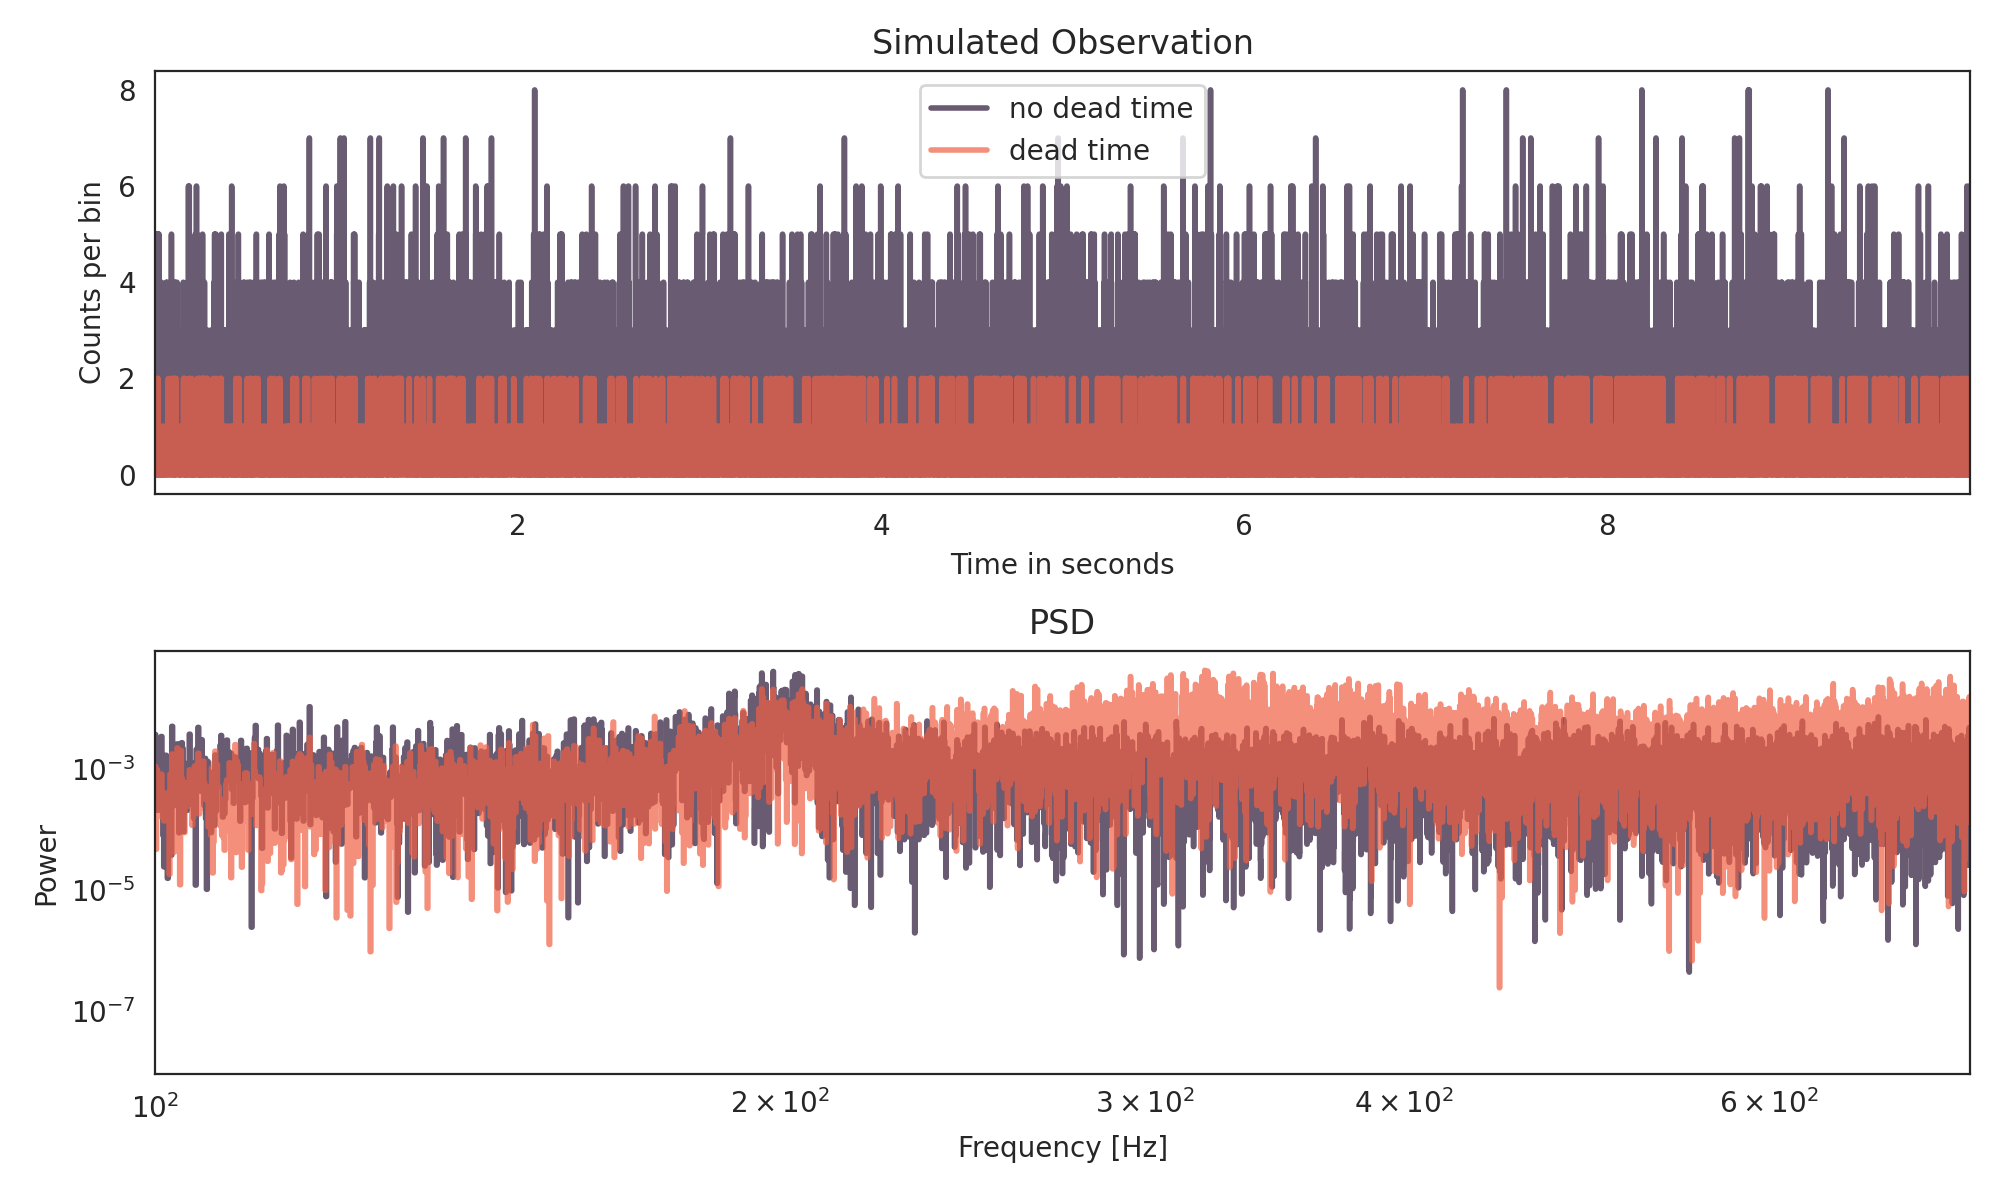

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]

a = 0.7

ax1.plot(lc_obs.time, lc_obs.counts, ds="steps-mid", lw=2, 
         label="no dead time", c=c1, alpha=a)
ax1.plot(lc_obs_dt.time, lc_obs_dt.counts, ds="steps-mid", lw=2, 
         label="dead time", c=c2, alpha=a)
ax1.set_xlabel("Time in seconds")
ax1.set_ylabel("Counts per bin")
ax1.set_title("Simulated Observation")
ax1.set_xlim(lc_obs.time[0], lc_obs.time[-1])

ps_obs_logbin = ps_obs.rebin_log()
ps_obs_dt_logbin = ps_obs_dt.rebin_log()

ax2.loglog(ps_obs.freq, ps_obs.power, lw=2, ds="steps-mid", 
           label="no dead time", c=c1, alpha=a)
ax2.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, ds="steps-mid", 
           label="dead time", c=c2, alpha=a)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power")
ax2.set_title("PSD")
ax2.set_xlim(100, ps_obs.freq[-1])


cs_obs_logbin = cs_obs.rebin_log()
cs_obs_dt_logbin = cs_obs_dt.rebin_log()


#ax3.loglog(cs_obs_logbin.freq, cs_obs_logbin.power, lw=2, ds="steps-mid", 
#           label="no dead time", c=c1, alpha=a)
#ax3.loglog(cs_obs_dt_logbin.freq, cs_obs_dt_logbin.power, lw=2, ds="steps-mid", 
#           label="dead time", c=c2, alpha=a)
#ax3.set_xlabel("Frequency [Hz]")
#ax3.set_ylabel("Power")
#ax3.set_title("CSD")
#ax3.set_xlim(cs_obs.freq[0], cs_obs.freq[-1])

ax1.legend()

plt.tight_layout()

plt.savefig("../figs/qpo_hf_sim.pdf", format="pdf")

Now we can set up our simulation-based inference. First, we need a function that takes a set of parameters as input, and then returns some form of data we want to compare, in our case the periodogram powers directly:

### Log-Binned Periodogram

Because there are more bins to search at high frequencies, let's log-bin the periodogram to see what that does:

In [27]:
f = 0.01
ps_log_dt = ps_obs_dt.rebin_log(f)
ps_log = ps_obs.rebin_log(f)

<IPython.core.display.Javascript object>


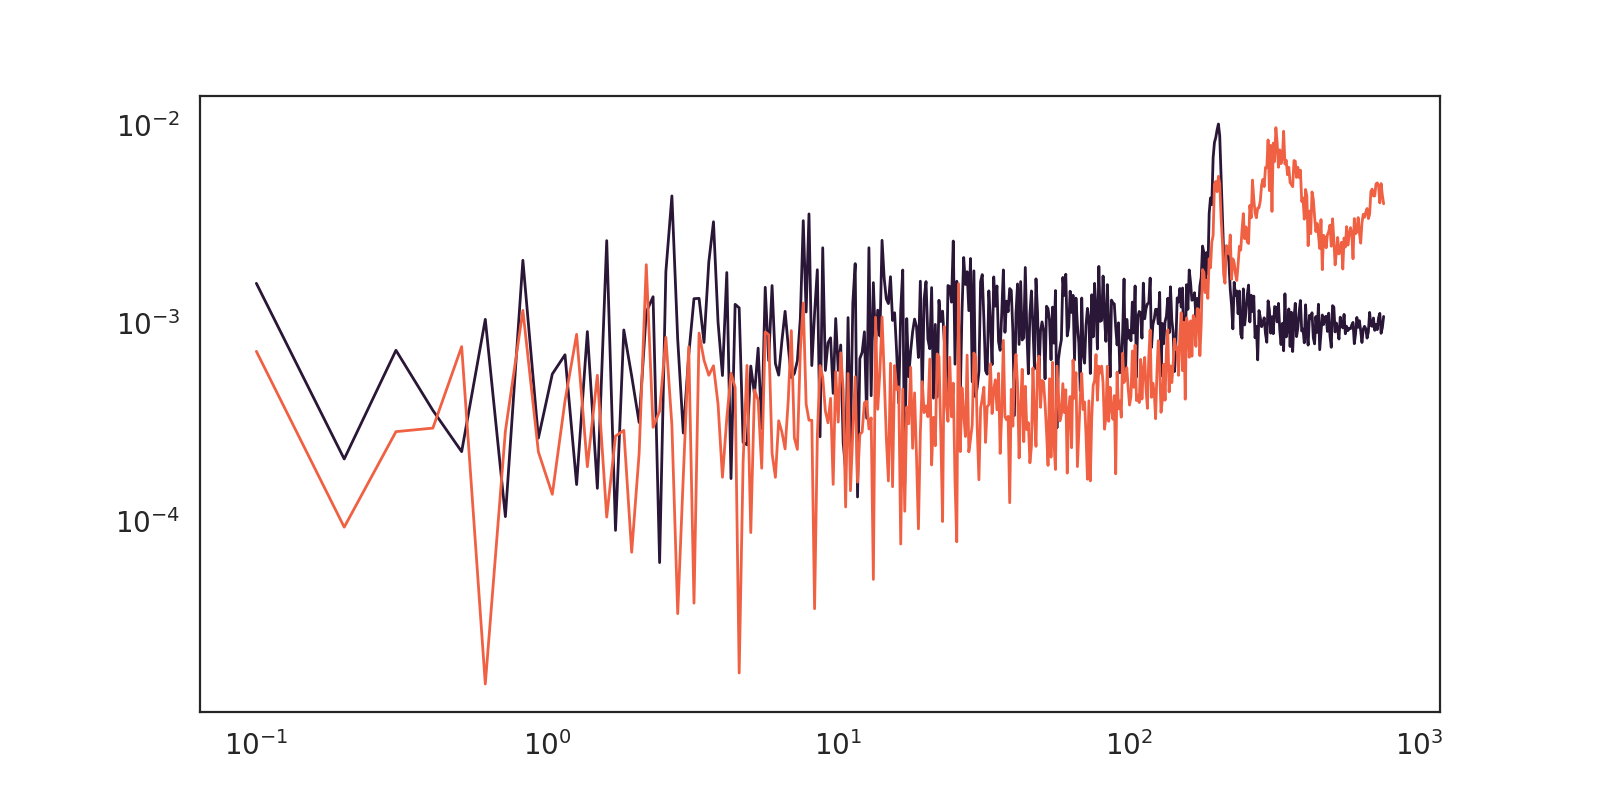

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]


ax.loglog(ps_log.freq, ps_log.power, lw=1, c=c1, label='without dead time')
ax.loglog(ps_log_dt.freq, ps_log_dt.power, lw=1, c=c2, label="with dead time")

In [31]:
lower_bounds = torch.tensor([0.1, 100.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 300.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )

Okay, let's see if we can actually run the neural network emulation. Here's a dictionary with the keyword argument for the simulator:

In [30]:
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.5/750.0, "deadtime":0.0025, 
                     "summary_type":"logbin", "f":f}

Let's first do a run on the raw log-binned periodogram. We have some simulations we can load and use:

In [32]:
theta = torch.FloatTensor([])
x = torch.FloatTensor([])

for i in range(10):
    theta0 = torch.FloatTensor(np.loadtxt("../code/sim_hf_psd_embed_theta%i.dat"%i))
    x0 = torch.FloatTensor(np.loadtxt("../code/sim_hf_psd_embed_x%i.dat"%i))
    
    theta = torch.hstack([theta.T, theta0.T]).T
    x = torch.hstack([x.T, x0.T]).T
    

In [33]:
theta.shape

torch.Size([50000, 4])

Now we can set up our SBI:

In [34]:
sim_func = generate_simulator_function(**simulation_kwargs)
simulator, prior = prepare_for_sbi(sim_func, prior)
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta[:20000], x[:20000])
density_estimator = inference.train()

Neural network successfully converged after 34 epochs.


In [35]:
posterior = inference.build_posterior(density_estimator)
samples = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_log_dt.power))

In [36]:
param_obs

[0.45, 200.0, 15.0, 1000]

<IPython.core.display.Javascript object>


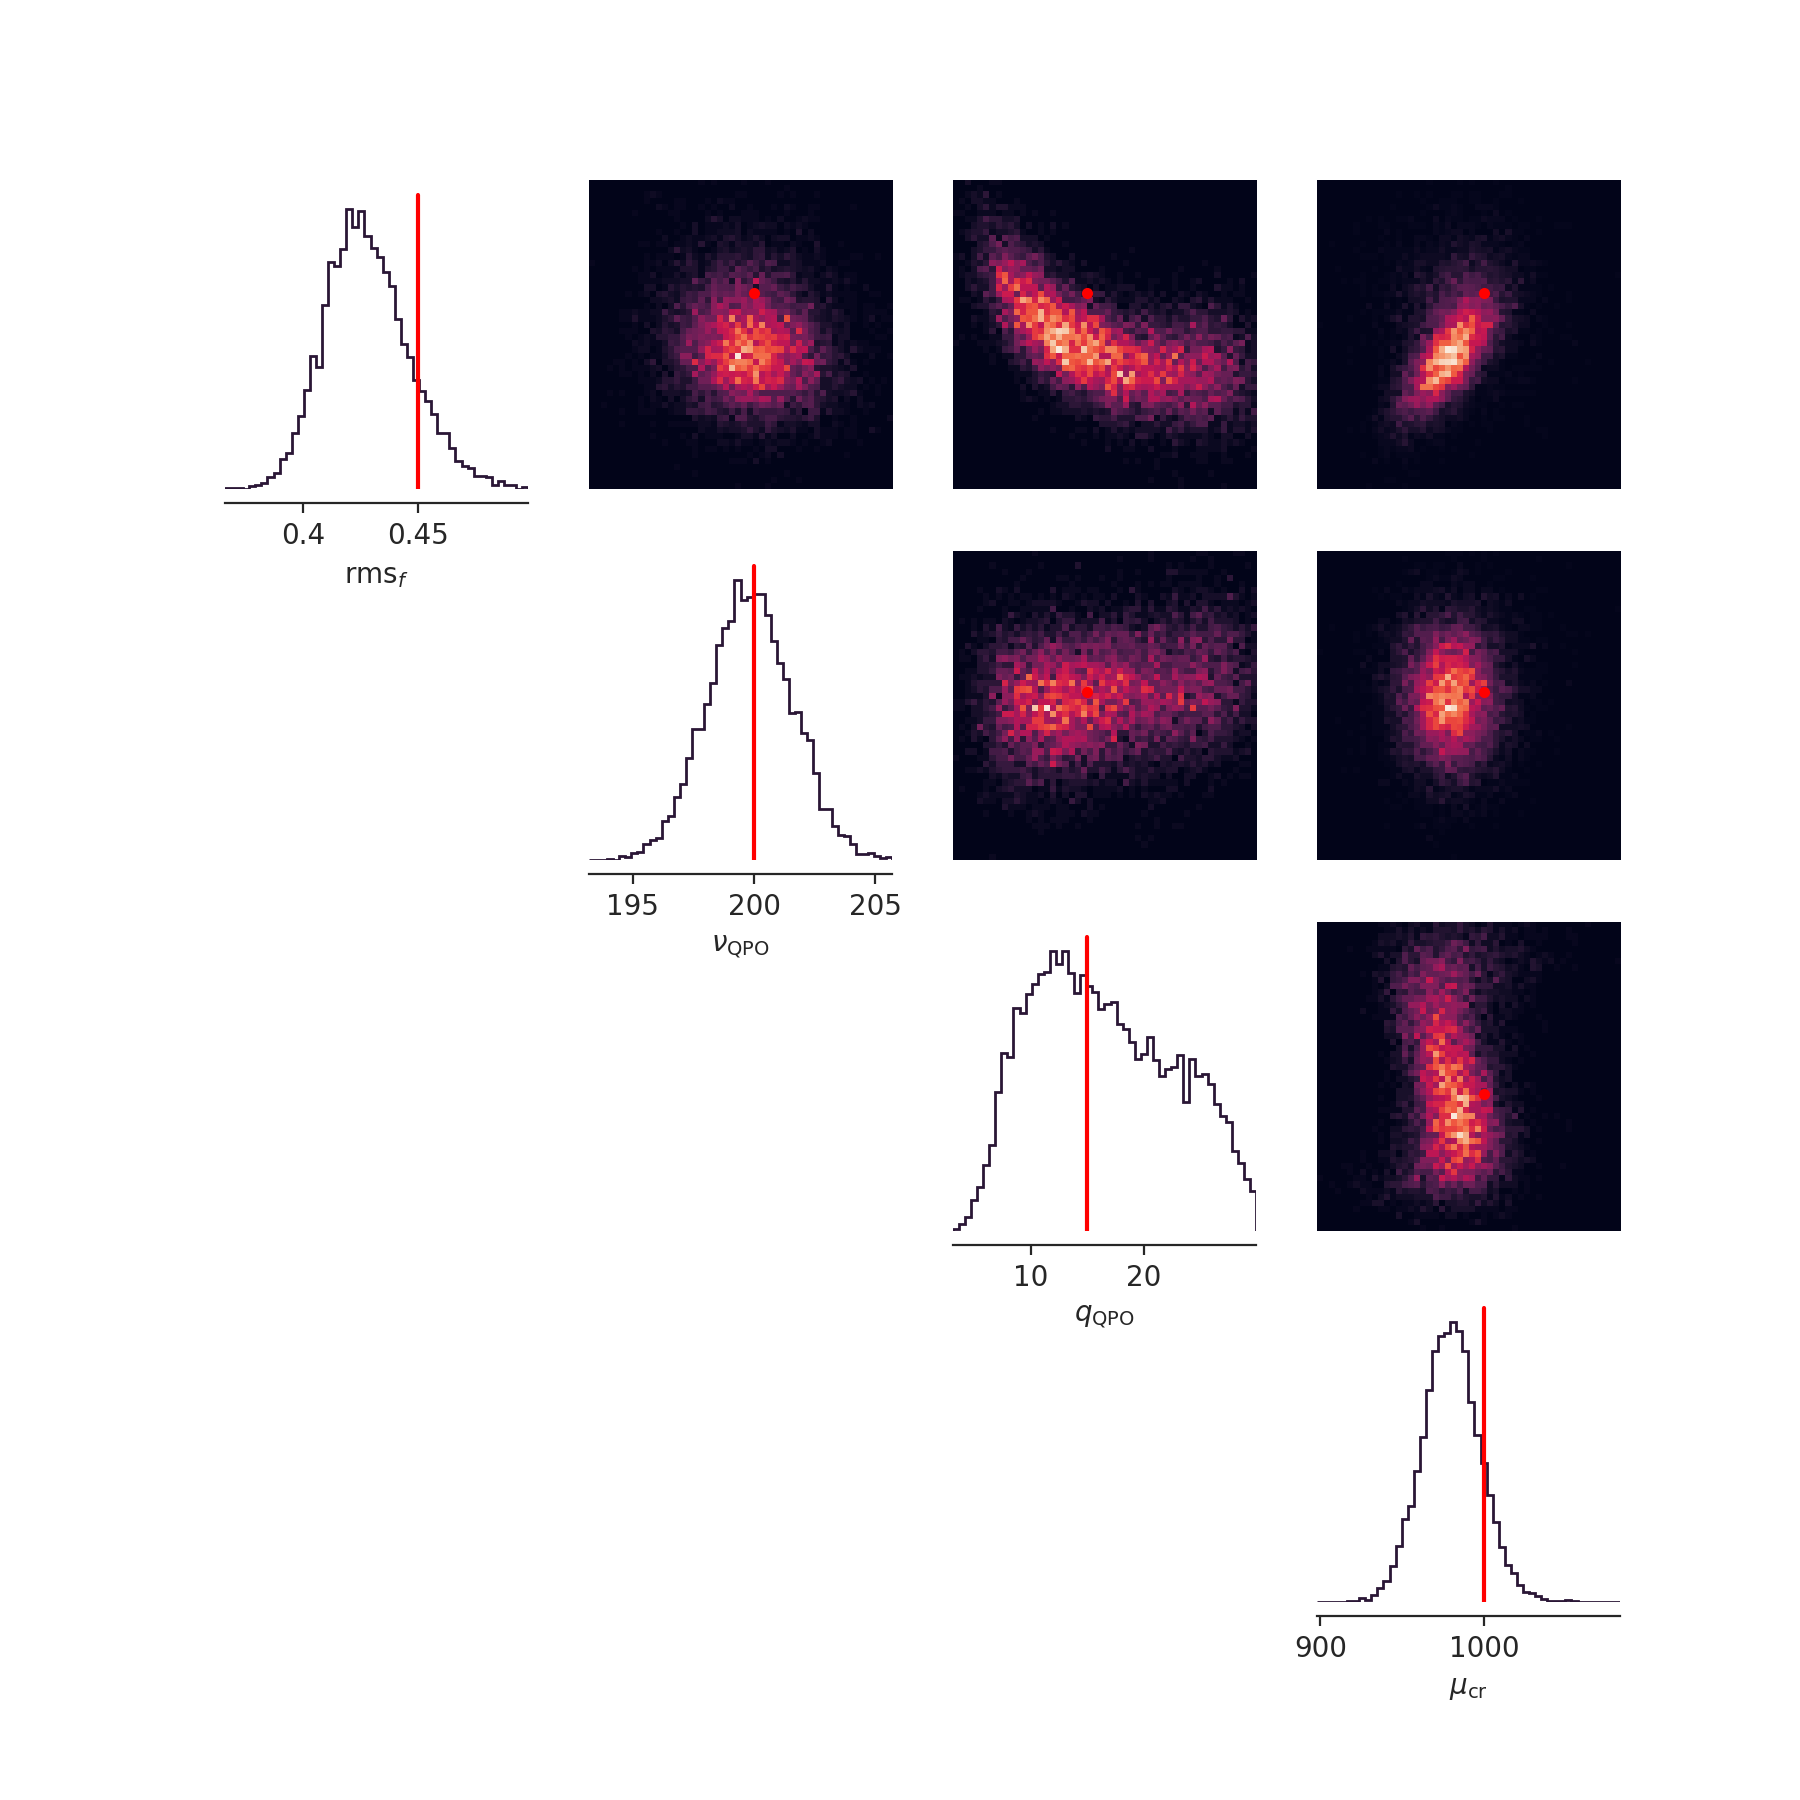

In [37]:
fig, axes =utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);


plt.savefig("../figs/qposim_hf_corner.pdf", format="pdf")

<IPython.core.display.Javascript object>


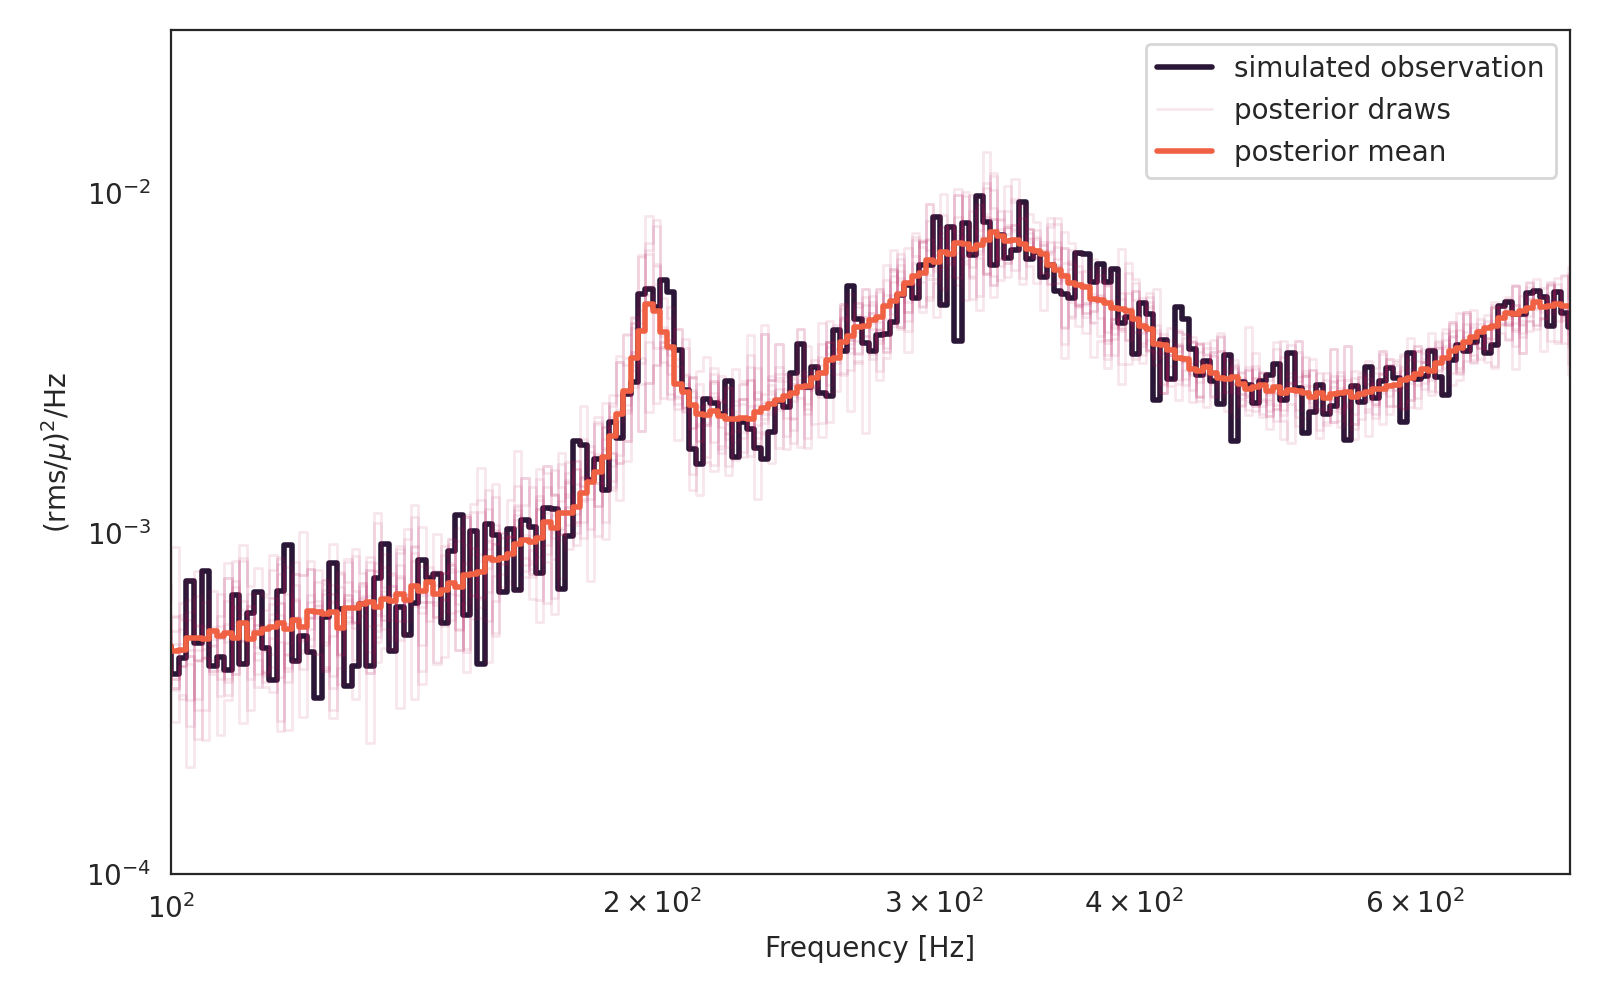

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [38]:
plot_posterior_draws(ps_log_dt, samples, sim_func, savefig=True, filename="../figs/qposim_hf_post_draws.pdf",
                     xlim=[100, 750], ylim=[1e-4,3e-2])

### Sequential Posterior Estimation

In [39]:
inference_se = SNPE(prior=prior)
simulator_se, prior_se = prepare_for_sbi(sim_func, prior)

# that were sampled from the obtained posterior.
num_rounds = 

posteriors_se = []
proposal_se = prior_se

idx = np.random.choice(np.arange(theta.shape[0], dtype=int), size=1000)

theta0 = theta[idx]

x0 = x[idx]
for i in range(num_rounds):
    if i == 0:
        theta_tmp = theta0
        x_tmp = x0
    else:
        theta_tmp, x_tmp = simulate_for_sbi(simulator_se, proposal_se, num_simulations=1000)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator_se = inference_se.append_simulations(theta_tmp, x_tmp, proposal=proposal_se).train()
    posterior_se = inference_se.build_posterior(density_estimator_se)
    posteriors_se.append(posterior_se)
    proposal_se = posterior_se.set_default_x(ps_log_dt.power)



Neural network successfully converged after 30 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 51 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 29 epochs.


In [42]:
for i in range(num_rounds):
    if i == 0:
        theta_tmp = theta0
        x_tmp = x0
    else:
        theta_tmp, x_tmp = simulate_for_sbi(simulator_se, proposal_se, num_simulations=1000)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator_se = inference_se.append_simulations(theta_tmp, x_tmp, proposal=proposal_se).train()
    posterior_se = inference_se.build_posterior(density_estimator_se)
    posteriors_se.append(posterior_se)
    proposal_se = posterior_se.set_default_x(ps_log_dt.power)




Using SNPE-C with atomic loss
Neural network successfully converged after 55 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 22 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 22 epochs.


In [43]:
posterior_se = inference_se.build_posterior(density_estimator_se)
samples_se = posterior_se.sample((10000,), 
                           x=torch.as_tensor(ps_log_dt.power))

<IPython.core.display.Javascript object>


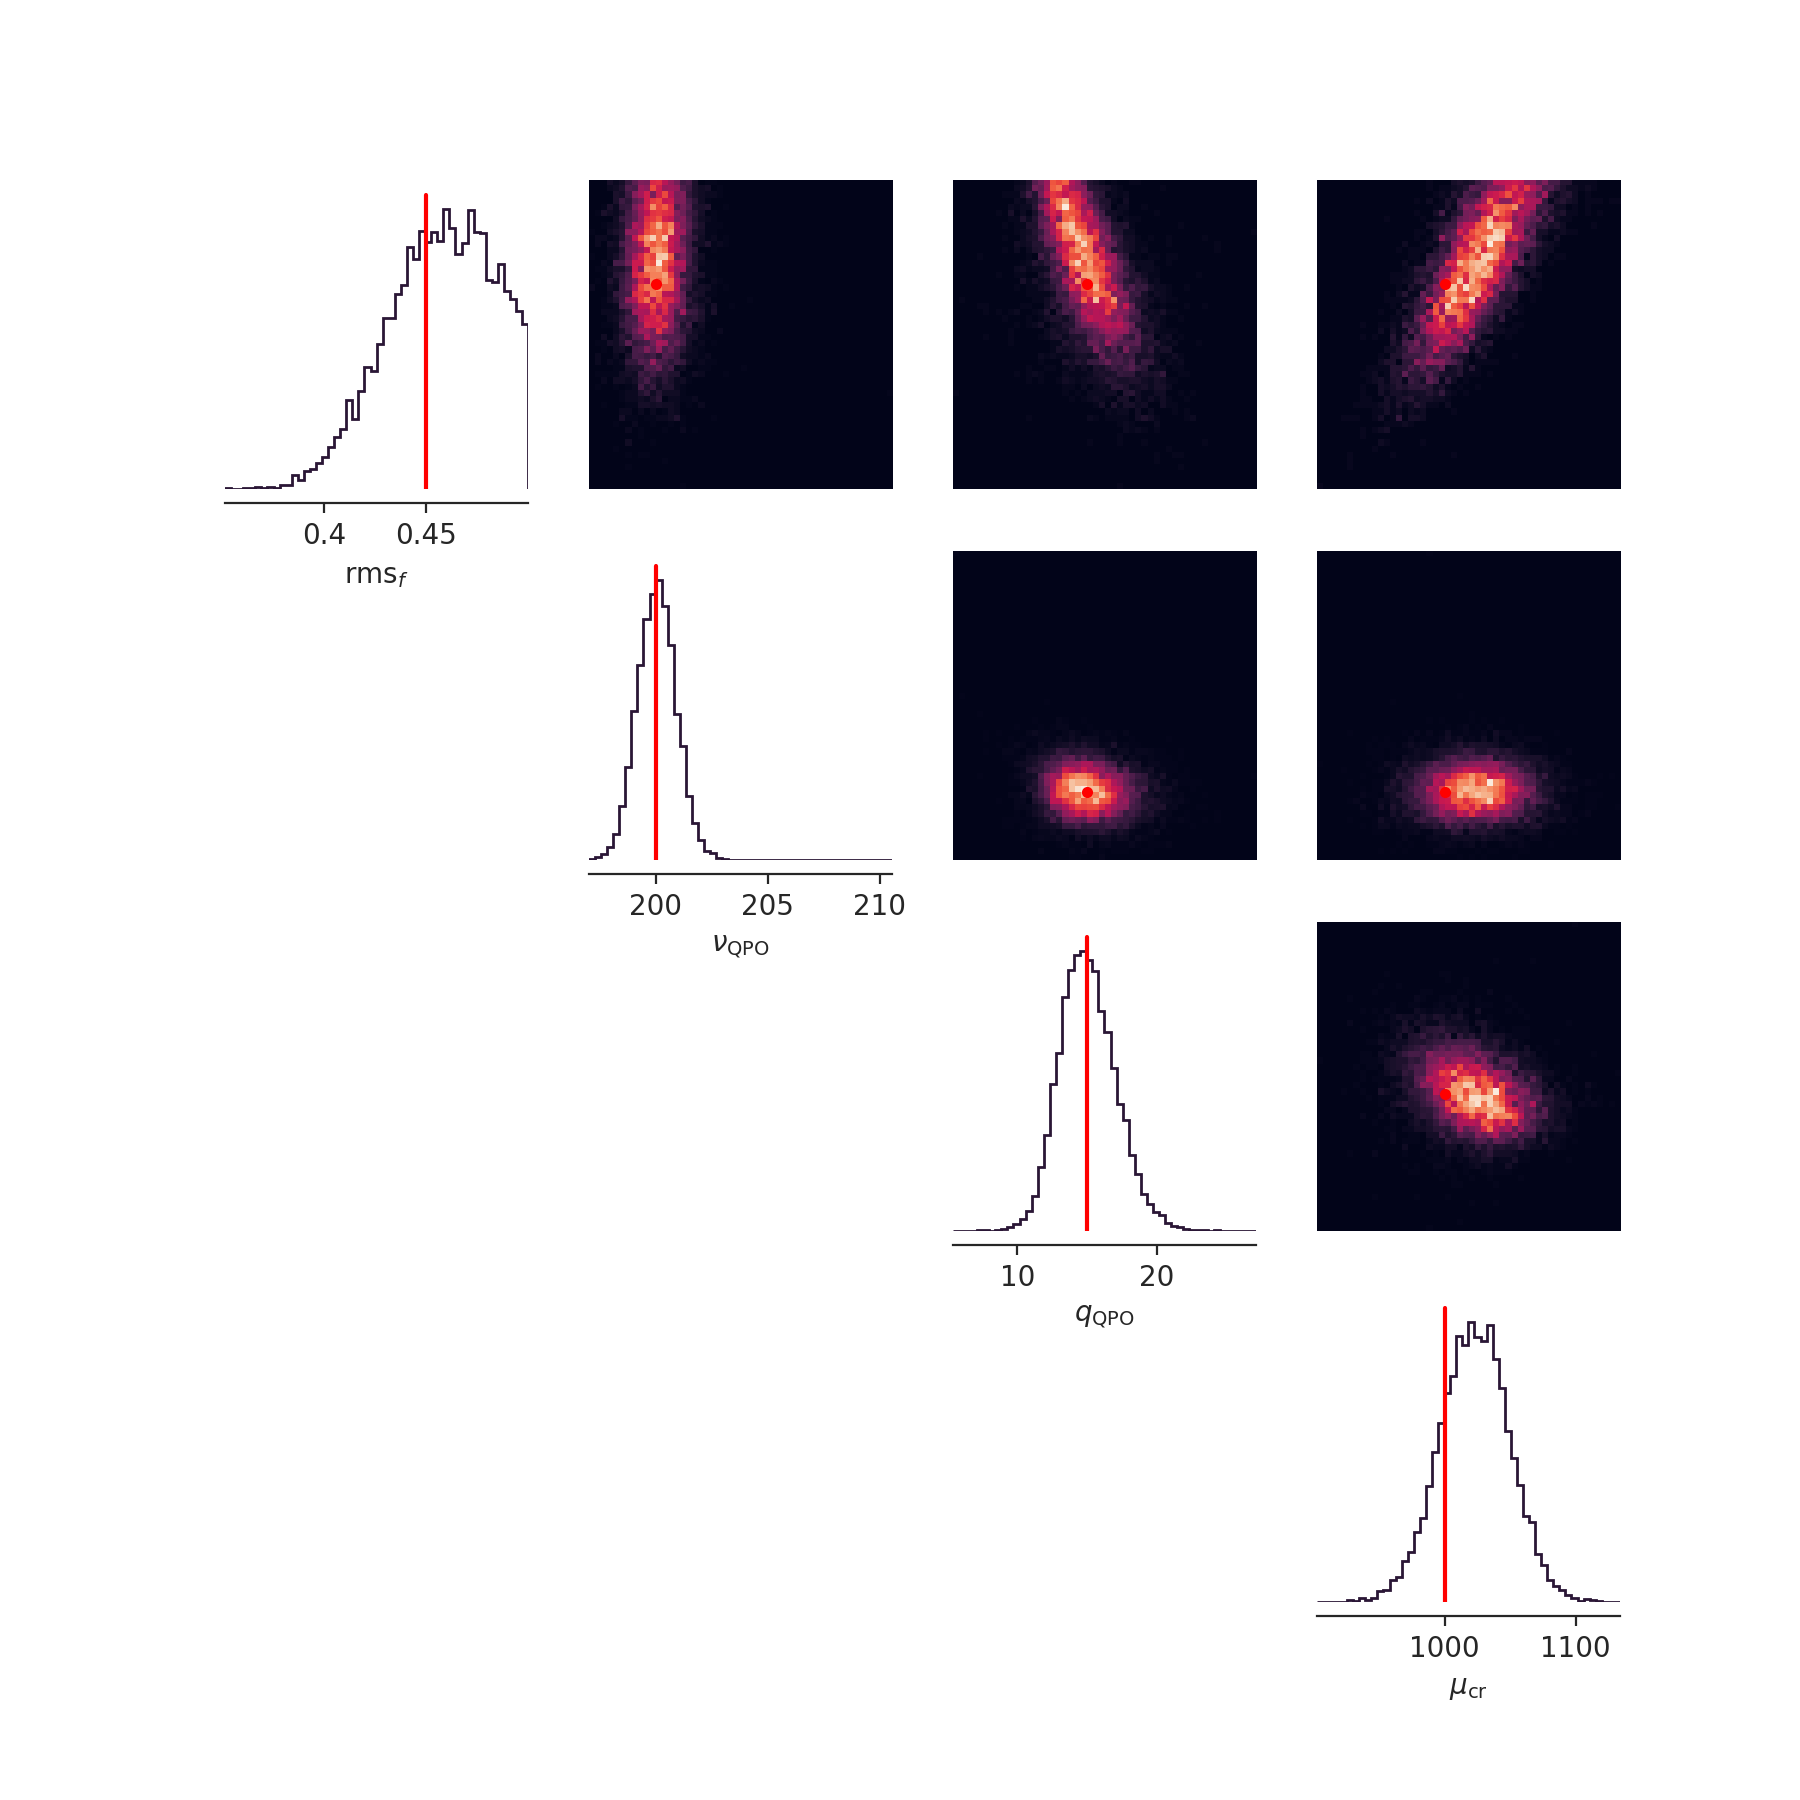

In [44]:
fig, axes = utils.pairplot(samples_se,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names);


#plt.savefig("../figs/qposim_hf_corner_sequential.pdf", format="pdf")

<IPython.core.display.Javascript object>


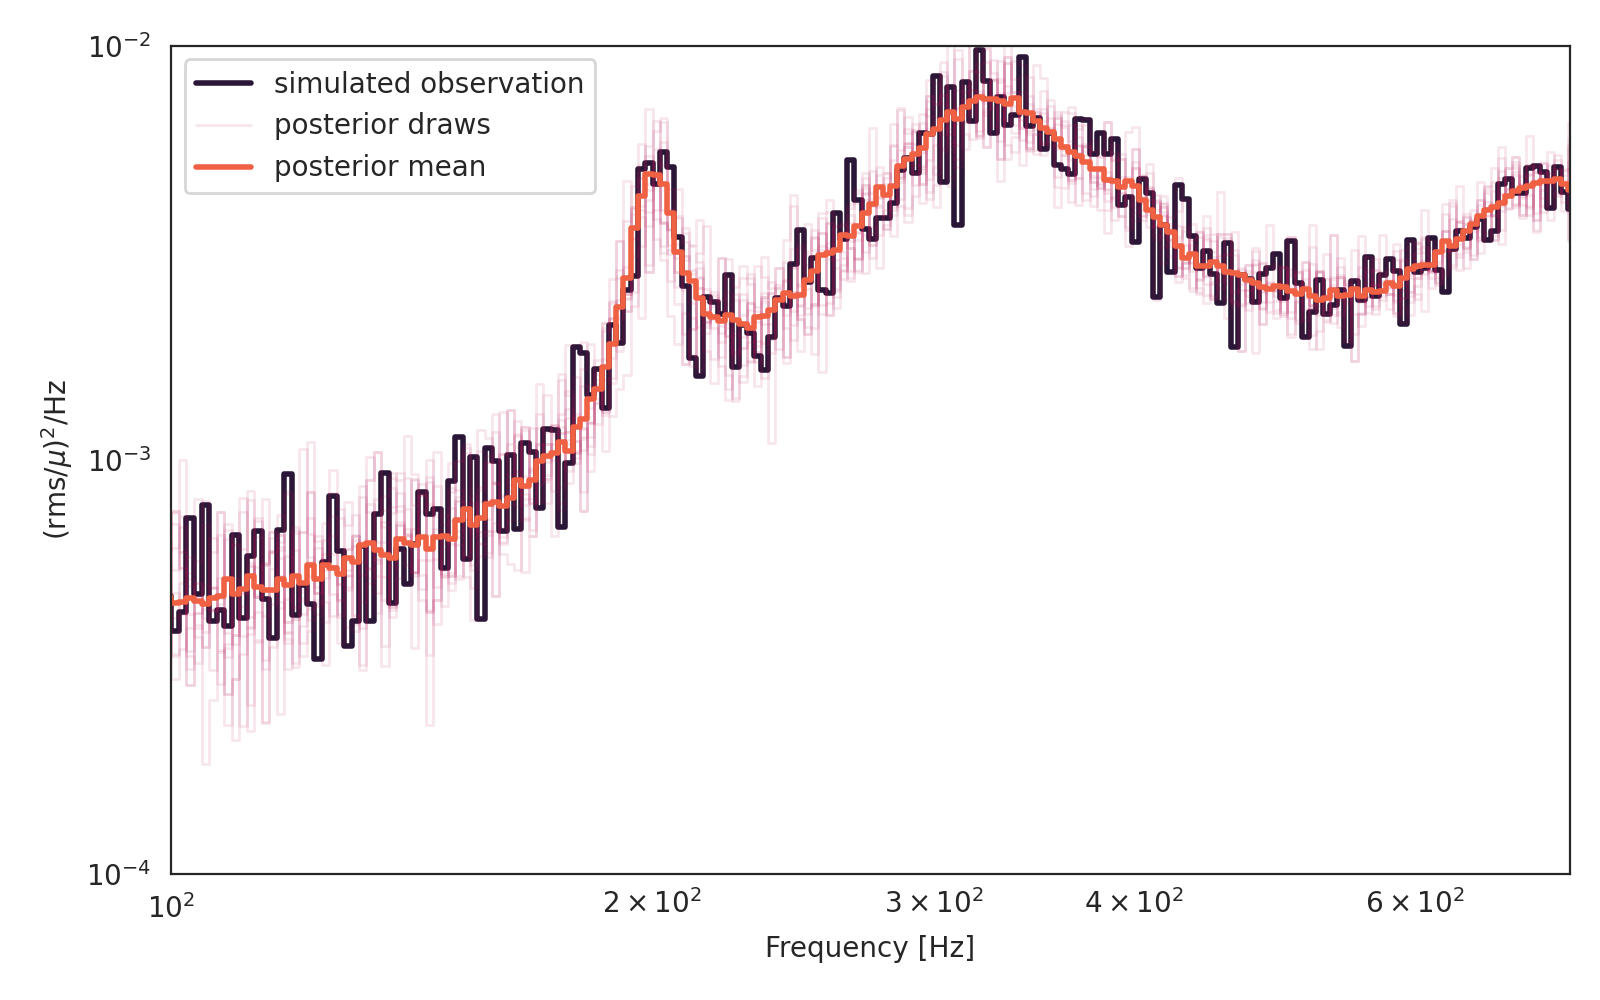

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [45]:
plot_posterior_draws(ps_log_dt, samples_se, sim_func, savefig=False, 
                     filename="../figs/qposim_hf_post_draws_sequential.pdf", xlim=[100, 750], ylim=[1e-4,1e-2])

So the sequential version does similarly well, but with drastically fewer iterations.

### Embedding Nets 

Let's add an embedding net:

In [46]:
conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=25, padding=10, stride=1)
pool = nn.MaxPool1d(kernel_size=15, stride=5)

In [47]:
pool(F.relu(conv1(torch.FloatTensor(ps_log_dt.power).unsqueeze(0).unsqueeze(0)))).shape

torch.Size([1, 4, 84])

In [48]:
len(ps_log_dt.freq)

436

In [49]:
x.shape

torch.Size([50000, 436])

In [50]:
class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        # 1D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=25, padding=10, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=15, stride=5)        
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=4*84, out_features=12) 

    def forward(self, x):
        x = x.view(-1, 1, 436)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 4*84)
        x = F.relu(self.fc(x))
        return x

embedding_net = SummaryNet()


Now we can generate a simulator function to use in the SBI interface:

In [51]:
sim_func = generate_simulator_function(**simulation_kwargs)

In [52]:
simulator_wrapper_en, prior_en = prepare_for_sbi(sim_func, prior)

# instantiate the neural density estimator
neural_posterior_en = utils.posterior_nn(model='mdn', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=2)

# setup the inference procedure with the SNPE-C procedure
inference_en = SNPE(prior=prior_en, density_estimator=neural_posterior_en)


Let's actually learn the network:

In [54]:
density_estimator_en = inference_en.append_simulations(theta, x).train()

Neural network successfully converged after 188 epochs.


In [55]:
posterior_en = inference_en.build_posterior(density_estimator_en)


In [61]:
samples_en = posterior_en.sample((10000,), 
                           x=torch.as_tensor(ps_log_dt.power))

<IPython.core.display.Javascript object>


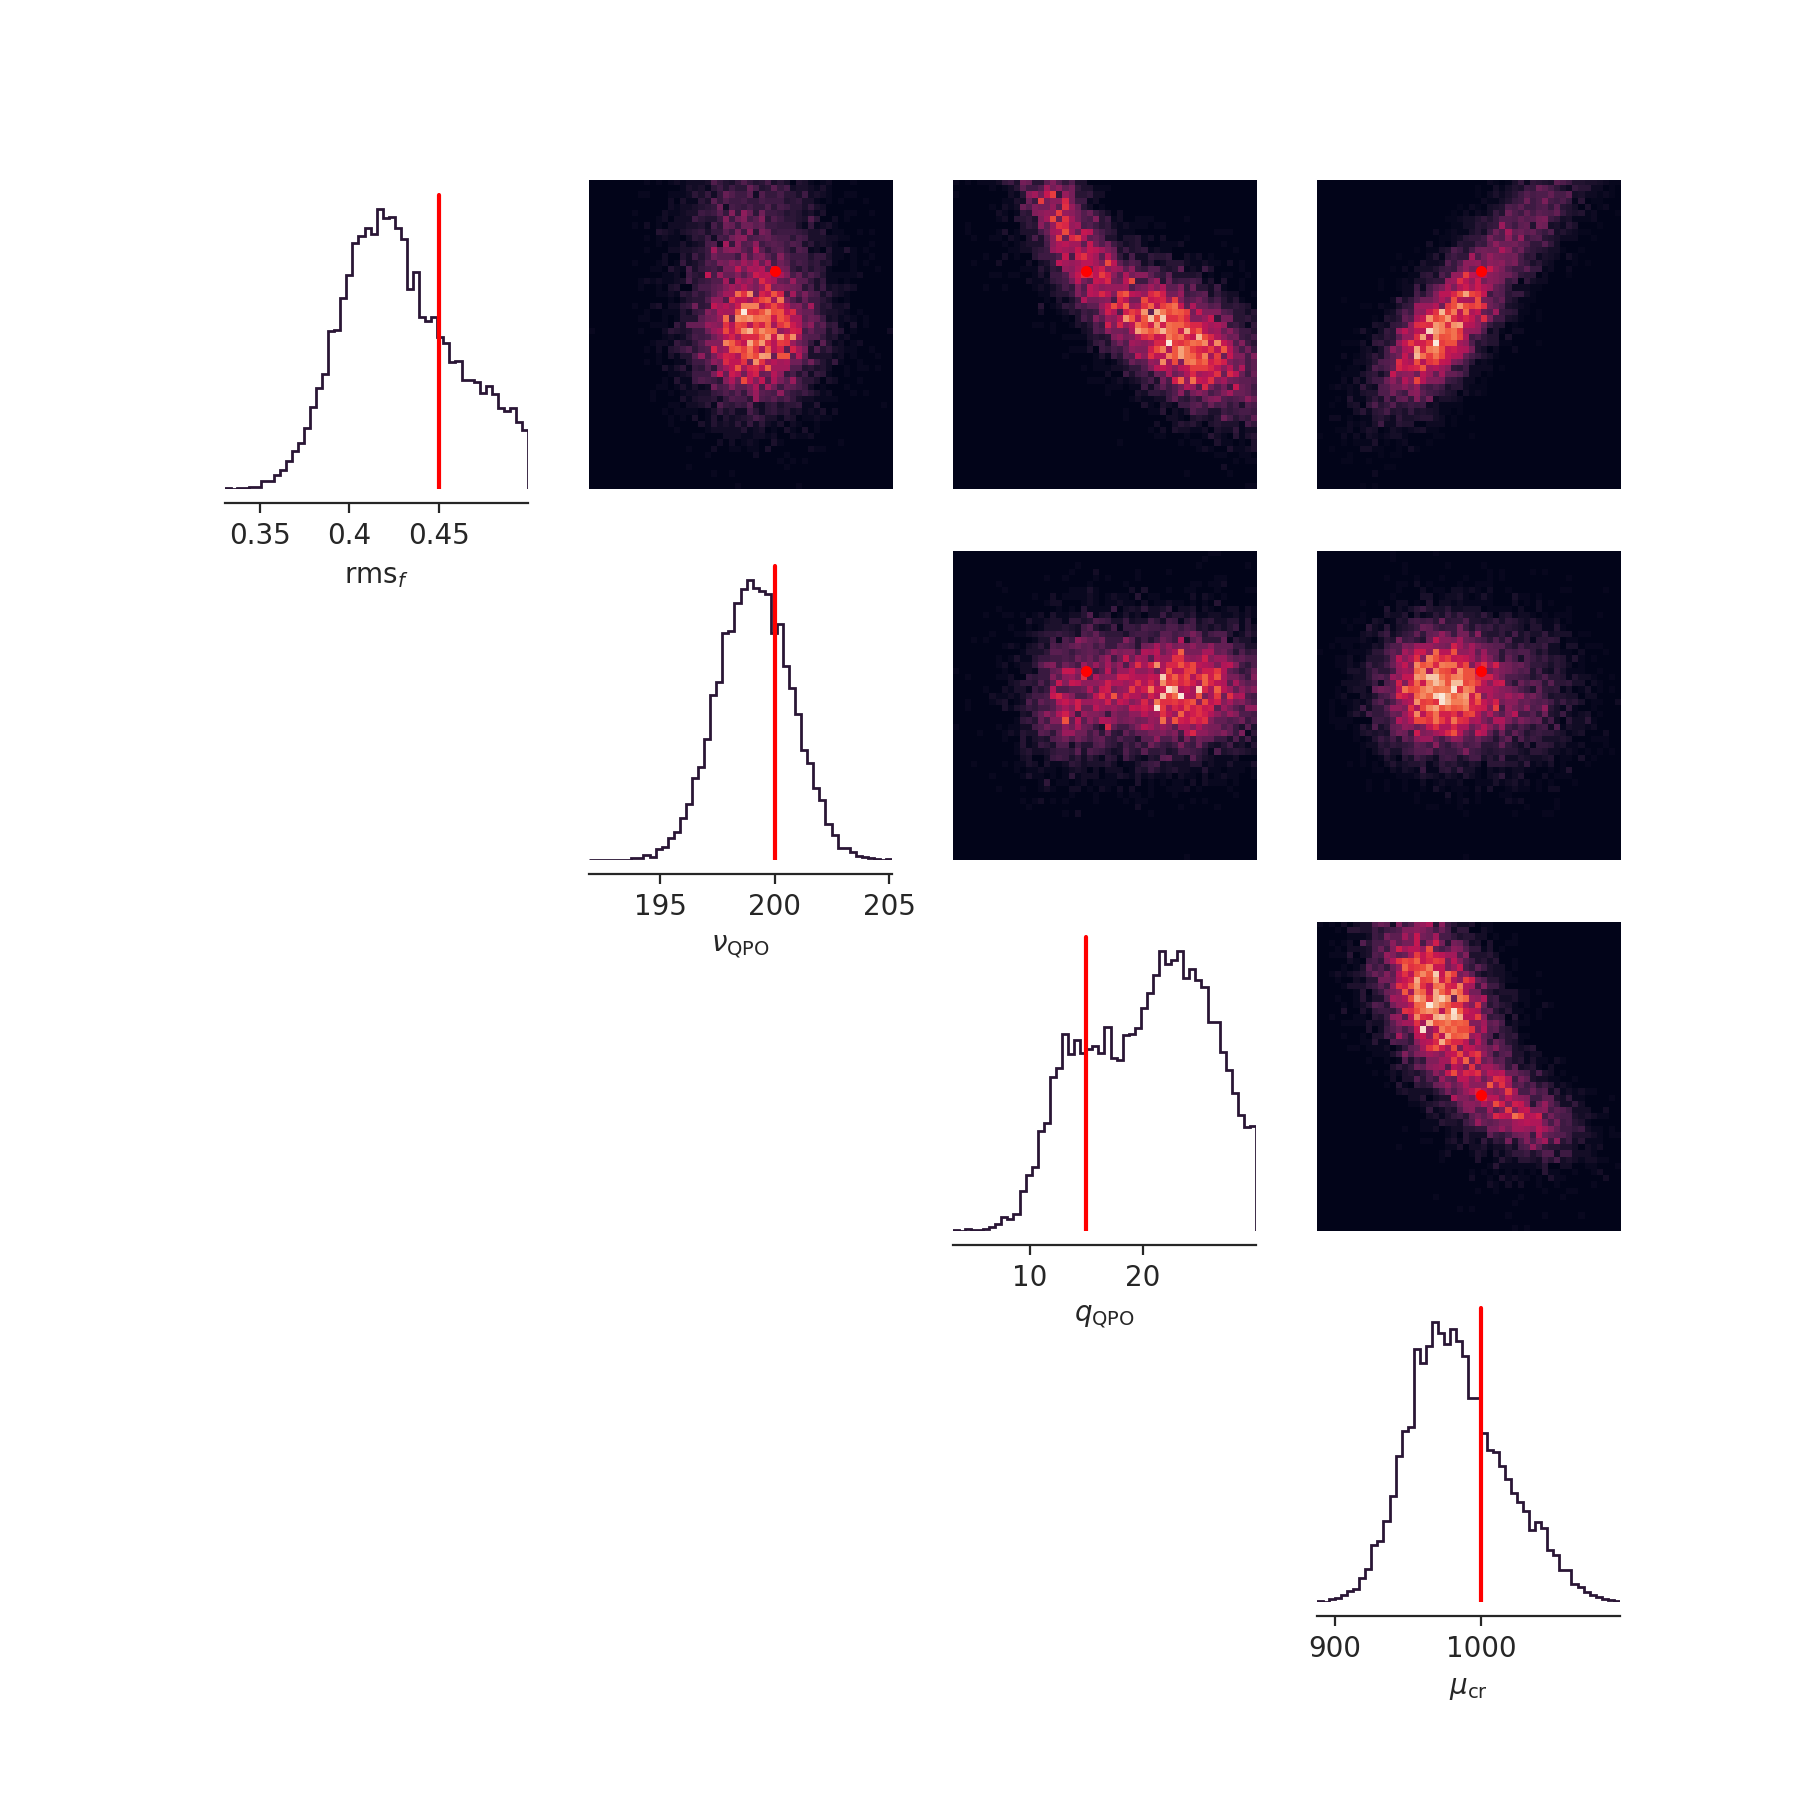

In [62]:
fig, axes = utils.pairplot(samples_en,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           labels=param_names,
                           points_colors='r');

#plt.savefig("../figs/qposim_hf_corner.pdf", format="pdf")

<IPython.core.display.Javascript object>


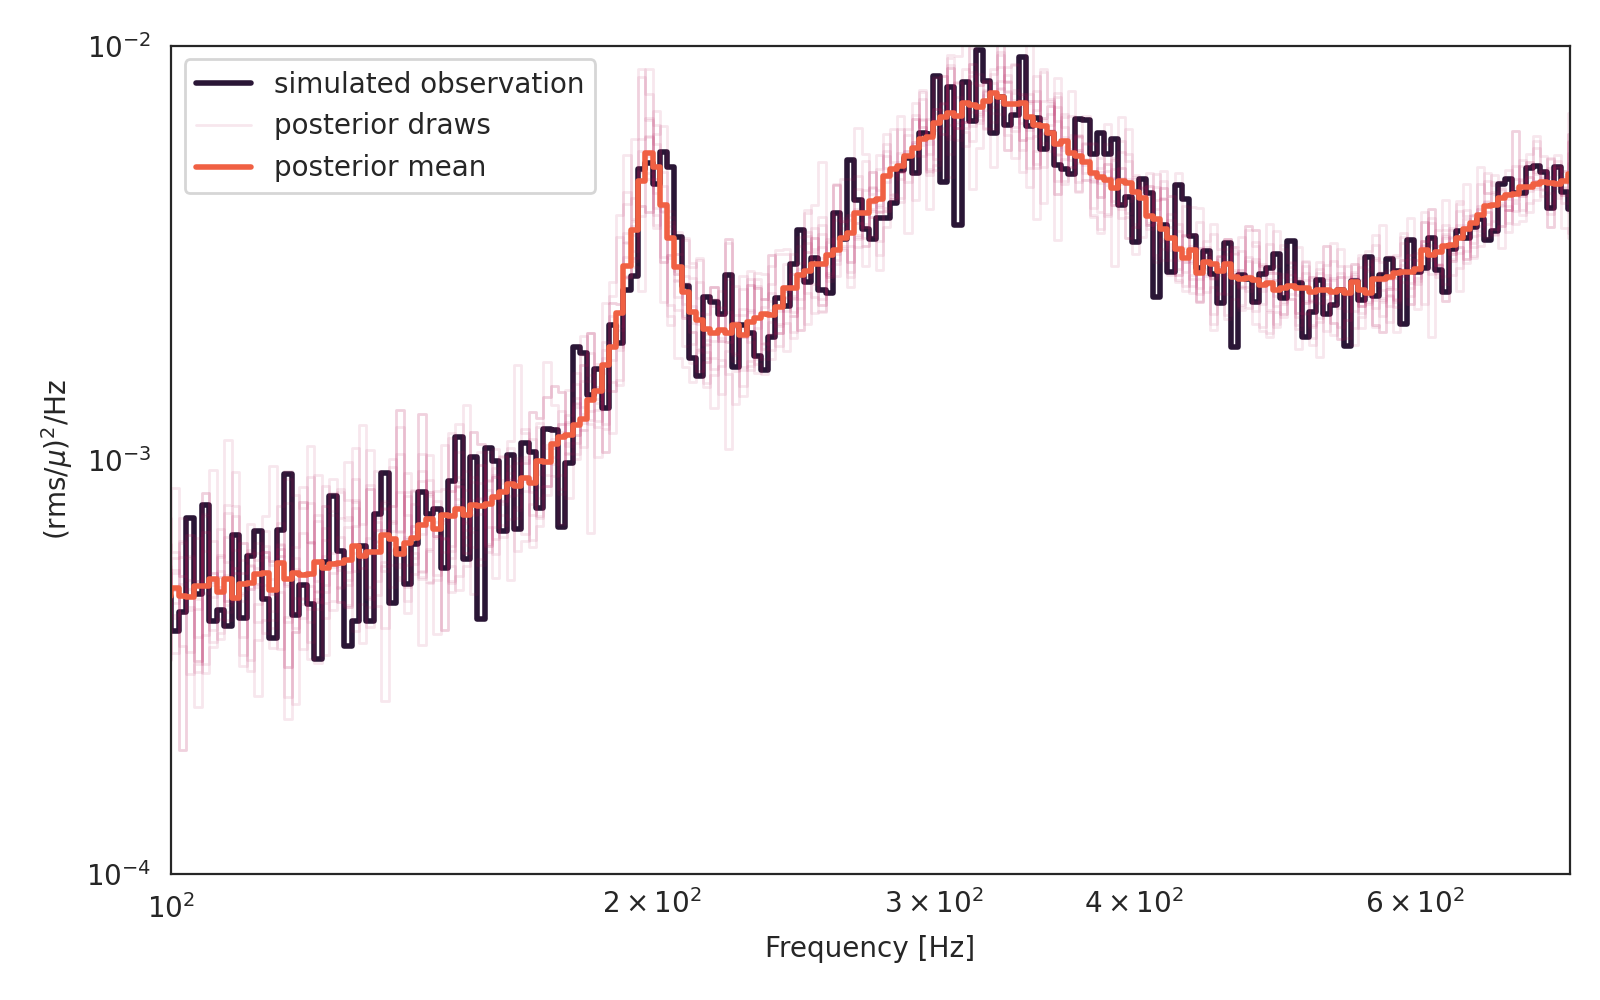

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='$(\\mathrm{rms}/\\mu)^2/\\mathrm{Hz}$'>)

In [68]:
plot_posterior_draws(ps_log_dt, samples_en, sim_func, savefig=False, 
                     filename="../figs/qposim_hf_post_draws_enbed.pdf", xlim=[100, 750], ylim=[1e-4,1e-2])

Let's combine the results:

<IPython.core.display.Javascript object>


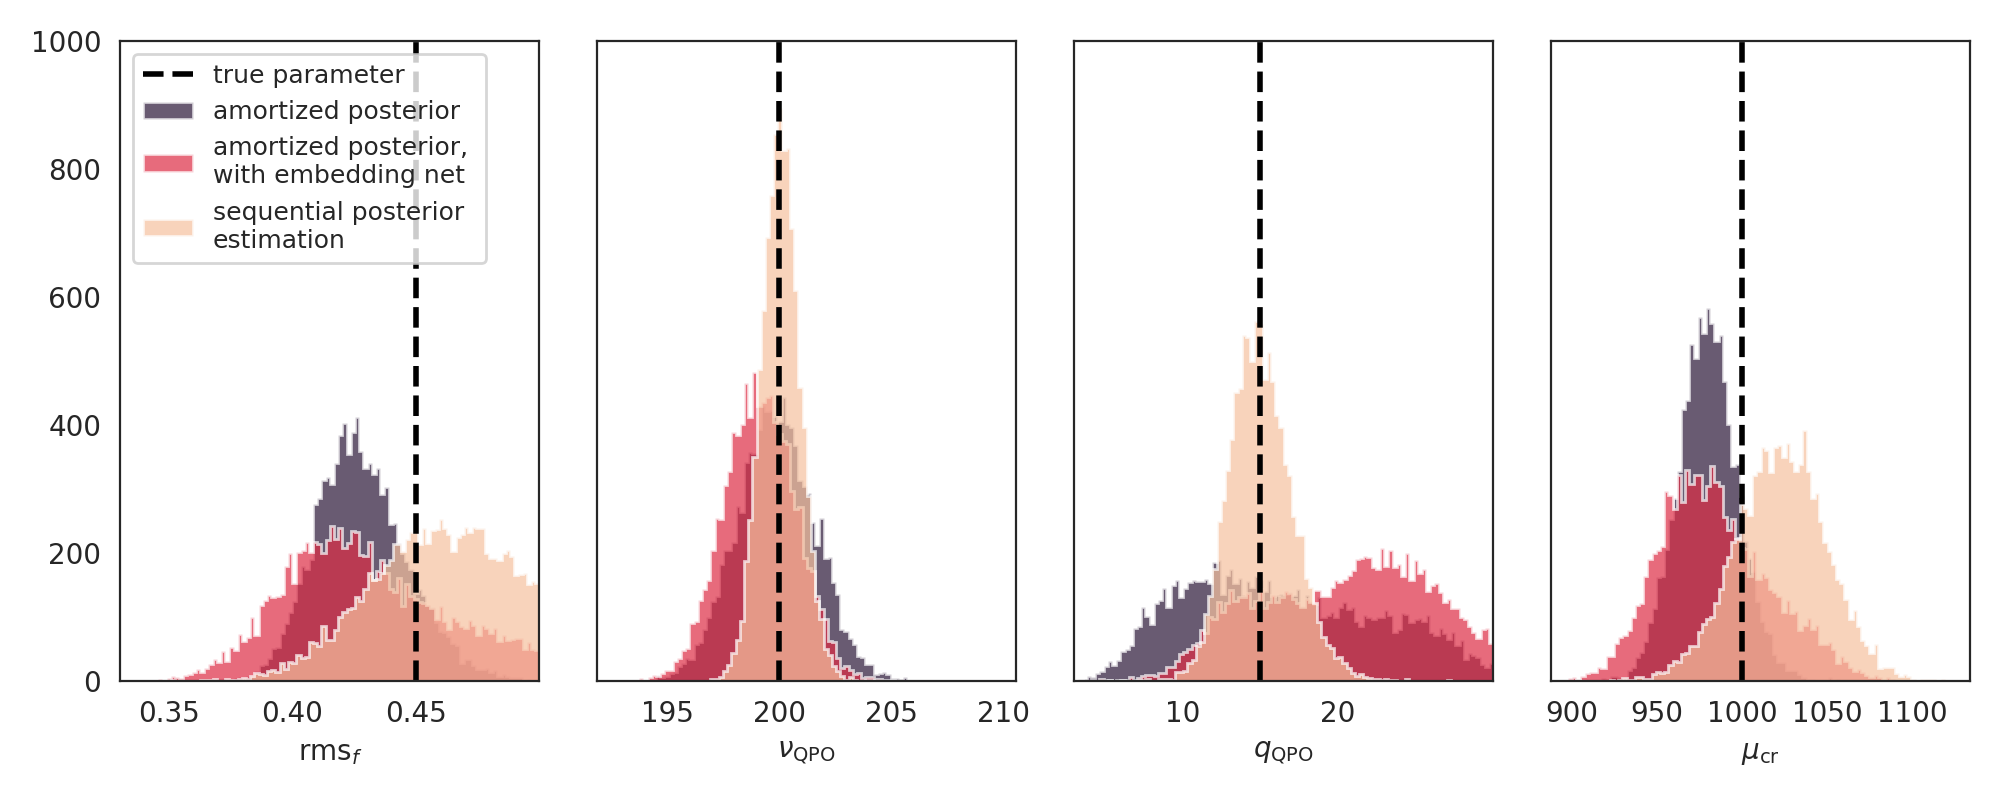

In [73]:
fig, axes = plt.subplots(1, 4, figsize=(10,4), sharey=True)

b = 100
a = 0.7

c1 = pal[0]
c2 = pal[4]
c3 = pal[7]
ht = "stepfilled"

for i in range(4):
    s = np.array(samples[:,i])
    s_en = np.array(samples_en[:,i])
    s_se = np.array(samples_se[:,i])
    
    par_range = [np.min(np.hstack([s,s_en, s_se])),
                 np.max(np.hstack([s, s_en, s_se]))]
    axes[i].hist(s, bins=b, alpha=a, color=c1, range=par_range, 
                 histtype=ht, label="amortized posterior")
    axes[i].hist(s_en, bins=b, alpha=a, color=c2, range=par_range, 
                 histtype=ht, label="amortized posterior, \nwith embedding net")
    axes[i].hist(s_se, bins=b, alpha=a, color=c3, range=par_range, 
                 histtype=ht, label="sequential posterior \nestimation")
    
    axes[i].set_xlabel(param_names[i])
    axes[i].set_xlim(par_range)
    axes[i].axvline(param_obs[i], lw=2, ls="dashed", color="black", label="true parameter")

axes[0].legend(prop={'size': 9}, loc="upper left")
axes[-1].set_ylim(0,1000)
plt.tight_layout()
plt.savefig("../figs/qposim_hf_post_comparison.pdf", format="pdf")

That looks pretty good.

### Combining the Embedding Net with Sequential Inference

Let's combine the two approaches:

In [333]:
simulator_wrapper, prior = prepare_for_sbi(sim_func, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='mdn', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=2)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)



#inference = SNPE(prior=prior)
#simulator, prior = prepare_for_sbi(sim_func, prior)

# that were sampled from the obtained posterior.
num_rounds = 3

posteriors = []
proposal = prior

theta0 = theta[:2000]
x0 = x[:2000]
for i in range(num_rounds):
    if i == 0:
        theta_tmp = theta0
        x_tmp = x0
    else:
        theta_tmp, x_tmp = simulate_for_sbi(simulator, proposal, num_simulations=1000)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta_tmp, x_tmp, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ps_log_dt.power)




Neural network successfully converged after 233 epochs.



Using SNPE-C with non-atomic loss
Neural network successfully converged after 143 epochs.



Using SNPE-C with non-atomic loss
Neural network successfully converged after 196 epochs.



Using SNPE-C with non-atomic loss
Neural network successfully converged after 208 epochs.



Using SNPE-C with non-atomic loss


AssertionError: NaN/Inf present in proposal posterior eval.

In [334]:
samples = posterior.sample(nsims, 
                           x=torch.as_tensor(ps_log_dt.power))

<IPython.core.display.Javascript object>


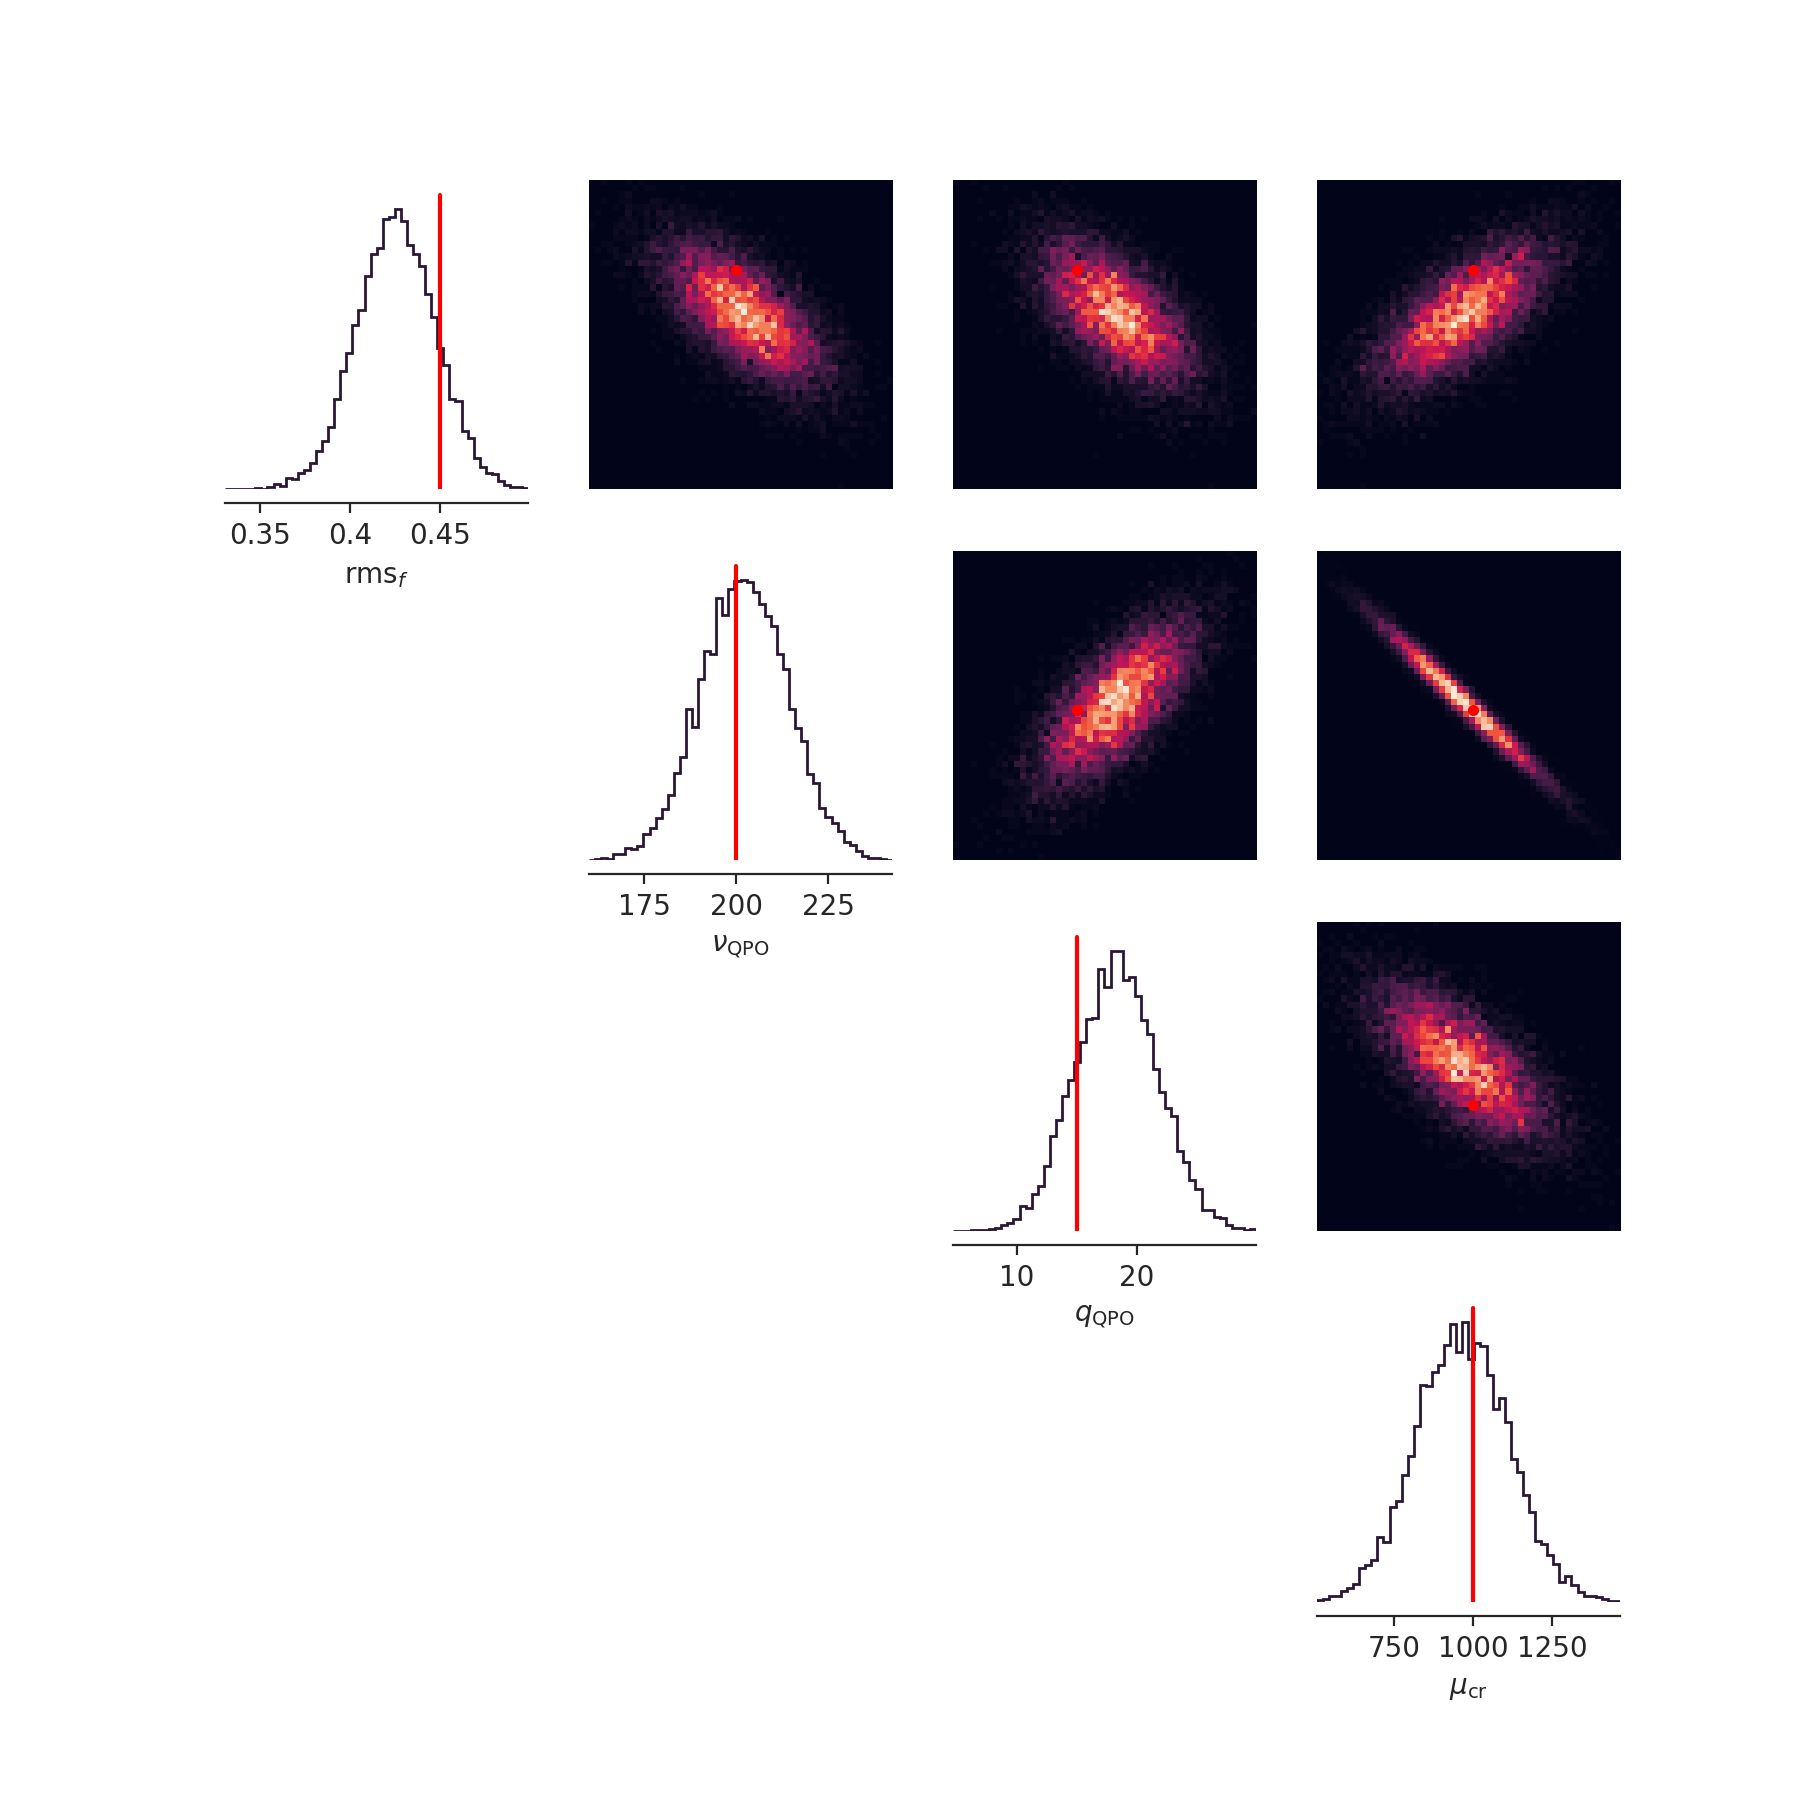

In [335]:
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           labels=param_names,
                           points_colors='r');

#plt.savefig("../figs/qposim_hf_corner.pdf", format="pdf")

In [336]:
nsim = 100

samples = np.array(samples)
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

sims_all = []

for i,j in enumerate(idx):

    param_sim = samples[j,:]
    ps_sim = np.array(sim_func(param_sim))
    sims_all.append(ps_sim)




<IPython.core.display.Javascript object>


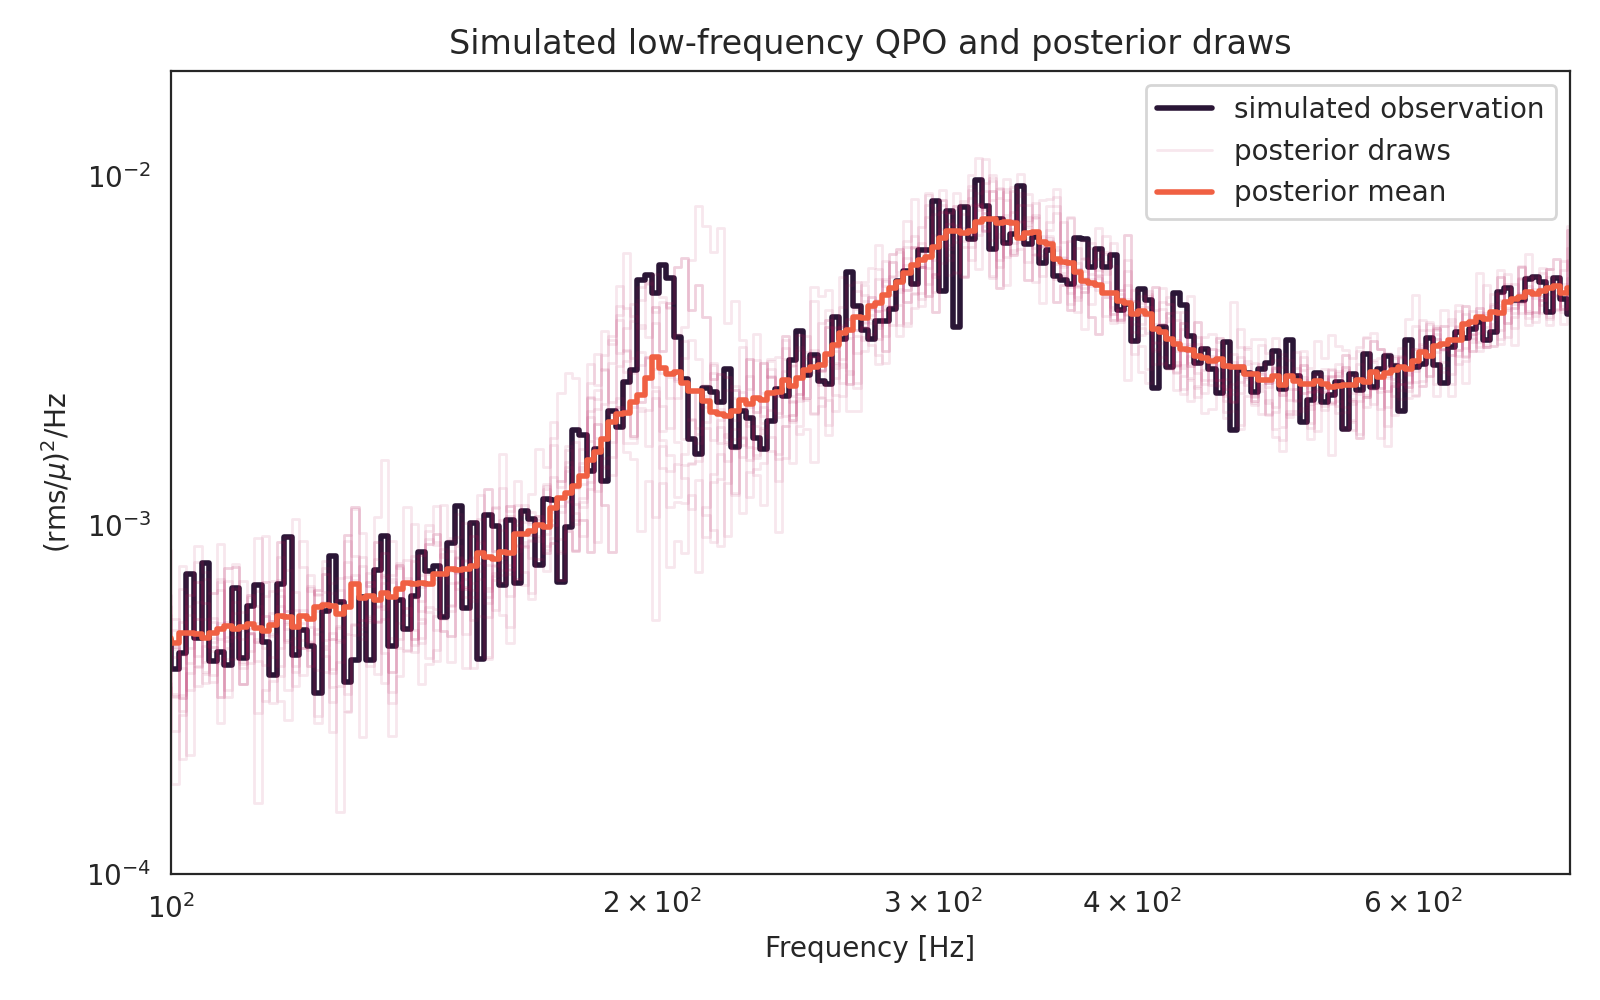

In [337]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_log_dt.freq, ps_log_dt.power, lw=2, color=pal[0], ds="steps-mid", label="simulated observation");

# plot simulations

for i, ps_sim in enumerate(sims_all):
    if i == 0:
        ax.loglog(ps_log_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid', label="posterior draws")


    if i % 10 == 0:
        ax.loglog(ps_log_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid')


sims_all = np.array(sims_all)
ps_sim_mean = np.median(sims_all, axis=0)  
ax.loglog(ps_log_dt.freq, ps_sim_mean, lw=2, c=pal[5], ds="steps-mid", label="posterior mean")
ax.set_xlim(100, ps_log_dt.freq[-1])
ax.set_ylim(1e-4, 2e-2)
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$(\mathrm{rms}/\mu)^2/\mathrm{Hz}$")
ax.set_title("Simulated low-frequency QPO and posterior draws")
plt.tight_layout()
plt.savefig("qposim_hf_post_draws.pdf", format="pdf")

... meh?

### Traditional Inference

Let's do traditional inference, though it's a bit stupid: 

In [74]:
from stingray.deadtime.model import pds_model_zhang

In [75]:
lc_obs_dt.meanrate

547.7

In [76]:
deadtime_nustar

0.0025

In [77]:
freqs, pdead_truecr = pds_model_zhang(lc_obs_dt.n, 1000, deadtime_nustar, lc_obs_dt.dt, limit_k=60)
freqs, pdead_obscr = pds_model_zhang(lc_obs_dt.n, lc_obs_dt.meanrate, deadtime_nustar, lc_obs_dt.dt, limit_k=60)

INFO:astropy:Calculating PDS model (update)


INFO: Calculating PDS model (update) [stingray.deadtime.model]


INFO:astropy:Calculating PDS model (update)


INFO: Calculating PDS model (update) [stingray.deadtime.model]


Can we remove the dead time?

In [85]:
ps_obs_leahy = Powerspectrum(lc_obs, norm="leahy")
ps_obs_dt_leahy = Powerspectrum(lc_obs_dt, norm="leahy")

ps_log_leahy = ps_obs_leahy.rebin_log()
ps_log_dt_leahy = ps_obs_dt_leahy.rebin_log()

In [84]:
pdead_truecr_norm = pdead_truecr# * (0.6*np.mean(ps_obs_dt.power))
pdead_obscr_norm = pdead_obscr# * (0.60*np.mean(ps_obs_dt.power))

Need to turn this into rms normalization:

In [96]:
pdead_truecr_norm = pdead_truecr * (ps_obs_dt_leahy.nphots / 2.0) * (1. / lc_obs_dt.n**2.) * 2 * lc_obs_dt.tseg / (lc_obs_dt.meancounts**2.)
pdead_obscr_norm = pdead_obscr * (ps_obs_dt_leahy.nphots / 2.0) * (1. / lc_obs_dt.n**2.) * 2 * lc_obs_dt.tseg / (lc_obs_dt.meancounts**2.)

Let's look at the output:

<IPython.core.display.Javascript object>


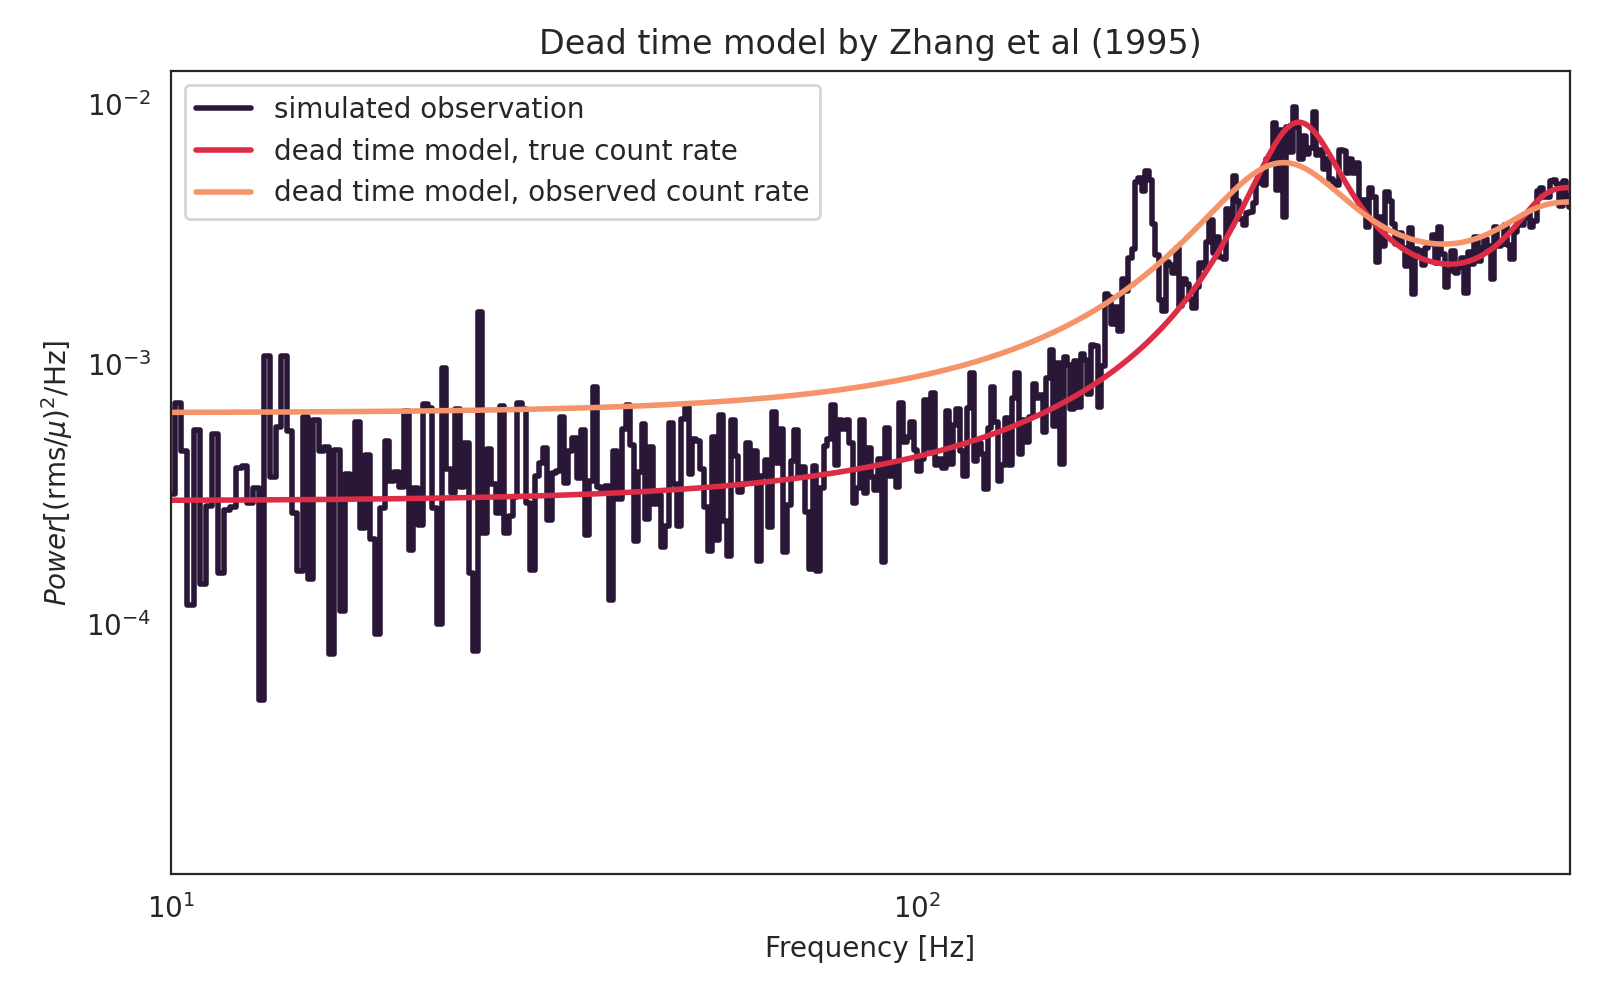

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_log_dt.freq, ps_log_dt.power, lw=2, color=pal[0], ds="steps-mid", label="simulated observation");
ax.loglog(freqs[1:], pdead_truecr_norm[1:], lw=2, c=pal[4], label="dead time model, true count rate")
ax.loglog(freqs[1:], pdead_obscr_norm[1:], lw=2, c=pal[6], label="dead time model, observed count rate")
ax.set_xlim(10, freqs[-1])
#ax.set_ylim(4e-5, 0.02)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$Power [(\mathrm{rms}/\mu)^2/\mathrm{Hz}$]")
ax.set_title("Dead time model by Zhang et al (1995)")
ax.legend()

plt.tight_layout()
plt.savefig("zhang_deadtime.pdf", format="pdf")

We'll divide out the Zhang dead time model using the observed incident count rate.

In [98]:
import copy

In [115]:
power_corr_obscr = 2. * ps_obs_dt.power / pdead_obscr_norm[1:] * (ps_obs_dt_leahy.nphots / 2.0) * (1. / lc_obs_dt.n**2.) * 2 * lc_obs_dt.tseg / (lc_obs_dt.meancounts**2.)#* np.mean(ps_obs_dt.power)
ps_corr_obscr = copy.deepcopy(ps_obs_dt)
ps_corr_obscr.power = power_corr_obscr

power_corr_truecr = 2. * ps_obs_dt.power / pdead_truecr_norm[1:] * (ps_obs_dt_leahy.nphots / 2.0) * (1. / lc_obs_dt.n**2.) * 2 * lc_obs_dt.tseg / (lc_obs_dt.meancounts**2.)#* np.mean(ps_obs_dt.power)
ps_corr_truecr = copy.deepcopy(ps_obs_dt)
ps_corr_truecr.power = power_corr_truecr

In [118]:
ps_corr_truecr_log = ps_corr_truecr.rebin_log(f=f)
ps_corr_obscr_log = ps_corr_obscr.rebin_log(f=f)

<IPython.core.display.Javascript object>


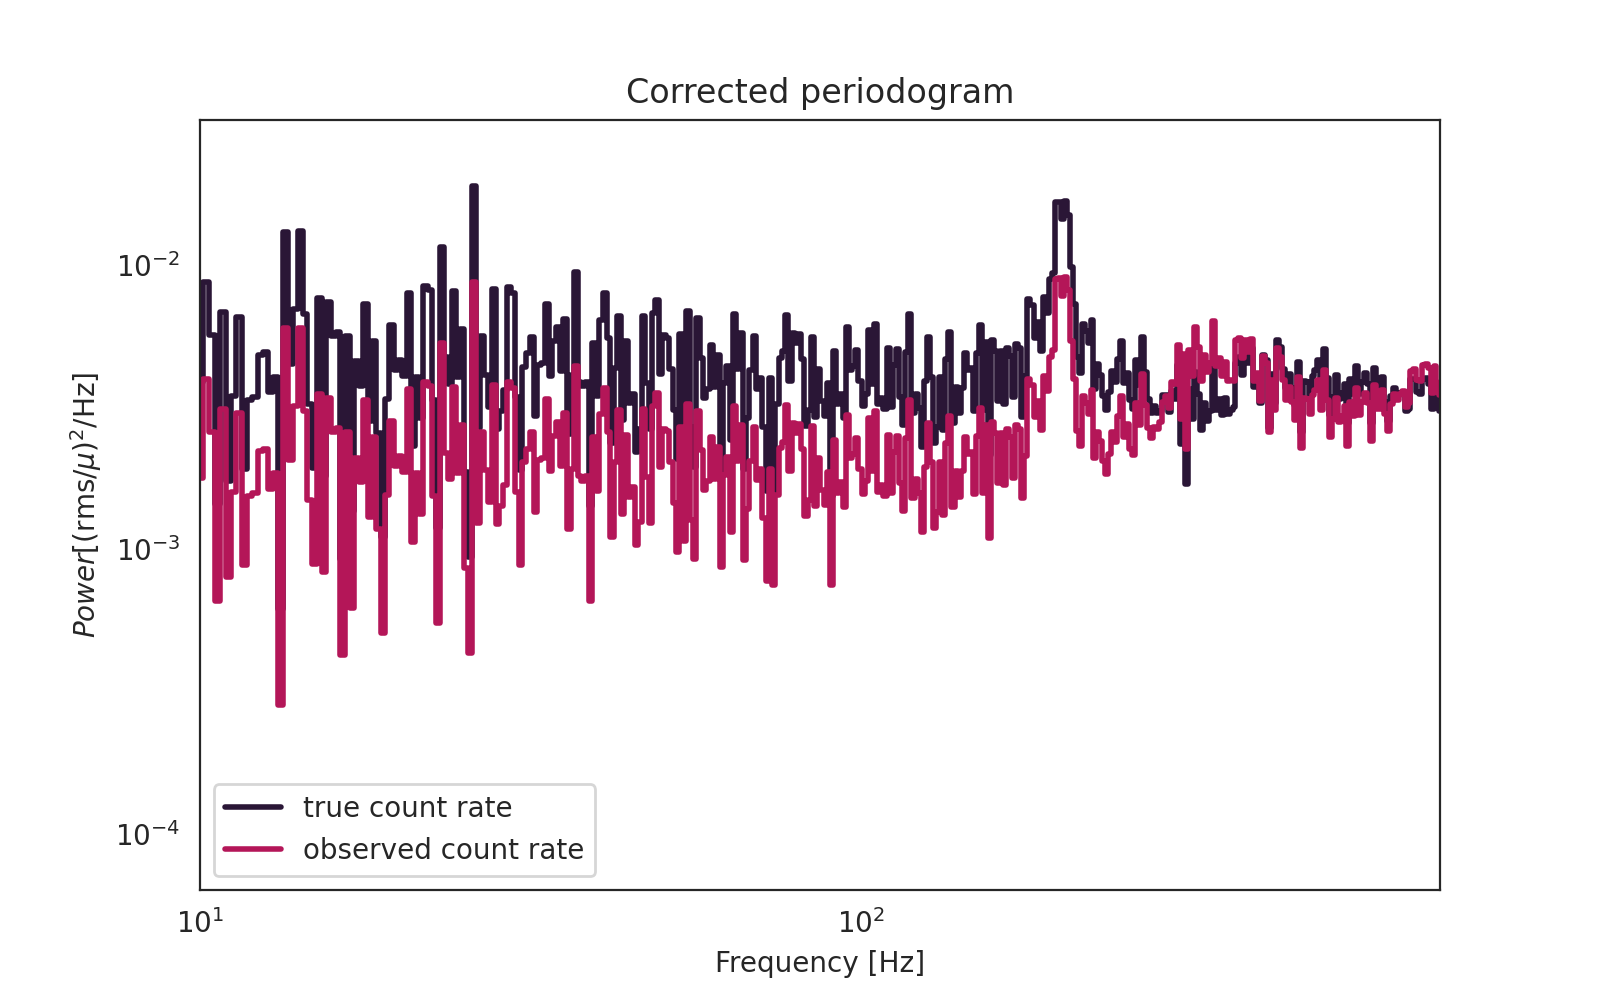

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_corr_truecr_log.freq, ps_corr_truecr_log.power, lw=2, color=pal[0], ds="steps-mid", label="true count rate");
ax.loglog(ps_corr_obscr_log.freq, ps_corr_obscr_log.power, lw=2, color=pal[3], ds="steps-mid", label="observed count rate");
#ax.loglog(freqs[1:], pdead_truecr_norm[1:], lw=2, c=pal[4], label="dead time model, true count rate")
#ax.loglog(freqs[1:], pdead_obscr_norm[1:], lw=2, c=pal[6], label="dead time model, observed count rate")
ax.set_xlim(10, freqs[-1])
#ax.set_ylim(4e-5, 0.02)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$Power [(\mathrm{rms}/\mu)^2/\mathrm{Hz}$]")
ax.set_title("Corrected periodogram")
ax.legend()



Now we can use this one for fitting:

In [111]:
qpo_model = models.Lorentz1D() + models.Const1D()

qpo_amp = 1.0
qpo_x0 = 200.0
qpo_fwhm = 10.0

qpo_model.amplitude = qpo_amp
qpo_model.x_0 = qpo_x0
qpo_model.fwhm = qpo_fwhm

amp_prior = scipy.stats.uniform(1e-5, 200).pdf
x0_prior = scipy.stats.uniform(100, 500).pdf
fwhm_prior = scipy.stats.uniform(3, 50).pdf

wn_prior = scipy.stats.uniform(1e-5, 1e5).pdf

priors = {"amplitude_0": amp_prior,
          "x_0_0": x0_prior,
          "fwhm_0": fwhm_prior,
          "amplitude_1": wn_prior}


In [112]:
from stingray.modeling import PSDPosterior, PSDParEst

[7.32320018e-03 2.00581002e+02 6.58841378e+00 3.21887754e-03]


<IPython.core.display.Javascript object>


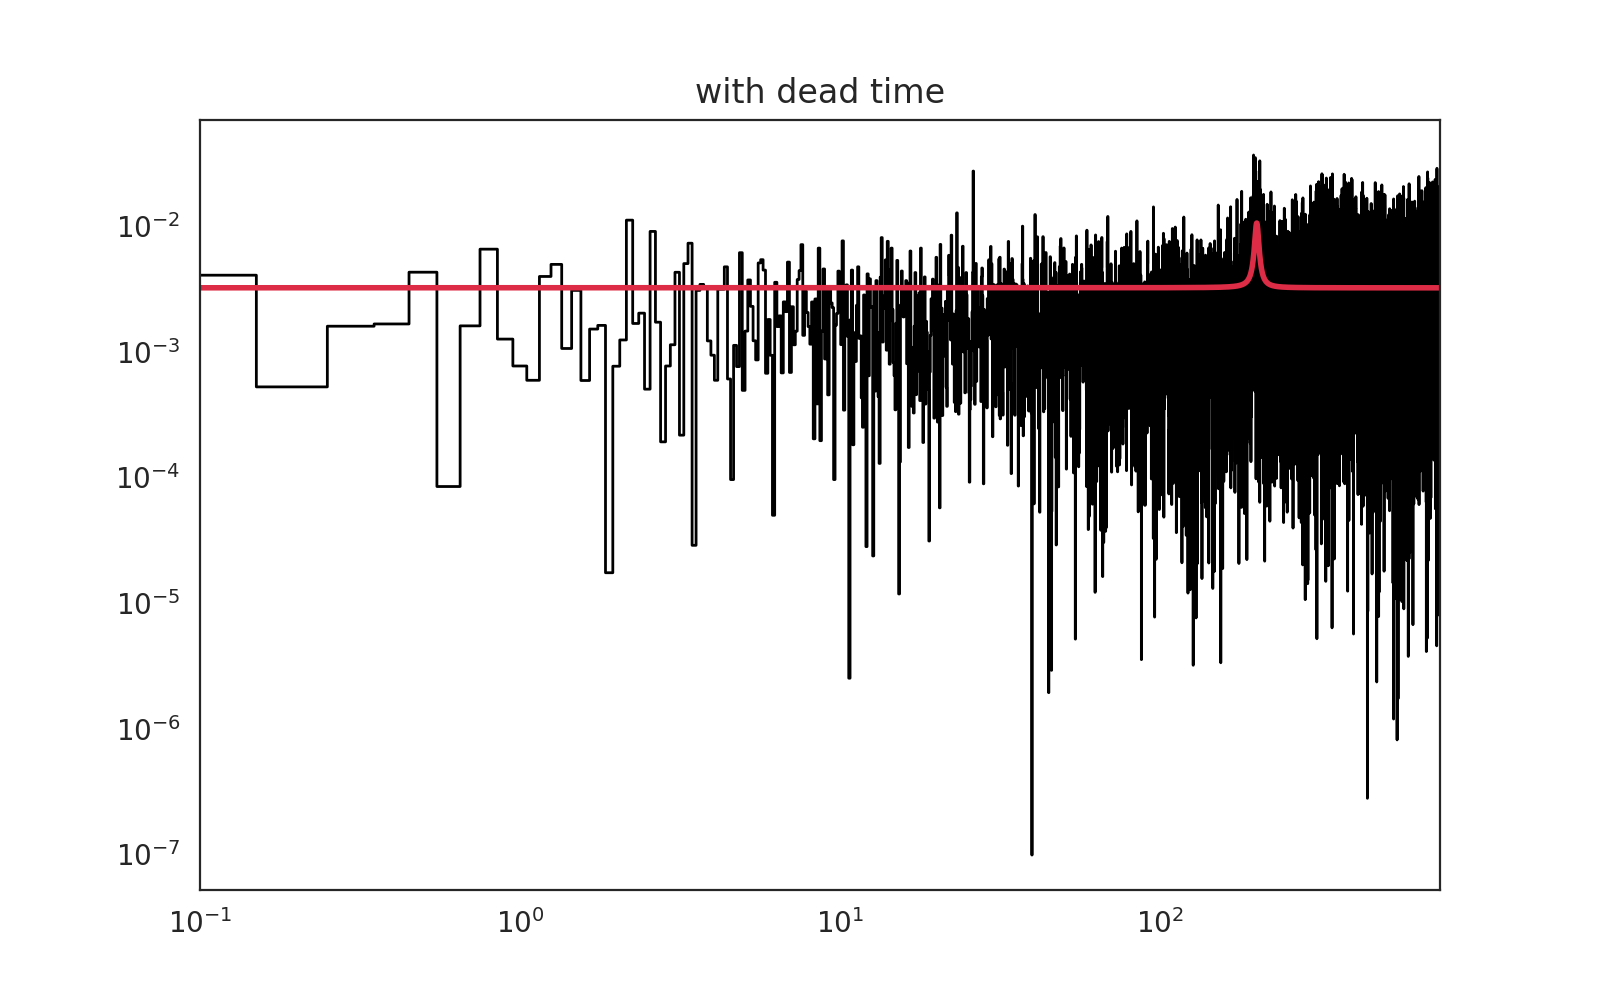

In [120]:
lpost = PSDPosterior(ps_corr_obscr.freq, ps_corr_obscr.power, qpo_model, priors=priors)

parest = PSDParEst(ps_corr_obscr, fitmethod="powell")

res = parest.fit(lpost, [0.001, 200, 20, 0.001])

print(res.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.loglog(ps_corr_obscr.freq, ps_corr_obscr.power, lw=1, color="black", ds="steps-mid")
ax.set_xlim(ps_corr_obscr.freq[0], ps_corr_obscr.freq[-1])
ax.set_title("with dead time")

ax.loglog(ps_corr.freq, res.mfit, lw=2, color=pal[4])



Let's do MCMC sampling:

In [121]:
nwalkers = 20
burnin = 500
niter = 200

samp_mcmc = parest.sample(lpost, res.p_opt, cov=res.cov, 
                             nwalkers=nwalkers, burnin=burnin, niter=niter)


-- The acceptance fraction is: 0.601000.5
-- The acceptance fraction is: 0.601000.5
INFO:MCMC summary:-- The acceptance fraction is: 0.601000.5
R_hat for the parameters is: [3.22465596e-06 5.56307691e-01 1.58788682e+00 1.49459313e-09]
R_hat for the parameters is: [3.22465596e-06 5.56307691e-01 1.58788682e+00 1.49459313e-09]
INFO:MCMC summary:R_hat for the parameters is: [3.22465596e-06 5.56307691e-01 1.58788682e+00 1.49459313e-09]
-- Posterior Summary of Parameters: 

-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

---------------------------------------------

INFO:MCMC summary:---------------------------------------------

theta[0] 	 0.007582268564741667	0.0017882049729020556	0.005091548271213593	0.010792812238806177

theta[0] 	 0.007582268564741667	0.00178820497

And let's also plot posterior draws:

In [122]:
from astropy.modeling.fitting import _fitter_to_model_params

In [123]:
nsim = 100

idx = np.random.choice(np.arange(0, samp_mcmc.samples.shape[0], 1, dtype=int), replace=False, size=nsim)

sims_all = []

for i,j in enumerate(idx):

    param_sim = samp_mcmc.samples[j,:]
    _fitter_to_model_params(qpo_model, param_sim)
    ps_sim = np.array(qpo_model(ps_corr.freq))
    sims_all.append(ps_sim)


<IPython.core.display.Javascript object>


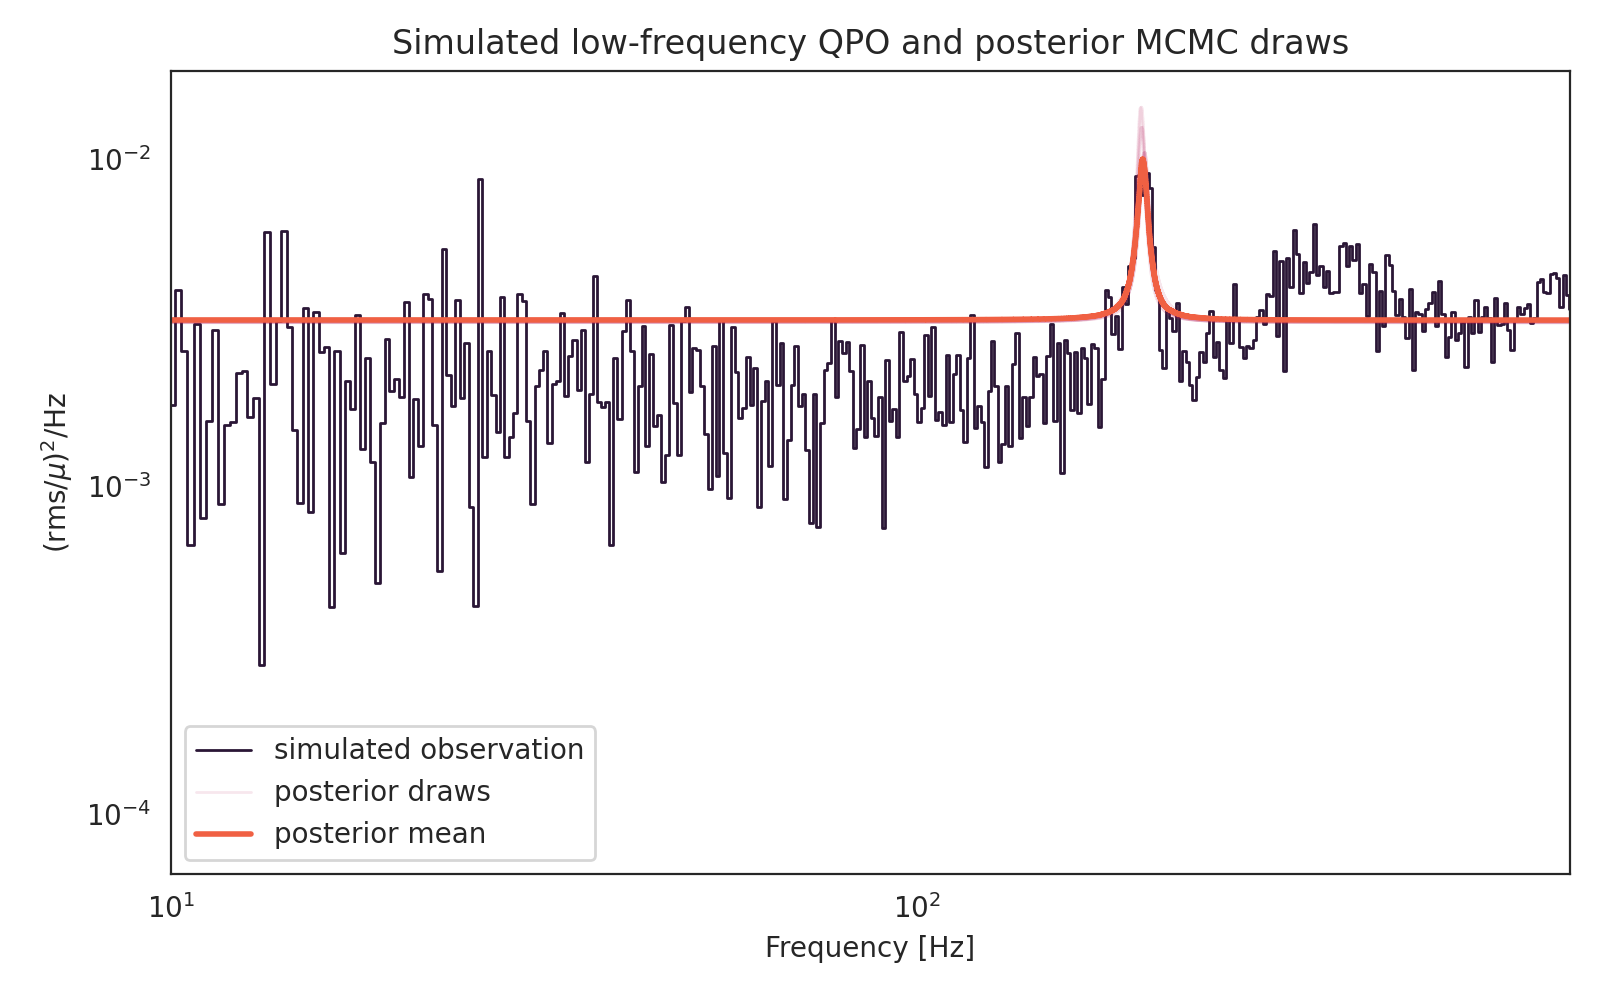

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_corr_obscr_log.freq, ps_corr_obscr_log.power, lw=1, color=pal[0], ds="steps-mid", label="simulated observation");

# plot simulations

for i, ps_sim in enumerate(sims_all):
    if i == 0:
        ax.loglog(ps_corr_obscr.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid', label="posterior draws")


    if i % 10 == 0:
        ax.loglog(ps_corr_obscr.freq, ps_sim, lw=1, color=pal[3], alpha=0.1, 
                  ds='steps-mid')


sims_all = np.array(sims_all)
ps_sim_mean = np.median(sims_all, axis=0)  

ax.loglog(ps_corr_obscr.freq, ps_sim_mean, lw=2, c=pal[5], ds="steps-mid", label="posterior mean")
ax.set_xlim(10, ps_corr_obscr.freq[-1])
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"$(\mathrm{rms}/\mu)^2/\mathrm{Hz}$")
ax.set_title("Simulated low-frequency QPO and posterior MCMC draws")
plt.tight_layout()
plt.savefig("../figs/qposim_hf_mcmc_draws.pdf", format="pdf")


Corner plot of traditional inference:

<IPython.core.display.Javascript object>


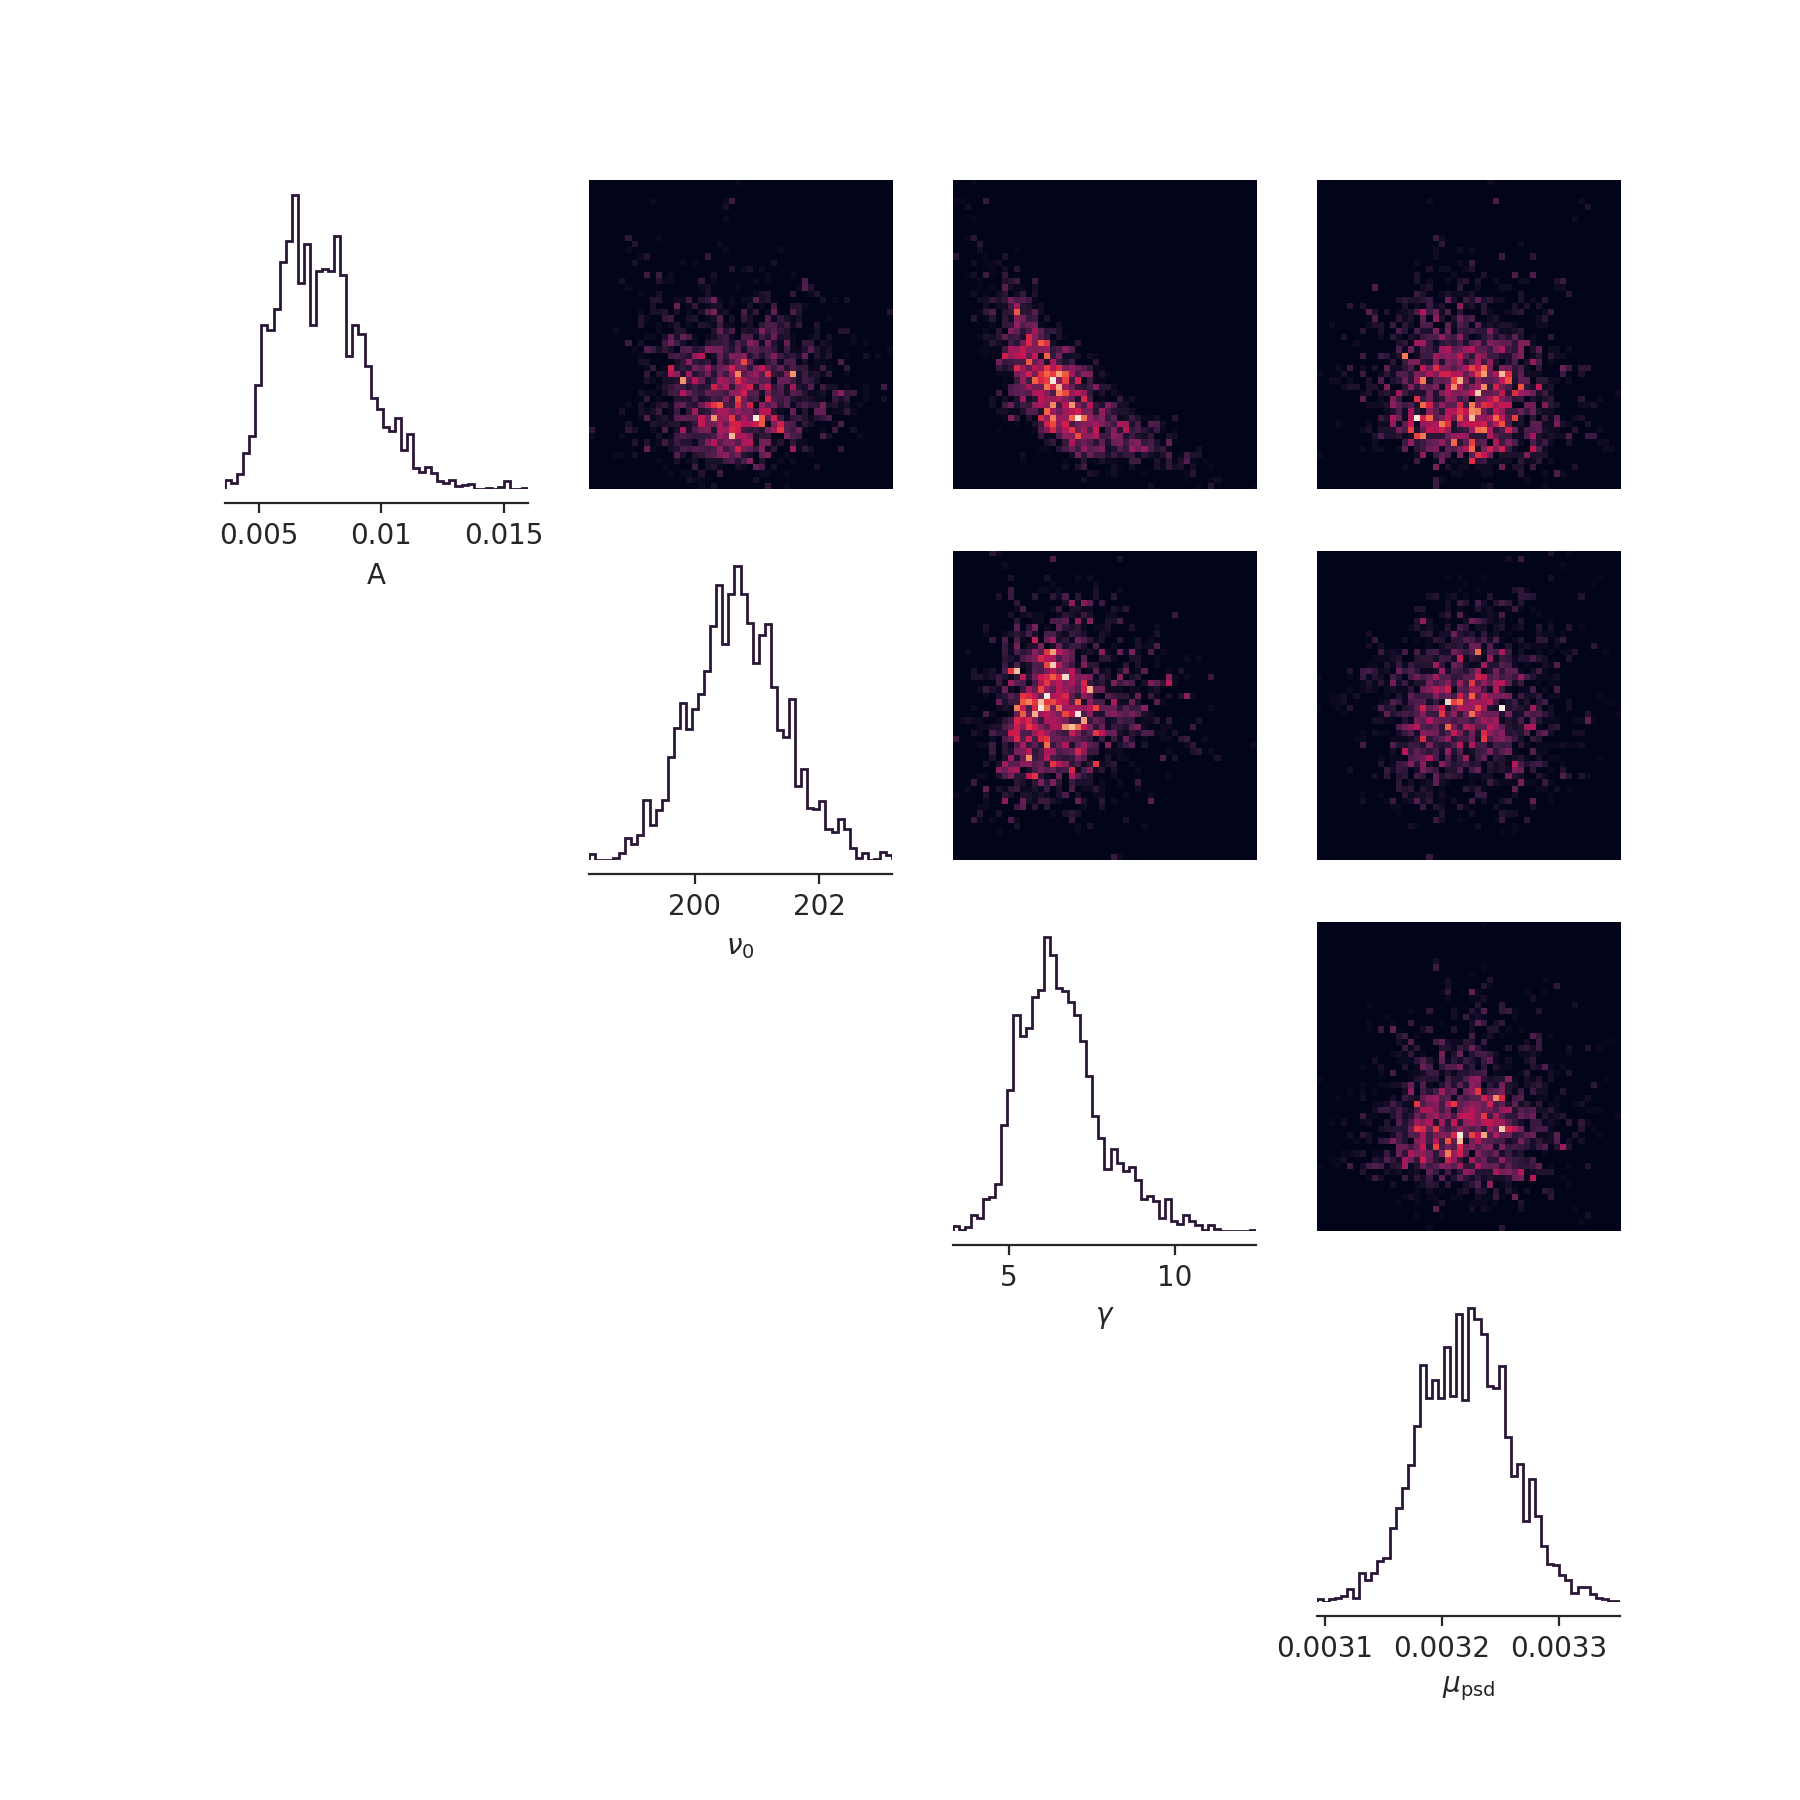

In [125]:
labels = ["A", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{psd}$"]

fig, axes = utils.pairplot(samp_mcmc.samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           labels=labels)
                           #points=np.array(param_obs),
                           #points_offdiag={'markersize': 6},
                           #points_colors='r');


Whats the fractional rms like?

In [126]:
rms_dt = np.array([np.sqrt(np.sum(lorentzian(ps_corr_obscr.freq, *s[:-1])*ps_corr_obscr.df)) for s in samp_mcmc.samples[-5000:,:]])

<IPython.core.display.Javascript object>


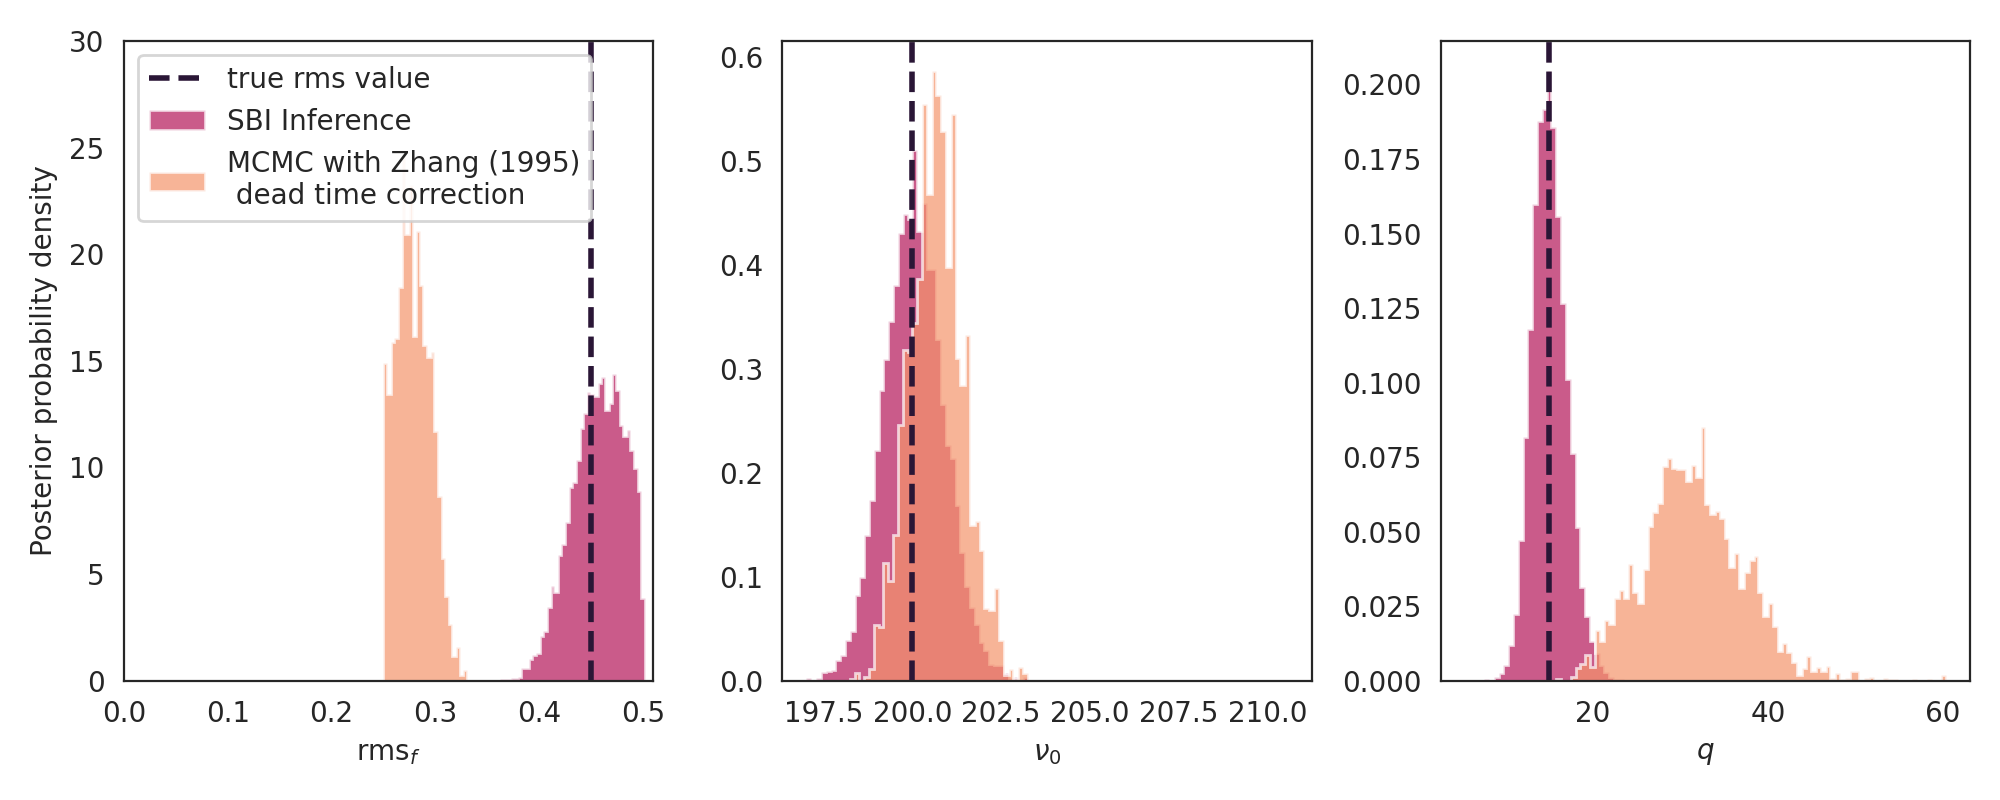

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

samples_se = np.array(samples_se)

xrange = [0.25, 0.6]

ax1.hist(samples_se[:,0], bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="SBI Inference", color=pal[3])
ax1.hist(rms_dt, bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="MCMC with Zhang (1995)\n dead time correction",
        color=pal[6])

ax1.axvline(param_obs[0], lw=2, c=pal[0], ls="dashed", label="true rms value")

ax1.legend(loc="upper left")
ax1.set_xlabel(r"$\mathrm{rms}_f$")
ax1.set_ylabel("Posterior probability density")
ax1.set_ylim(0,30)
ax1.set_xlim(0, 0.51)


xrange2 = [np.min(np.hstack([samples_se[:,1], samp_mcmc.samples[:,1]])),
           np.max(np.hstack([samples_se[:,1], samp_mcmc.samples[:,1]]))]

ax2.hist(samples_se[:,1], bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange2, density=True, label="SBI Inference", color=pal[3])
ax2.hist(samp_mcmc.samples[:,1], bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange2, density=True, label="MCMC with Zhang (1995)\n dead time correction",
        color=pal[6])

ax2.axvline(param_obs[1], lw=2, c=pal[0], ls="dashed", label="true rms value")

#ax2.legend(loc="upper left")
ax2.set_xlabel(r"$\nu_0$")
#ax2.set_ylabel("Posterior probability density")


q_samples = samp_mcmc.samples[:,1] / samp_mcmc.samples[:,2]

xrange3 = [np.min(np.hstack([samples_se[:,2], q_samples])), 
           np.max(np.hstack([samples_se[:,2], q_samples]))]

ax3.hist(samples_se[:,2], bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange3, density=True, label="SBI Inference", color=pal[3])
ax3.hist(q_samples, bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange3, density=True, label="MCMC with Zhang (1995)\n dead time correction",
        color=pal[6])

ax3.axvline(param_obs[2], lw=2, c=pal[0], ls="dashed", label="true rms value")

#ax3.legend(loc="upper left")
ax3.set_xlabel(r"$q$")
#ax3.set_ylabel("Posterior probability density")

plt.tight_layout()

plt.savefig("../figs/qposim_hf_rms_comp.pdf", format="pdf")
